In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [3]:
scorelist = []

In [4]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    scorelist.append(np.mean(scores))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## housing数据集实验

In [5]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('housing')

### 基学习器的训练

#### support vector regression

In [6]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:43:33 2019
Fold 1 started at Tue Dec 17 10:43:33 2019
Fold 2 started at Tue Dec 17 10:43:33 2019
Fold 3 started at Tue Dec 17 10:43:33 2019
Fold 4 started at Tue Dec 17 10:43:33 2019
Fold 5 started at Tue Dec 17 10:43:33 2019
Fold 6 started at Tue Dec 17 10:43:33 2019
Fold 7 started at Tue Dec 17 10:43:33 2019
Fold 8 started at Tue Dec 17 10:43:33 2019
Fold 9 started at Tue Dec 17 10:43:33 2019
CV mean score: 9.1245, std: 0.7779.


#### lightgbm

Fold 0 started at Tue Dec 17 10:43:33 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.51672	valid_1's rmse: 2.55576
[2000]	training's rmse: 0.933789	valid_1's rmse: 2.39941
[3000]	training's rmse: 0.639714	valid_1's rmse: 2.34406
[4000]	training's rmse: 0.458678	valid_1's rmse: 2.31747
[5000]	training's rmse: 0.341527	valid_1's rmse: 2.3058
[6000]	training's rmse: 0.259717	valid_1's rmse: 2.29588
[7000]	training's rmse: 0.204482	valid_1's rmse: 2.28974
[8000]	training's rmse: 0.164038	valid_1's rmse: 2.28359
[9000]	training's rmse: 0.134403	valid_1's rmse: 2.2781
[10000]	training's rmse: 0.111843	valid_1's rmse: 2.27518
Early stopping, best iteration is:
[10651]	training's rmse: 0.100816	valid_1's rmse: 2.27376
Fold 1 started at Tue Dec 17 10:44:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.5662	valid_1's rmse: 3.30173
[2000]	training's rmse: 0.978967	valid_1's rmse: 3.08003
Early stopping,

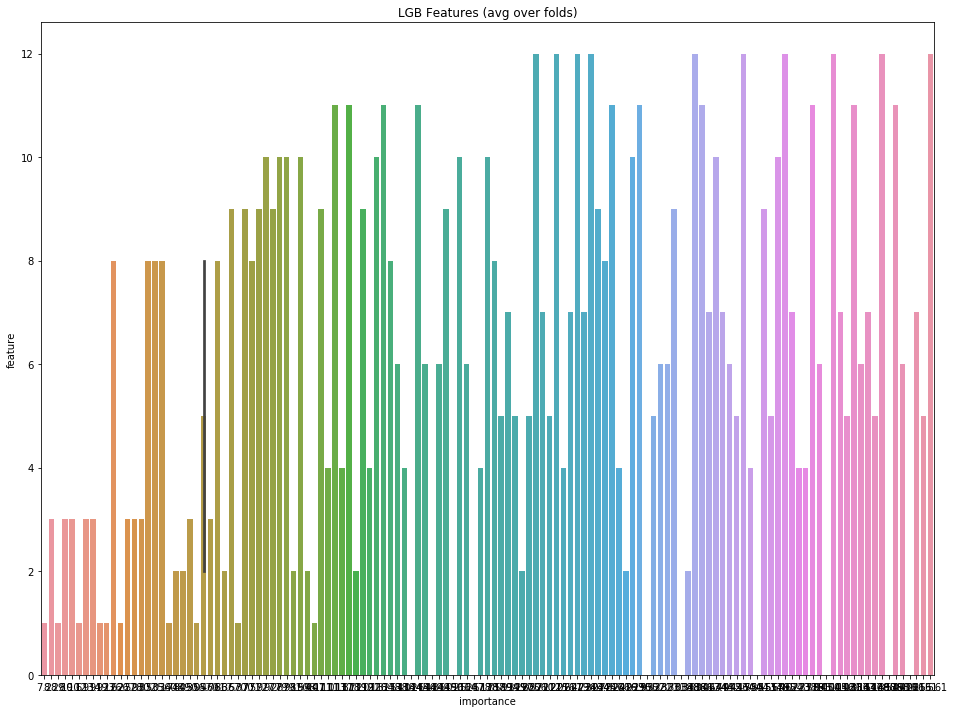

In [7]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:45:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73635	valid_1's rmse: 2.5763
[2000]	training's rmse: 1.1854	valid_1's rmse: 2.39912
[3000]	training's rmse: 0.895723	valid_1's rmse: 2.33818
Early stopping, best iteration is:
[3608]	training's rmse: 0.770595	valid_1's rmse: 2.32185
Fold 1 started at Tue Dec 17 10:46:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.80087	valid_1's rmse: 3.30131
[2000]	training's rmse: 1.23775	valid_1's rmse: 3.0459
Early stopping, best iteration is:
[2368]	training's rmse: 1.10299	valid_1's rmse: 3.0237
Fold 2 started at Tue Dec 17 10:46:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.74808	valid_1's rmse: 2.6974
Early stopping, best iteration is:
[1749]	training's rmse: 1.31311	valid_1's rmse: 2.63436
Fold 3 started at Tue Dec 17 10:46:34 2019
Training until validation scores 

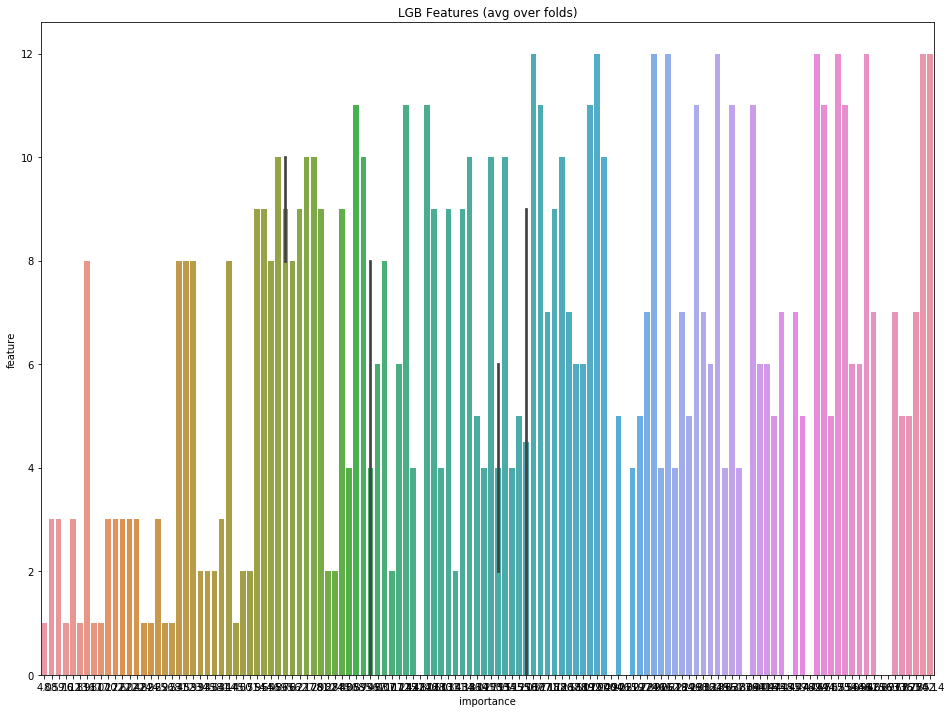

In [8]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:48:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73635	valid_1's rmse: 2.5763
[2000]	training's rmse: 1.1854	valid_1's rmse: 2.39912
[3000]	training's rmse: 0.895723	valid_1's rmse: 2.33818
Early stopping, best iteration is:
[3608]	training's rmse: 0.770595	valid_1's rmse: 2.32185
Fold 1 started at Tue Dec 17 10:48:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.80087	valid_1's rmse: 3.30131
[2000]	training's rmse: 1.23775	valid_1's rmse: 3.0459
Early stopping, best iteration is:
[2368]	training's rmse: 1.10299	valid_1's rmse: 3.0237
Fold 2 started at Tue Dec 17 10:48:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.74808	valid_1's rmse: 2.6974
Early stopping, best iteration is:
[1749]	training's rmse: 1.31311	valid_1's rmse: 2.63436
Fold 3 started at Tue Dec 17 10:48:26 2019
Training until validation scores 

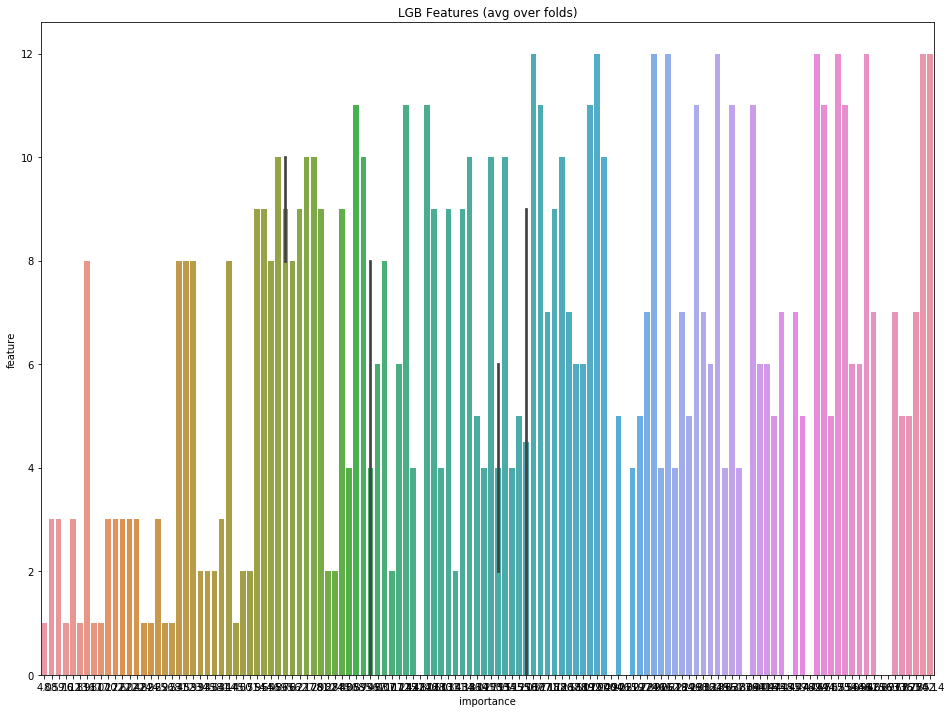

In [9]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

#### random forest regression

In [10]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:51:23 2019
Fold 1 started at Tue Dec 17 10:51:23 2019
Fold 2 started at Tue Dec 17 10:51:24 2019
Fold 3 started at Tue Dec 17 10:51:24 2019
Fold 4 started at Tue Dec 17 10:51:24 2019
Fold 5 started at Tue Dec 17 10:51:24 2019
Fold 6 started at Tue Dec 17 10:51:25 2019
Fold 7 started at Tue Dec 17 10:51:25 2019
Fold 8 started at Tue Dec 17 10:51:25 2019
Fold 9 started at Tue Dec 17 10:51:25 2019
CV mean score: 3.7120, std: 0.6633.


#### xgboost

In [11]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:51:25 2019
[0]	train-rmse:23.8409	valid_data-rmse:21.8451
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.88808	valid_data-rmse:2.17502
[1000]	train-rmse:0.301024	valid_data-rmse:2.13631
[1500]	train-rmse:0.114484	valid_data-rmse:2.1289
[2000]	train-rmse:0.047412	valid_data-rmse:2.12458
Stopping. Best iteration:
[2270]	train-rmse:0.02959	valid_data-rmse:2.12388

Fold 1 started at Tue Dec 17 10:51:29 2019
[0]	train-rmse:23.7119	valid_data-rmse:23.053
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.920316	valid_data-rmse:2.90207
[1000]	train-rmse:0.31605	valid_data-rmse:2.74335
[1500]	train-rmse:0.119593	valid_data-rmse:2.72775
Stopping. Best iteration:
[1509]	train-rmse:0.117768	valid_data-rmse:2.72755

Fo

#### catboost

In [12]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 17 10:51:52 2019
Fold 1 started at Tue Dec 17 10:52:38 2019
Fold 2 started at Tue Dec 17 10:53:35 2019
Fold 3 started at Tue Dec 17 10:54:20 2019
Fold 4 started at Tue Dec 17 10:55:08 2019
Fold 5 started at Tue Dec 17 10:55:35 2019
Fold 6 started at Tue Dec 17 10:56:16 2019
Fold 7 started at Tue Dec 17 10:56:32 2019
Fold 8 started at Tue Dec 17 10:57:28 2019
Fold 9 started at Tue Dec 17 10:58:36 2019
CV mean score: 2.8985, std: 0.4331.


### stacking

#### 所有结果均用于做stacking

In [13]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:59:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[418]	training's rmse: 2.19564	valid_1's rmse: 2.20728
Fold 1 started at Tue Dec 17 10:59:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[764]	training's rmse: 1.84576	valid_1's rmse: 2.97986
Fold 2 started at Tue Dec 17 10:59:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[318]	training's rmse: 2.25867	valid_1's rmse: 2.64977
Fold 3 started at Tue Dec 17 11:00:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[386]	training's rmse: 2.16082	valid_1's rmse: 2.90979
Fold 4 started at Tue Dec 17 11:00:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[195]	training's rmse: 2.55944	valid_1's rmse: 4.16033
Fold 5 started at Tu

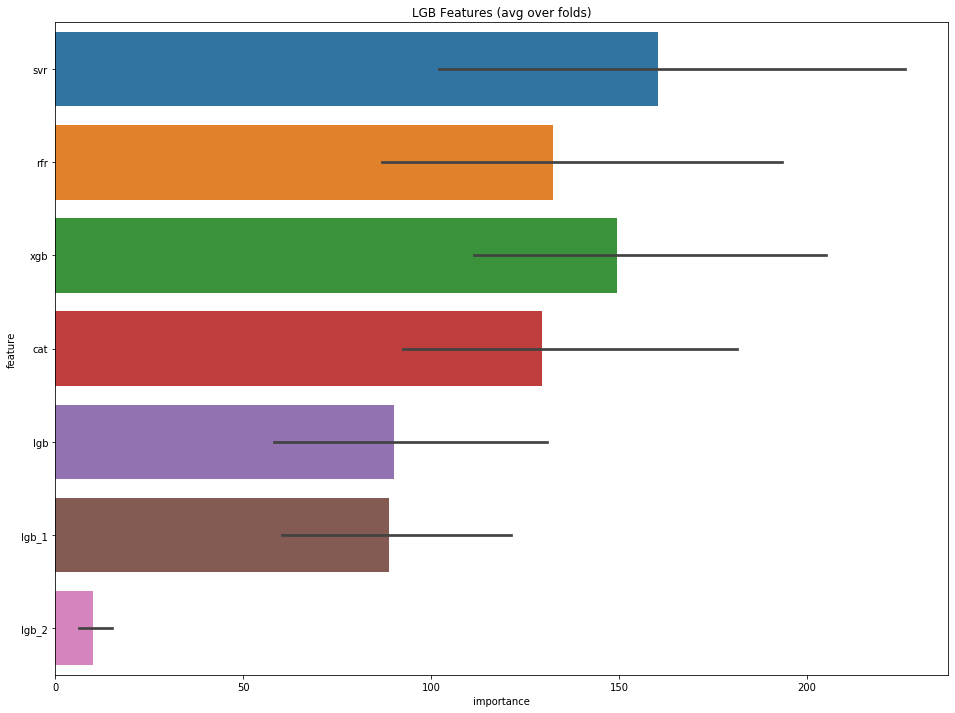

In [14]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:01:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.17474	valid_1's rmse: 2.18066
Early stopping, best iteration is:
[842]	training's rmse: 2.22018	valid_1's rmse: 2.16714
Fold 1 started at Tue Dec 17 11:01:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.10845	valid_1's rmse: 2.81852
Early stopping, best iteration is:
[1319]	training's rmse: 2.02906	valid_1's rmse: 2.79049
Fold 2 started at Tue Dec 17 11:01:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.4102	valid_1's rmse: 2.61577
Fold 3 started at Tue Dec 17 11:01:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[422]	training's rmse: 2.34708	valid_1's rmse: 2.79466
Fold 4 started at Tue Dec 17 11:01:33 2019
Training until validation scores don't improve for 200 rounds

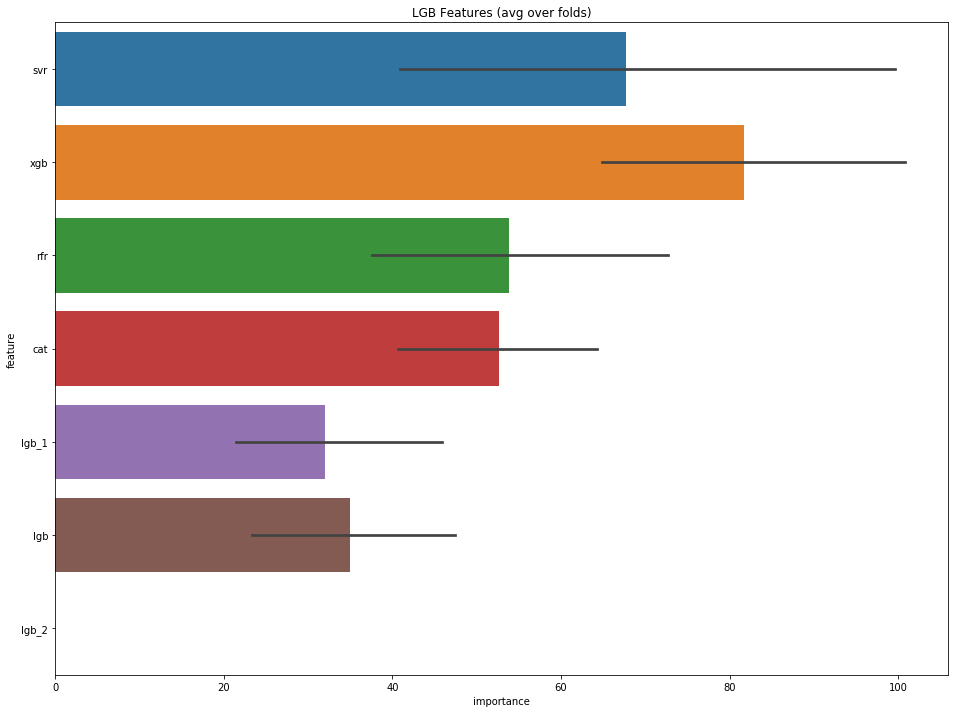

In [15]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [16]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:01:57 2019
Fold 1 started at Tue Dec 17 11:02:11 2019
Fold 2 started at Tue Dec 17 11:02:23 2019
Fold 3 started at Tue Dec 17 11:02:32 2019
Fold 4 started at Tue Dec 17 11:02:47 2019
Fold 5 started at Tue Dec 17 11:02:54 2019
Fold 6 started at Tue Dec 17 11:03:02 2019
Fold 7 started at Tue Dec 17 11:03:11 2019
Fold 8 started at Tue Dec 17 11:03:20 2019
Fold 9 started at Tue Dec 17 11:03:38 2019
CV mean score: 2.8967, std: 0.5150.


##### randomforest作为第二层融合模型

In [17]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:03:48 2019
Fold 1 started at Tue Dec 17 11:03:49 2019
Fold 2 started at Tue Dec 17 11:03:49 2019
Fold 3 started at Tue Dec 17 11:03:49 2019
Fold 4 started at Tue Dec 17 11:03:49 2019
Fold 5 started at Tue Dec 17 11:03:50 2019
Fold 6 started at Tue Dec 17 11:03:50 2019
Fold 7 started at Tue Dec 17 11:03:50 2019
Fold 8 started at Tue Dec 17 11:03:50 2019
Fold 9 started at Tue Dec 17 11:03:51 2019
CV mean score: 2.9417, std: 0.5086.


##### xgboost作为第二层融合模型

In [18]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:03:51 2019
[0]	train-rmse:23.8348	valid_data-rmse:21.8402
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.14876	valid_data-rmse:2.28496
Stopping. Best iteration:
[699]	train-rmse:0.830555	valid_data-rmse:2.24382

Fold 1 started at Tue Dec 17 11:03:52 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0493
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.13791	valid_data-rmse:2.8894
Stopping. Best iteration:
[626]	train-rmse:0.913781	valid_data-rmse:2.87475

Fold 2 started at Tue Dec 17 11:03:52 2019
[0]	train-rmse:23.7738	valid_data-rmse:22.4244
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train

##### svr 作为第二层融合模型

In [19]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:03:56 2019
Fold 1 started at Tue Dec 17 11:03:57 2019
Fold 2 started at Tue Dec 17 11:03:57 2019
Fold 3 started at Tue Dec 17 11:03:57 2019
Fold 4 started at Tue Dec 17 11:03:57 2019
Fold 5 started at Tue Dec 17 11:03:57 2019
Fold 6 started at Tue Dec 17 11:03:57 2019
Fold 7 started at Tue Dec 17 11:03:57 2019
Fold 8 started at Tue Dec 17 11:03:57 2019
Fold 9 started at Tue Dec 17 11:03:57 2019
CV mean score: 7.2888, std: 0.7907.


##### 岭回归做第二层融合模型

In [20]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:03:57 2019
Fold 1 started at Tue Dec 17 11:03:57 2019
Fold 2 started at Tue Dec 17 11:03:57 2019
Fold 3 started at Tue Dec 17 11:03:57 2019
Fold 4 started at Tue Dec 17 11:03:57 2019
Fold 5 started at Tue Dec 17 11:03:57 2019
Fold 6 started at Tue Dec 17 11:03:57 2019
Fold 7 started at Tue Dec 17 11:03:57 2019
Fold 8 started at Tue Dec 17 11:03:58 2019
Fold 9 started at Tue Dec 17 11:03:58 2019
CV mean score: 2.8664, std: 0.5468.


#### 去掉lgb的结果

In [21]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:03:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 2.24616	valid_1's rmse: 2.0946
Fold 1 started at Tue Dec 17 11:04:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.83005	valid_1's rmse: 2.82817
Early stopping, best iteration is:
[1431]	training's rmse: 1.66419	valid_1's rmse: 2.80817
Fold 2 started at Tue Dec 17 11:04:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's rmse: 2.35124	valid_1's rmse: 2.61074
Fold 3 started at Tue Dec 17 11:04:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[375]	training's rmse: 2.25732	valid_1's rmse: 2.82128
Fold 4 started at Tue Dec 17 11:04:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rm

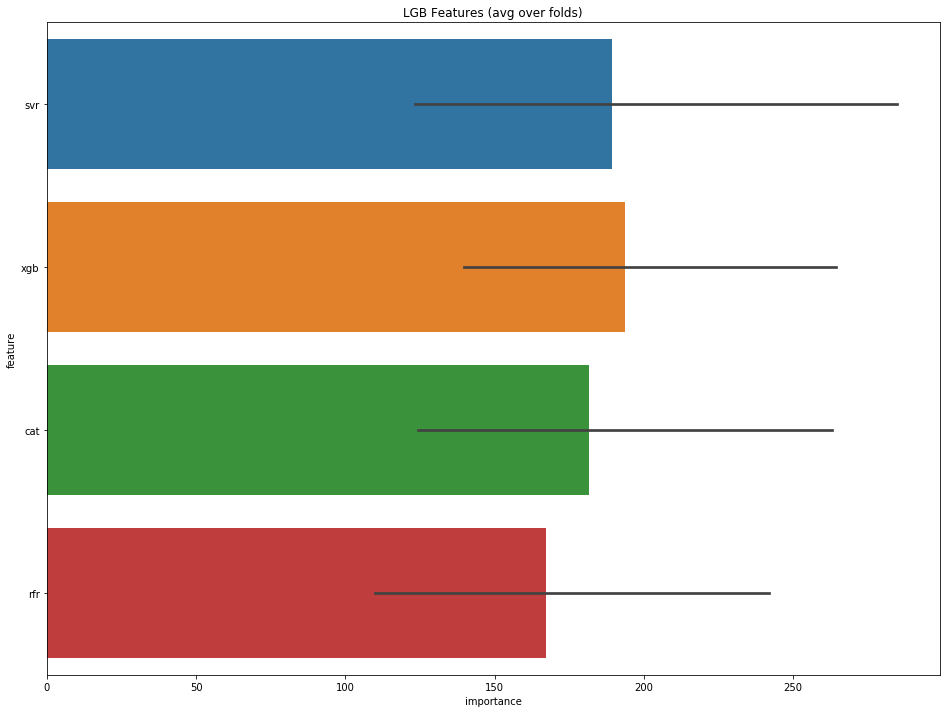

In [22]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:04:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[559]	training's rmse: 2.36801	valid_1's rmse: 2.08492
Fold 1 started at Tue Dec 17 11:04:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[660]	training's rmse: 2.28199	valid_1's rmse: 2.84964
Fold 2 started at Tue Dec 17 11:04:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 2.44443	valid_1's rmse: 2.59596
Fold 3 started at Tue Dec 17 11:04:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.40138	valid_1's rmse: 2.74116
Fold 4 started at Tue Dec 17 11:04:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[212]	training's rmse: 2.62009	valid_1's rmse: 3.95745
Fold 5 started at Tu

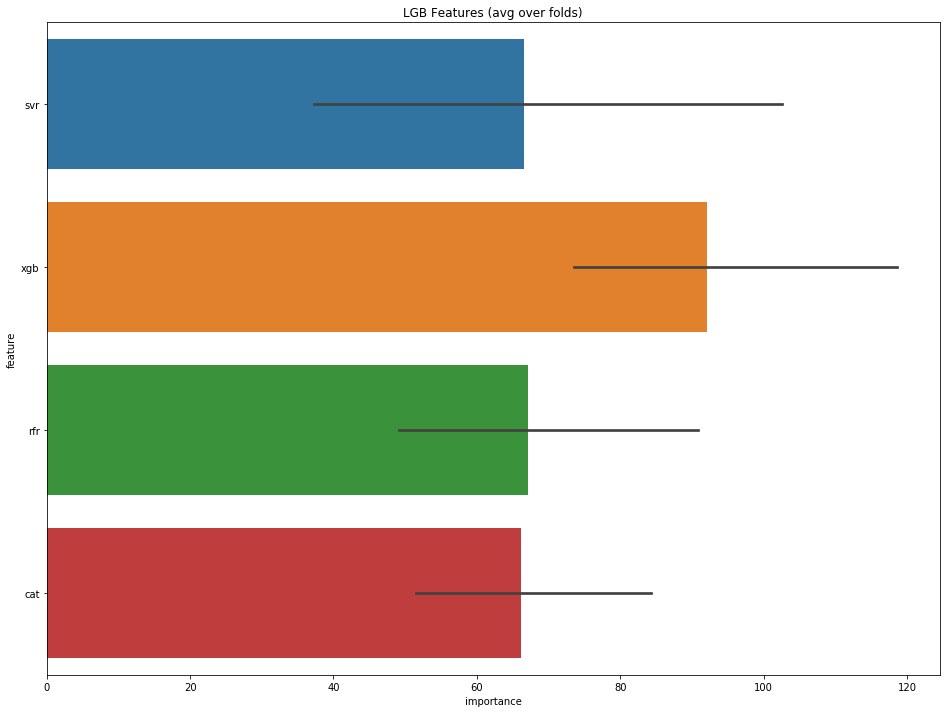

In [23]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [24]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:05:16 2019
Fold 1 started at Tue Dec 17 11:05:31 2019
Fold 2 started at Tue Dec 17 11:06:40 2019
Fold 3 started at Tue Dec 17 11:06:50 2019
Fold 4 started at Tue Dec 17 11:07:03 2019
Fold 5 started at Tue Dec 17 11:07:11 2019
Fold 6 started at Tue Dec 17 11:07:19 2019
Fold 7 started at Tue Dec 17 11:07:29 2019
Fold 8 started at Tue Dec 17 11:07:38 2019
Fold 9 started at Tue Dec 17 11:07:53 2019
CV mean score: 2.8200, std: 0.4240.


##### randomforest作为第二层融合模型

In [25]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:08:02 2019
Fold 1 started at Tue Dec 17 11:08:03 2019
Fold 2 started at Tue Dec 17 11:08:03 2019
Fold 3 started at Tue Dec 17 11:08:03 2019
Fold 4 started at Tue Dec 17 11:08:03 2019
Fold 5 started at Tue Dec 17 11:08:04 2019
Fold 6 started at Tue Dec 17 11:08:04 2019
Fold 7 started at Tue Dec 17 11:08:04 2019
Fold 8 started at Tue Dec 17 11:08:04 2019
Fold 9 started at Tue Dec 17 11:08:05 2019
CV mean score: 2.9646, std: 0.4340.


##### xgboost作为第二层融合模型

In [26]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:08:05 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.84
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25111	valid_data-rmse:2.23776
Stopping. Best iteration:
[597]	train-rmse:1.0765	valid_data-rmse:2.22502

Fold 1 started at Tue Dec 17 11:08:05 2019
[0]	train-rmse:23.7079	valid_data-rmse:23.0494
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20982	valid_data-rmse:2.63923
Stopping. Best iteration:
[729]	train-rmse:0.853206	valid_data-rmse:2.57344

Fold 2 started at Tue Dec 17 11:08:06 2019
[0]	train-rmse:23.7747	valid_data-rmse:22.4236
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [27]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:08:12 2019
Fold 1 started at Tue Dec 17 11:08:12 2019
Fold 2 started at Tue Dec 17 11:08:12 2019
Fold 3 started at Tue Dec 17 11:08:12 2019
Fold 4 started at Tue Dec 17 11:08:12 2019
Fold 5 started at Tue Dec 17 11:08:12 2019
Fold 6 started at Tue Dec 17 11:08:12 2019
Fold 7 started at Tue Dec 17 11:08:12 2019
Fold 8 started at Tue Dec 17 11:08:12 2019
Fold 9 started at Tue Dec 17 11:08:12 2019
CV mean score: 6.9787, std: 0.7407.


##### 岭回归做第二层融合模型

In [28]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:08:12 2019
Fold 1 started at Tue Dec 17 11:08:12 2019
Fold 2 started at Tue Dec 17 11:08:12 2019
Fold 3 started at Tue Dec 17 11:08:12 2019
Fold 4 started at Tue Dec 17 11:08:12 2019
Fold 5 started at Tue Dec 17 11:08:13 2019
Fold 6 started at Tue Dec 17 11:08:13 2019
Fold 7 started at Tue Dec 17 11:08:13 2019
Fold 8 started at Tue Dec 17 11:08:13 2019
Fold 9 started at Tue Dec 17 11:08:13 2019
CV mean score: 2.8330, std: 0.5077.


#### 去掉xgboost的结果

In [29]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:08:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[454]	training's rmse: 2.24361	valid_1's rmse: 2.18998
Fold 1 started at Tue Dec 17 11:08:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[322]	training's rmse: 2.29671	valid_1's rmse: 3.28626
Fold 2 started at Tue Dec 17 11:08:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[302]	training's rmse: 2.40547	valid_1's rmse: 2.72258
Fold 3 started at Tue Dec 17 11:08:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[385]	training's rmse: 2.28221	valid_1's rmse: 2.99817
Fold 4 started at Tue Dec 17 11:08:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's rmse: 2.55889	valid_1's rmse: 4.14169
Fold 5 started at Tu

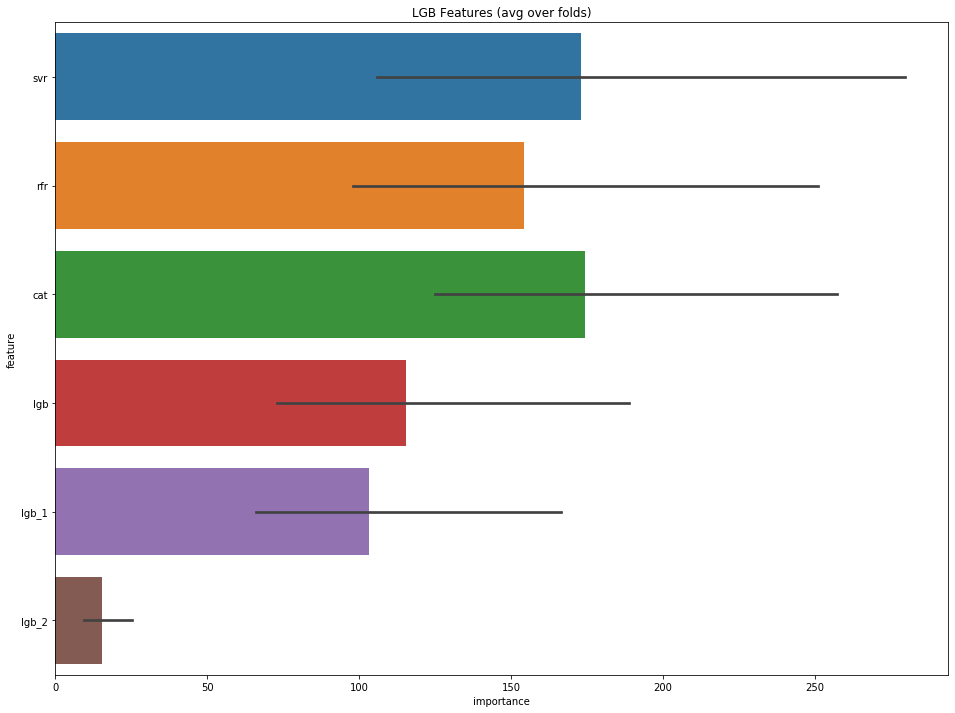

In [30]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:09:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[435]	training's rmse: 2.4634	valid_1's rmse: 2.20274
Fold 1 started at Tue Dec 17 11:09:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[588]	training's rmse: 2.28892	valid_1's rmse: 3.23167
Fold 2 started at Tue Dec 17 11:09:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[343]	training's rmse: 2.49017	valid_1's rmse: 2.68908
Fold 3 started at Tue Dec 17 11:09:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[496]	training's rmse: 2.389	valid_1's rmse: 2.8724
Fold 4 started at Tue Dec 17 11:10:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.60802	valid_1's rmse: 4.15287
Fold 5 started at Tue De

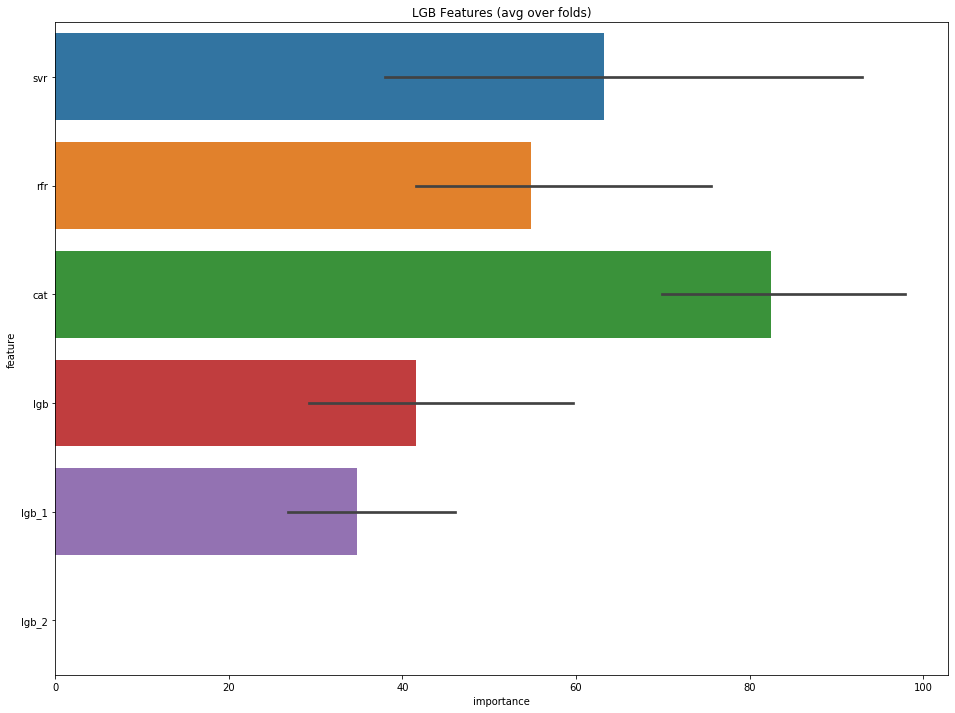

In [31]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [32]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:10:29 2019
Fold 1 started at Tue Dec 17 11:10:44 2019
Fold 2 started at Tue Dec 17 11:10:54 2019
Fold 3 started at Tue Dec 17 11:11:04 2019
Fold 4 started at Tue Dec 17 11:11:18 2019
Fold 5 started at Tue Dec 17 11:11:24 2019
Fold 6 started at Tue Dec 17 11:11:33 2019
Fold 7 started at Tue Dec 17 11:11:43 2019
Fold 8 started at Tue Dec 17 11:11:53 2019
Fold 9 started at Tue Dec 17 11:12:08 2019
CV mean score: 2.9798, std: 0.5513.


##### randomforest作为第二层融合模型

In [33]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:12:19 2019
Fold 1 started at Tue Dec 17 11:12:19 2019
Fold 2 started at Tue Dec 17 11:12:20 2019
Fold 3 started at Tue Dec 17 11:12:20 2019
Fold 4 started at Tue Dec 17 11:12:20 2019
Fold 5 started at Tue Dec 17 11:12:20 2019
Fold 6 started at Tue Dec 17 11:12:21 2019
Fold 7 started at Tue Dec 17 11:12:21 2019
Fold 8 started at Tue Dec 17 11:12:21 2019
Fold 9 started at Tue Dec 17 11:12:21 2019
CV mean score: 3.0262, std: 0.5817.


##### xgboost作为第二层融合模型

In [34]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:12:21 2019
[0]	train-rmse:23.8348	valid_data-rmse:21.8387
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.23564	valid_data-rmse:2.33271
Stopping. Best iteration:
[798]	train-rmse:0.787727	valid_data-rmse:2.30194

Fold 1 started at Tue Dec 17 11:12:22 2019
[0]	train-rmse:23.7078	valid_data-rmse:23.0491
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20801	valid_data-rmse:3.39223
Stopping. Best iteration:
[639]	train-rmse:0.955553	valid_data-rmse:3.37577

Fold 2 started at Tue Dec 17 11:12:23 2019
[0]	train-rmse:23.7748	valid_data-rmse:22.4276
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	trai

##### svr 作为第二层融合模型

In [35]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:12:27 2019
Fold 1 started at Tue Dec 17 11:12:27 2019
Fold 2 started at Tue Dec 17 11:12:27 2019
Fold 3 started at Tue Dec 17 11:12:27 2019
Fold 4 started at Tue Dec 17 11:12:27 2019
Fold 5 started at Tue Dec 17 11:12:27 2019
Fold 6 started at Tue Dec 17 11:12:27 2019
Fold 7 started at Tue Dec 17 11:12:27 2019
Fold 8 started at Tue Dec 17 11:12:27 2019
Fold 9 started at Tue Dec 17 11:12:27 2019
CV mean score: 7.1762, std: 0.7896.


##### 岭回归做第二层融合模型

In [36]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:12:27 2019
Fold 1 started at Tue Dec 17 11:12:27 2019
Fold 2 started at Tue Dec 17 11:12:28 2019
Fold 3 started at Tue Dec 17 11:12:28 2019
Fold 4 started at Tue Dec 17 11:12:28 2019
Fold 5 started at Tue Dec 17 11:12:28 2019
Fold 6 started at Tue Dec 17 11:12:28 2019
Fold 7 started at Tue Dec 17 11:12:28 2019
Fold 8 started at Tue Dec 17 11:12:28 2019
Fold 9 started at Tue Dec 17 11:12:28 2019
CV mean score: 2.9247, std: 0.5444.


#### 去掉svr的结果

In [37]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:12:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[419]	training's rmse: 2.31255	valid_1's rmse: 2.26786
Fold 1 started at Tue Dec 17 11:12:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[714]	training's rmse: 2.06566	valid_1's rmse: 2.90572
Fold 2 started at Tue Dec 17 11:12:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 2.34162	valid_1's rmse: 2.65007
Fold 3 started at Tue Dec 17 11:12:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[485]	training's rmse: 2.19823	valid_1's rmse: 2.91676
Fold 4 started at Tue Dec 17 11:13:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[196]	training's rmse: 2.57573	valid_1's rmse: 4.14636
Fold 5 started at Tu

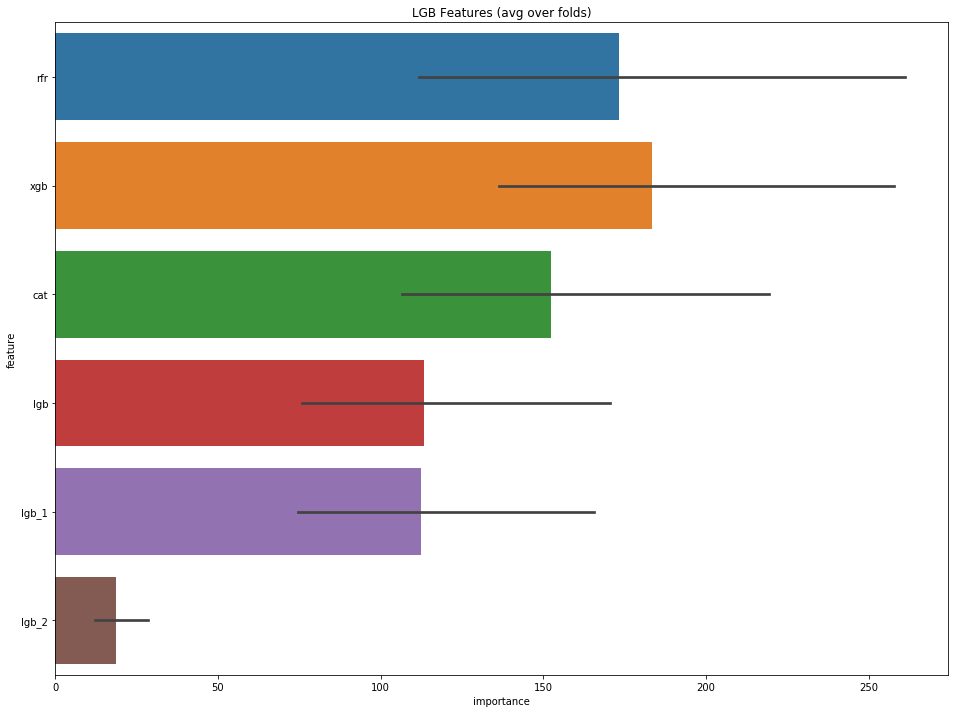

In [38]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:14:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[668]	training's rmse: 2.38682	valid_1's rmse: 2.19808
Fold 1 started at Tue Dec 17 11:14:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[500]	training's rmse: 2.38218	valid_1's rmse: 2.91164
Fold 2 started at Tue Dec 17 11:14:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[607]	training's rmse: 2.36556	valid_1's rmse: 2.61717
Fold 3 started at Tue Dec 17 11:14:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[673]	training's rmse: 2.35369	valid_1's rmse: 2.80813
Fold 4 started at Tue Dec 17 11:14:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[197]	training's rmse: 2.6496	valid_1's rmse: 4.21004
Fold 5 started at Tue

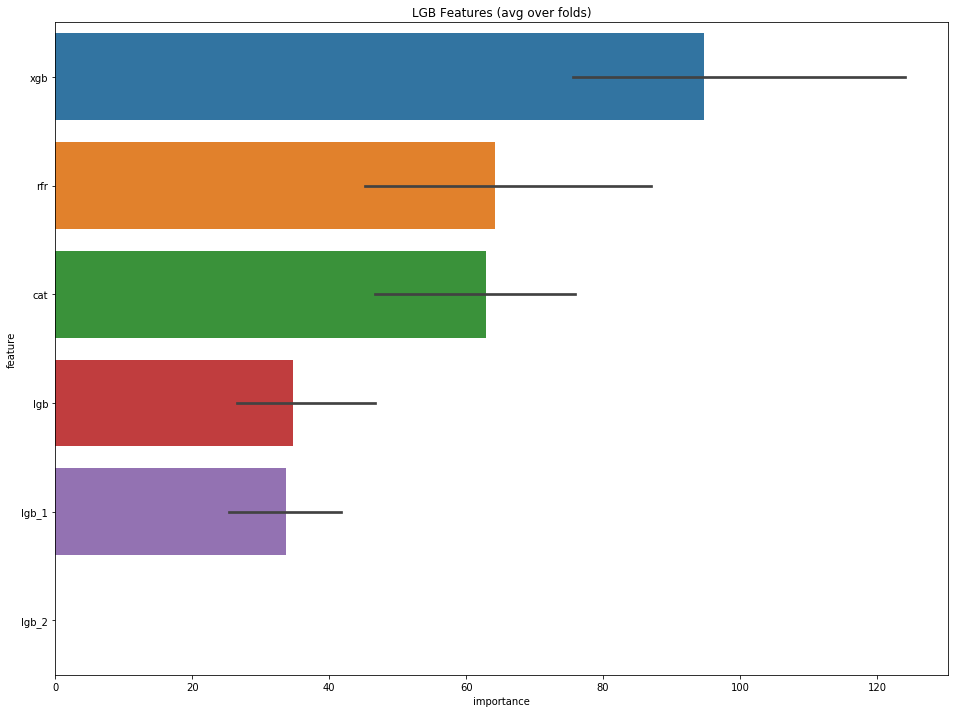

In [39]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [40]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:14:49 2019
Fold 1 started at Tue Dec 17 11:15:02 2019
Fold 2 started at Tue Dec 17 11:15:26 2019
Fold 3 started at Tue Dec 17 11:15:35 2019
Fold 4 started at Tue Dec 17 11:15:49 2019
Fold 5 started at Tue Dec 17 11:15:54 2019
Fold 6 started at Tue Dec 17 11:16:02 2019
Fold 7 started at Tue Dec 17 11:16:14 2019
Fold 8 started at Tue Dec 17 11:16:23 2019
Fold 9 started at Tue Dec 17 11:16:43 2019
CV mean score: 2.8926, std: 0.5440.


##### randomforest作为第二层融合模型

In [41]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:16:53 2019
Fold 1 started at Tue Dec 17 11:16:53 2019
Fold 2 started at Tue Dec 17 11:16:54 2019
Fold 3 started at Tue Dec 17 11:16:54 2019
Fold 4 started at Tue Dec 17 11:16:54 2019
Fold 5 started at Tue Dec 17 11:16:54 2019
Fold 6 started at Tue Dec 17 11:16:55 2019
Fold 7 started at Tue Dec 17 11:16:55 2019
Fold 8 started at Tue Dec 17 11:16:55 2019
Fold 9 started at Tue Dec 17 11:16:55 2019
CV mean score: 2.9128, std: 0.5345.


##### xgboost作为第二层融合模型

In [42]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:16:56 2019
[0]	train-rmse:23.8348	valid_data-rmse:21.8402
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25502	valid_data-rmse:2.32141
Stopping. Best iteration:
[562]	train-rmse:1.14997	valid_data-rmse:2.31132

Fold 1 started at Tue Dec 17 11:16:56 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0493
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24412	valid_data-rmse:2.85644
Stopping. Best iteration:
[680]	train-rmse:0.967581	valid_data-rmse:2.80917

Fold 2 started at Tue Dec 17 11:16:57 2019
[0]	train-rmse:23.7743	valid_data-rmse:22.4255
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train

##### svr 作为第二层融合模型

In [43]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:17:00 2019
Fold 1 started at Tue Dec 17 11:17:00 2019
Fold 2 started at Tue Dec 17 11:17:00 2019
Fold 3 started at Tue Dec 17 11:17:00 2019
Fold 4 started at Tue Dec 17 11:17:00 2019
Fold 5 started at Tue Dec 17 11:17:01 2019
Fold 6 started at Tue Dec 17 11:17:01 2019
Fold 7 started at Tue Dec 17 11:17:01 2019
Fold 8 started at Tue Dec 17 11:17:01 2019
Fold 9 started at Tue Dec 17 11:17:01 2019
CV mean score: 7.3697, std: 0.7889.


##### 岭回归做第二层融合模型

In [44]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:17:01 2019
Fold 1 started at Tue Dec 17 11:17:01 2019
Fold 2 started at Tue Dec 17 11:17:01 2019
Fold 3 started at Tue Dec 17 11:17:01 2019
Fold 4 started at Tue Dec 17 11:17:01 2019
Fold 5 started at Tue Dec 17 11:17:01 2019
Fold 6 started at Tue Dec 17 11:17:01 2019
Fold 7 started at Tue Dec 17 11:17:01 2019
Fold 8 started at Tue Dec 17 11:17:02 2019
Fold 9 started at Tue Dec 17 11:17:02 2019
CV mean score: 2.8666, std: 0.5468.


#### 去掉rfr的结果

In [45]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:17:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[433]	training's rmse: 2.23262	valid_1's rmse: 2.25578
Fold 1 started at Tue Dec 17 11:17:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[349]	training's rmse: 2.26337	valid_1's rmse: 3.01966
Fold 2 started at Tue Dec 17 11:17:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 2.35432	valid_1's rmse: 2.83974
Fold 3 started at Tue Dec 17 11:17:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[591]	training's rmse: 2.06979	valid_1's rmse: 2.98598
Fold 4 started at Tue Dec 17 11:17:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[193]	training's rmse: 2.61262	valid_1's rmse: 4.17392
Fold 5 started at Tu

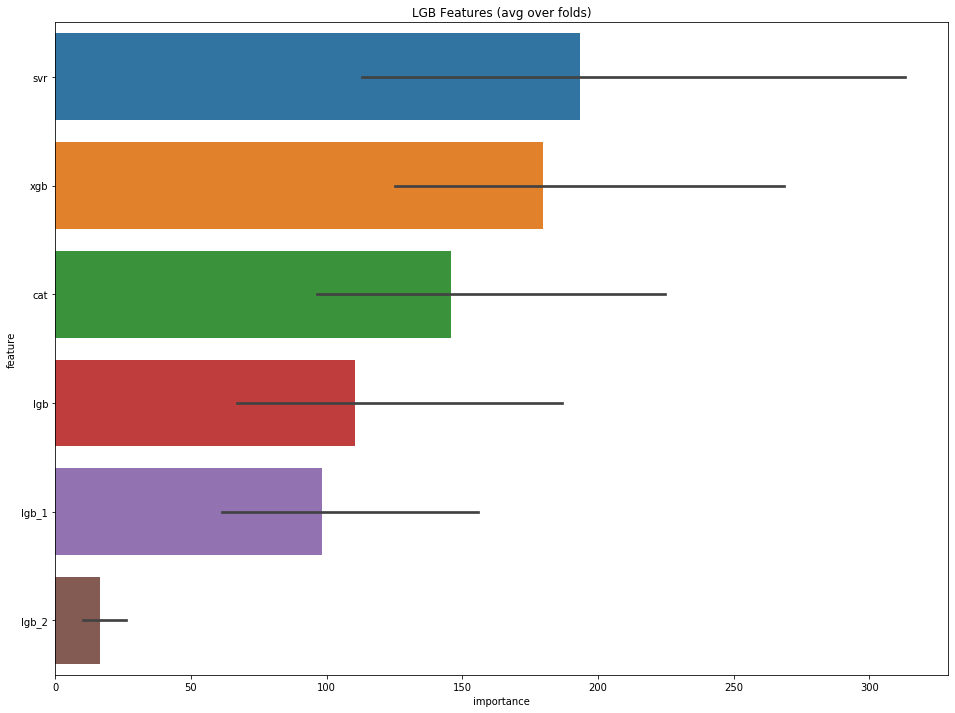

In [46]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:17:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[435]	training's rmse: 2.4238	valid_1's rmse: 2.24586
Fold 1 started at Tue Dec 17 11:18:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.43952	valid_1's rmse: 3.01339
Fold 2 started at Tue Dec 17 11:18:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[308]	training's rmse: 2.46649	valid_1's rmse: 2.83451
Fold 3 started at Tue Dec 17 11:18:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 2.40972	valid_1's rmse: 2.92075
Fold 4 started at Tue Dec 17 11:18:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[197]	training's rmse: 2.68442	valid_1's rmse: 4.227
Fold 5 started at Tue D

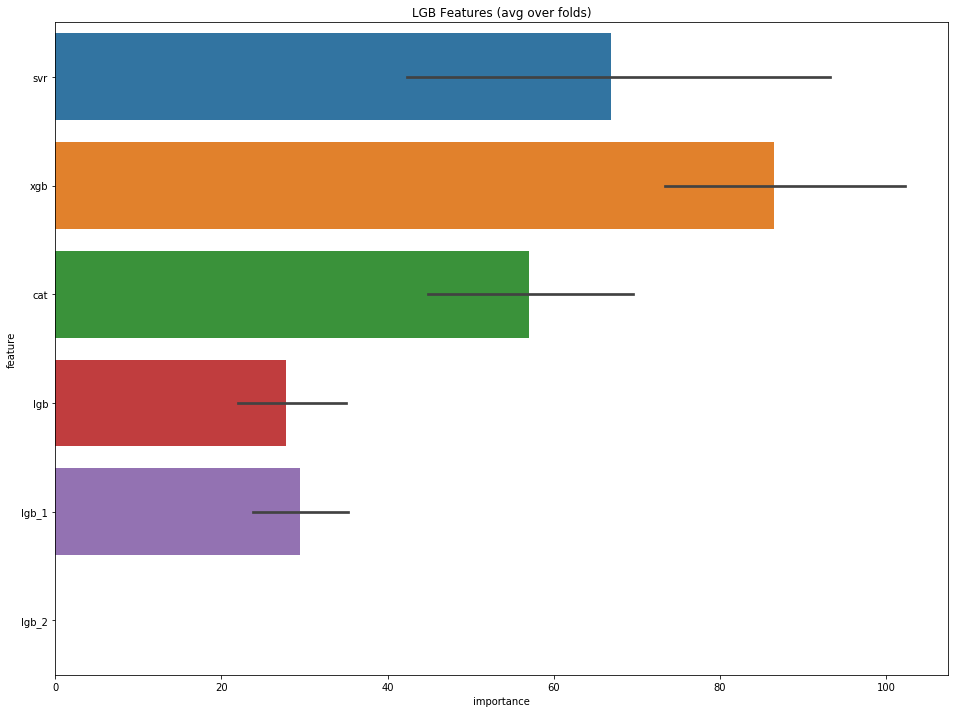

In [47]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [48]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:18:42 2019
Fold 1 started at Tue Dec 17 11:18:56 2019
Fold 2 started at Tue Dec 17 11:19:06 2019
Fold 3 started at Tue Dec 17 11:19:19 2019
Fold 4 started at Tue Dec 17 11:19:33 2019
Fold 5 started at Tue Dec 17 11:19:39 2019
Fold 6 started at Tue Dec 17 11:19:49 2019
Fold 7 started at Tue Dec 17 11:20:00 2019
Fold 8 started at Tue Dec 17 11:20:08 2019
Fold 9 started at Tue Dec 17 11:20:20 2019
CV mean score: 2.8866, std: 0.4837.


##### randomforest作为第二层融合模型

In [49]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:20:29 2019
Fold 1 started at Tue Dec 17 11:20:29 2019
Fold 2 started at Tue Dec 17 11:20:29 2019
Fold 3 started at Tue Dec 17 11:20:29 2019
Fold 4 started at Tue Dec 17 11:20:30 2019
Fold 5 started at Tue Dec 17 11:20:30 2019
Fold 6 started at Tue Dec 17 11:20:30 2019
Fold 7 started at Tue Dec 17 11:20:30 2019
Fold 8 started at Tue Dec 17 11:20:31 2019
Fold 9 started at Tue Dec 17 11:20:31 2019
CV mean score: 2.9147, std: 0.5280.


##### xgboost作为第二层融合模型

In [50]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:20:31 2019
[0]	train-rmse:23.835	valid_data-rmse:21.8392
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25545	valid_data-rmse:2.30763
Stopping. Best iteration:
[695]	train-rmse:0.94294	valid_data-rmse:2.27974

Fold 1 started at Tue Dec 17 11:20:32 2019
[0]	train-rmse:23.7079	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.23263	valid_data-rmse:2.91826
Stopping. Best iteration:
[626]	train-rmse:0.995686	valid_data-rmse:2.9132

Fold 2 started at Tue Dec 17 11:20:32 2019
[0]	train-rmse:23.7737	valid_data-rmse:22.425
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [51]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:20:37 2019
Fold 1 started at Tue Dec 17 11:20:37 2019
Fold 2 started at Tue Dec 17 11:20:37 2019
Fold 3 started at Tue Dec 17 11:20:37 2019
Fold 4 started at Tue Dec 17 11:20:37 2019
Fold 5 started at Tue Dec 17 11:20:37 2019
Fold 6 started at Tue Dec 17 11:20:37 2019
Fold 7 started at Tue Dec 17 11:20:37 2019
Fold 8 started at Tue Dec 17 11:20:37 2019
Fold 9 started at Tue Dec 17 11:20:37 2019
CV mean score: 7.0577, std: 0.7153.


##### 岭回归做第二层融合模型

In [52]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:20:37 2019
Fold 1 started at Tue Dec 17 11:20:37 2019
Fold 2 started at Tue Dec 17 11:20:37 2019
Fold 3 started at Tue Dec 17 11:20:37 2019
Fold 4 started at Tue Dec 17 11:20:38 2019
Fold 5 started at Tue Dec 17 11:20:38 2019
Fold 6 started at Tue Dec 17 11:20:38 2019
Fold 7 started at Tue Dec 17 11:20:38 2019
Fold 8 started at Tue Dec 17 11:20:38 2019
Fold 9 started at Tue Dec 17 11:20:38 2019
CV mean score: 2.8418, std: 0.5073.


#### 去掉catboost的结果

In [53]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:20:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[426]	training's rmse: 2.27916	valid_1's rmse: 2.19045
Fold 1 started at Tue Dec 17 11:20:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[537]	training's rmse: 2.116	valid_1's rmse: 2.62871
Fold 2 started at Tue Dec 17 11:20:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.34818	valid_1's rmse: 2.72927
Fold 3 started at Tue Dec 17 11:20:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[416]	training's rmse: 2.2122	valid_1's rmse: 2.8521
Fold 4 started at Tue Dec 17 11:20:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[194]	training's rmse: 2.58878	valid_1's rmse: 4.18925
Fold 5 started at Tue De

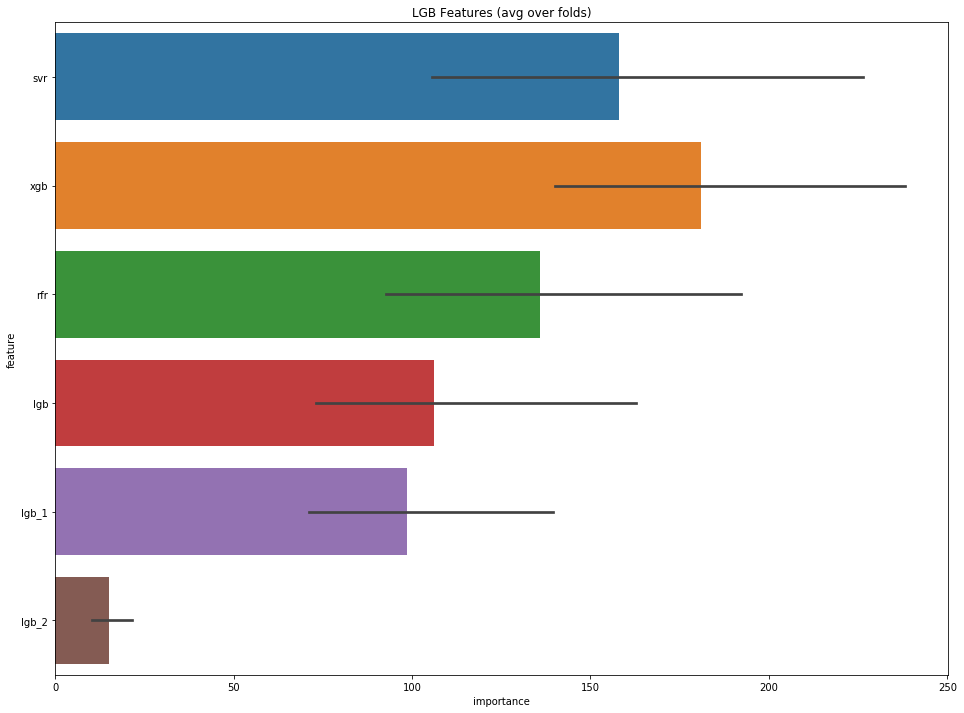

In [54]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:21:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[636]	training's rmse: 2.37629	valid_1's rmse: 2.12836
Fold 1 started at Tue Dec 17 11:21:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[741]	training's rmse: 2.28162	valid_1's rmse: 2.56395
Fold 2 started at Tue Dec 17 11:21:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[369]	training's rmse: 2.43775	valid_1's rmse: 2.76888
Fold 3 started at Tue Dec 17 11:21:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[407]	training's rmse: 2.41083	valid_1's rmse: 2.69967
Fold 4 started at Tue Dec 17 11:21:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[191]	training's rmse: 2.69794	valid_1's rmse: 4.20677
Fold 5 started at Tu

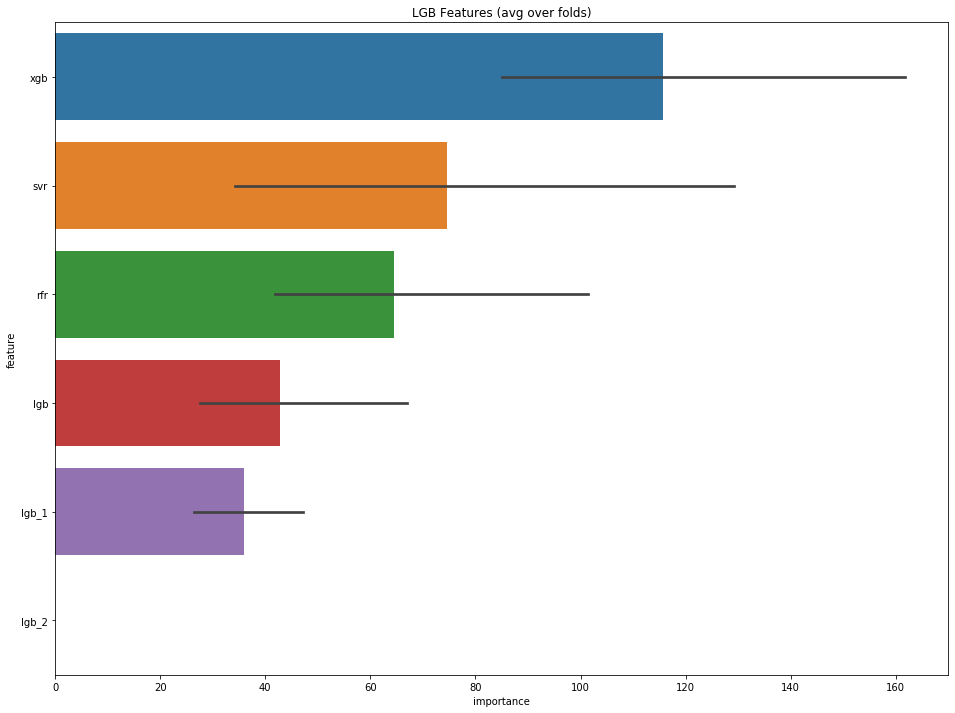

In [55]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [56]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:22:04 2019
Fold 1 started at Tue Dec 17 11:22:19 2019
Fold 2 started at Tue Dec 17 11:22:35 2019
Fold 3 started at Tue Dec 17 11:22:45 2019
Fold 4 started at Tue Dec 17 11:23:01 2019
Fold 5 started at Tue Dec 17 11:23:08 2019
Fold 6 started at Tue Dec 17 11:23:16 2019
Fold 7 started at Tue Dec 17 11:23:28 2019
Fold 8 started at Tue Dec 17 11:23:37 2019
Fold 9 started at Tue Dec 17 11:23:56 2019
CV mean score: 2.9113, std: 0.5528.


##### randomforest作为第二层融合模型

In [57]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:24:10 2019
Fold 1 started at Tue Dec 17 11:24:10 2019
Fold 2 started at Tue Dec 17 11:24:10 2019
Fold 3 started at Tue Dec 17 11:24:11 2019
Fold 4 started at Tue Dec 17 11:24:11 2019
Fold 5 started at Tue Dec 17 11:24:11 2019
Fold 6 started at Tue Dec 17 11:24:11 2019
Fold 7 started at Tue Dec 17 11:24:12 2019
Fold 8 started at Tue Dec 17 11:24:12 2019
Fold 9 started at Tue Dec 17 11:24:12 2019
CV mean score: 3.0097, std: 0.6113.


##### xgboost作为第二层融合模型

In [58]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:24:12 2019
[0]	train-rmse:23.8348	valid_data-rmse:21.8424
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20971	valid_data-rmse:2.23437
Stopping. Best iteration:
[668]	train-rmse:0.950138	valid_data-rmse:2.19596

Fold 1 started at Tue Dec 17 11:24:13 2019
[0]	train-rmse:23.7078	valid_data-rmse:23.0498
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.18724	valid_data-rmse:2.87504
Stopping. Best iteration:
[617]	train-rmse:0.980472	valid_data-rmse:2.86439

Fold 2 started at Tue Dec 17 11:24:14 2019
[0]	train-rmse:23.7743	valid_data-rmse:22.4247
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	trai

##### svr 作为第二层融合模型

In [59]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:24:17 2019
Fold 1 started at Tue Dec 17 11:24:17 2019
Fold 2 started at Tue Dec 17 11:24:17 2019
Fold 3 started at Tue Dec 17 11:24:17 2019
Fold 4 started at Tue Dec 17 11:24:17 2019
Fold 5 started at Tue Dec 17 11:24:17 2019
Fold 6 started at Tue Dec 17 11:24:17 2019
Fold 7 started at Tue Dec 17 11:24:17 2019
Fold 8 started at Tue Dec 17 11:24:17 2019
Fold 9 started at Tue Dec 17 11:24:17 2019
CV mean score: 7.0688, std: 0.7555.


##### 岭回归做第二层融合模型

In [60]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:24:17 2019
Fold 1 started at Tue Dec 17 11:24:17 2019
Fold 2 started at Tue Dec 17 11:24:18 2019
Fold 3 started at Tue Dec 17 11:24:18 2019
Fold 4 started at Tue Dec 17 11:24:18 2019
Fold 5 started at Tue Dec 17 11:24:18 2019
Fold 6 started at Tue Dec 17 11:24:18 2019
Fold 7 started at Tue Dec 17 11:24:18 2019
Fold 8 started at Tue Dec 17 11:24:18 2019
Fold 9 started at Tue Dec 17 11:24:18 2019
CV mean score: 2.8548, std: 0.5869.


#### 去掉xgb和lgb的结果

In [61]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:24:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[582]	training's rmse: 2.30337	valid_1's rmse: 2.04971
Fold 1 started at Tue Dec 17 11:24:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 2.44043	valid_1's rmse: 3.50679
Fold 2 started at Tue Dec 17 11:24:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[372]	training's rmse: 2.45685	valid_1's rmse: 2.68542
Fold 3 started at Tue Dec 17 11:24:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[471]	training's rmse: 2.35067	valid_1's rmse: 2.97095
Fold 4 started at Tue Dec 17 11:24:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.59161	valid_1's rmse: 3.81141
Fold 5 started at Tu

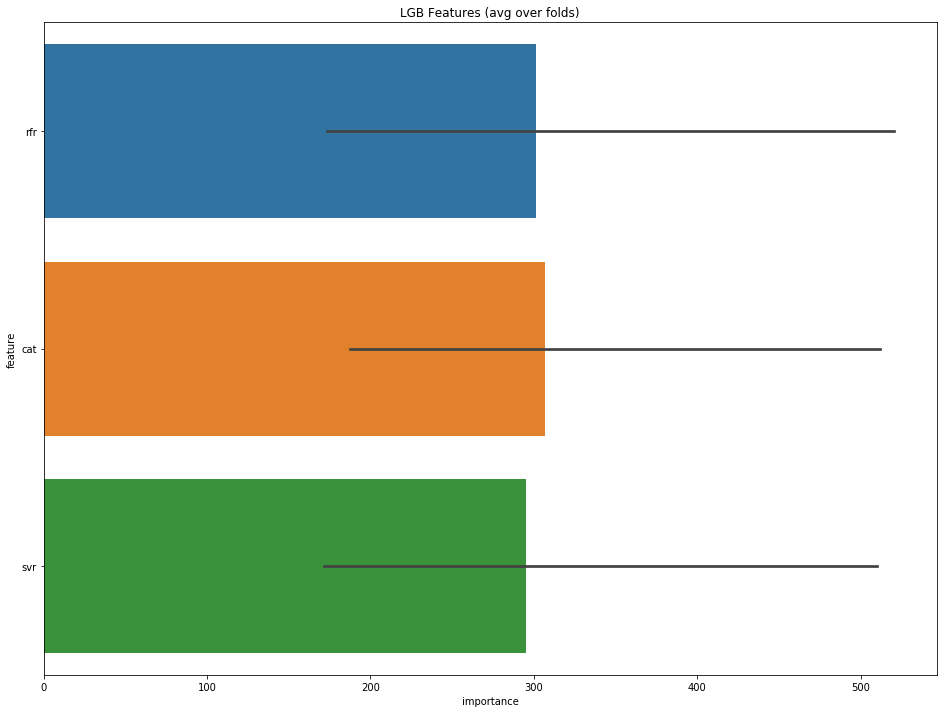

In [62]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:25:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[591]	training's rmse: 2.46067	valid_1's rmse: 2.08722
Fold 1 started at Tue Dec 17 11:25:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[479]	training's rmse: 2.41914	valid_1's rmse: 3.14553
Fold 2 started at Tue Dec 17 11:25:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[380]	training's rmse: 2.51084	valid_1's rmse: 2.66609
Fold 3 started at Tue Dec 17 11:26:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[363]	training's rmse: 2.56345	valid_1's rmse: 2.75861
Fold 4 started at Tue Dec 17 11:26:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[256]	training's rmse: 2.62694	valid_1's rmse: 3.77684
Fold 5 started at Tu

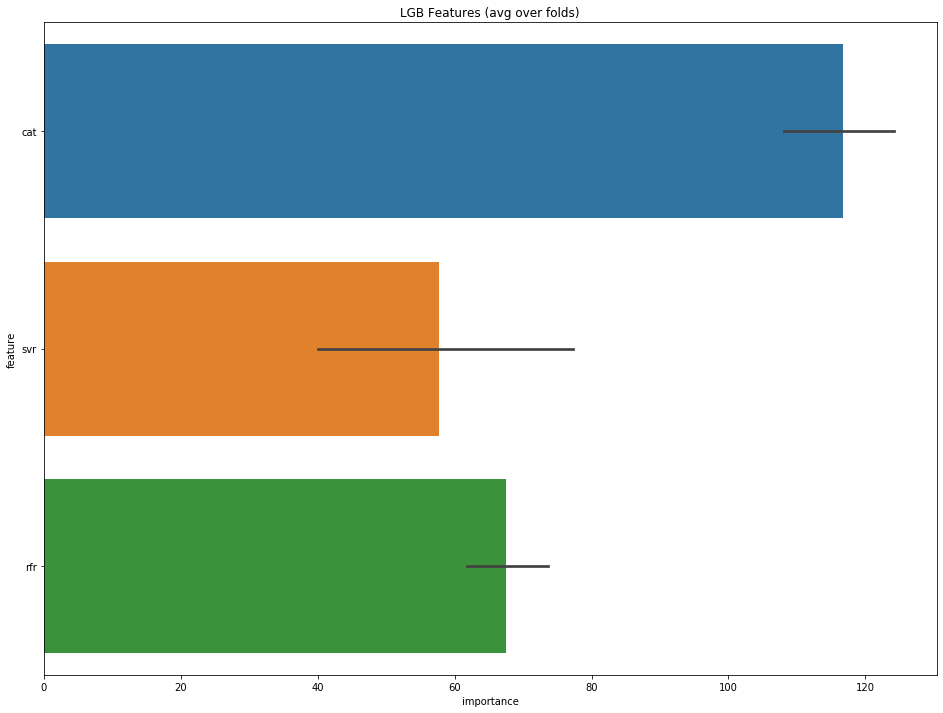

In [63]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [64]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:26:24 2019
Fold 1 started at Tue Dec 17 11:26:36 2019
Fold 2 started at Tue Dec 17 11:27:39 2019
Fold 3 started at Tue Dec 17 11:27:47 2019
Fold 4 started at Tue Dec 17 11:27:59 2019
Fold 5 started at Tue Dec 17 11:28:09 2019
Fold 6 started at Tue Dec 17 11:28:18 2019
Fold 7 started at Tue Dec 17 11:28:28 2019
Fold 8 started at Tue Dec 17 11:28:37 2019
Fold 9 started at Tue Dec 17 11:28:51 2019
CV mean score: 2.9689, std: 0.4452.


##### randomforest作为第二层融合模型

In [65]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:29:04 2019
Fold 1 started at Tue Dec 17 11:29:04 2019
Fold 2 started at Tue Dec 17 11:29:05 2019
Fold 3 started at Tue Dec 17 11:29:05 2019
Fold 4 started at Tue Dec 17 11:29:05 2019
Fold 5 started at Tue Dec 17 11:29:05 2019
Fold 6 started at Tue Dec 17 11:29:05 2019
Fold 7 started at Tue Dec 17 11:29:06 2019
Fold 8 started at Tue Dec 17 11:29:06 2019
Fold 9 started at Tue Dec 17 11:29:06 2019
CV mean score: 3.1130, std: 0.5064.


##### xgboost作为第二层融合模型

In [66]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:29:06 2019
[0]	train-rmse:23.8369	valid_data-rmse:21.838
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.37235	valid_data-rmse:2.31957
Stopping. Best iteration:
[591]	train-rmse:1.18043	valid_data-rmse:2.31542

Fold 1 started at Tue Dec 17 11:29:07 2019
[0]	train-rmse:23.7092	valid_data-rmse:23.0481
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.36444	valid_data-rmse:3.61496
Stopping. Best iteration:
[569]	train-rmse:1.21373	valid_data-rmse:3.58769

Fold 2 started at Tue Dec 17 11:29:07 2019
[0]	train-rmse:23.776	valid_data-rmse:22.4342
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [67]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:29:15 2019
Fold 1 started at Tue Dec 17 11:29:15 2019
Fold 2 started at Tue Dec 17 11:29:15 2019
Fold 3 started at Tue Dec 17 11:29:15 2019
Fold 4 started at Tue Dec 17 11:29:15 2019
Fold 5 started at Tue Dec 17 11:29:15 2019
Fold 6 started at Tue Dec 17 11:29:15 2019
Fold 7 started at Tue Dec 17 11:29:15 2019
Fold 8 started at Tue Dec 17 11:29:15 2019
Fold 9 started at Tue Dec 17 11:29:15 2019
CV mean score: 6.6983, std: 0.7232.


##### 岭回归做第二层融合模型

In [68]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:29:15 2019
Fold 1 started at Tue Dec 17 11:29:15 2019
Fold 2 started at Tue Dec 17 11:29:15 2019
Fold 3 started at Tue Dec 17 11:29:15 2019
Fold 4 started at Tue Dec 17 11:29:15 2019
Fold 5 started at Tue Dec 17 11:29:15 2019
Fold 6 started at Tue Dec 17 11:29:15 2019
Fold 7 started at Tue Dec 17 11:29:16 2019
Fold 8 started at Tue Dec 17 11:29:16 2019
Fold 9 started at Tue Dec 17 11:29:16 2019
CV mean score: 2.9383, std: 0.4715.


#### 去掉lgb和svr的结果

In [69]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:29:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 2.34612	valid_1's rmse: 2.06043
Fold 1 started at Tue Dec 17 11:29:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.12603	valid_1's rmse: 2.72161
Early stopping, best iteration is:
[1698]	training's rmse: 1.95979	valid_1's rmse: 2.69142
Fold 2 started at Tue Dec 17 11:29:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[383]	training's rmse: 2.3745	valid_1's rmse: 2.61948
Fold 3 started at Tue Dec 17 11:29:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[493]	training's rmse: 2.30376	valid_1's rmse: 2.79297
Fold 4 started at Tue Dec 17 11:29:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rm

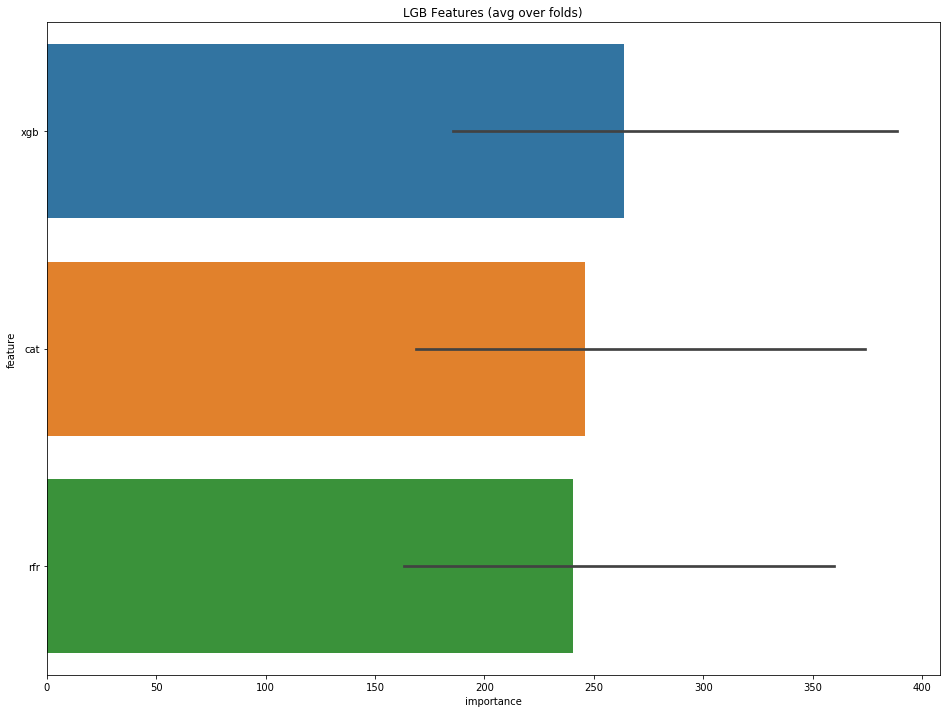

In [70]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:30:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[579]	training's rmse: 2.47789	valid_1's rmse: 2.1221
Fold 1 started at Tue Dec 17 11:30:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.36464	valid_1's rmse: 2.73474
[2000]	training's rmse: 2.26444	valid_1's rmse: 2.67153
Early stopping, best iteration is:
[2491]	training's rmse: 2.22586	valid_1's rmse: 2.63863
Fold 2 started at Tue Dec 17 11:30:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[373]	training's rmse: 2.49152	valid_1's rmse: 2.60297
Fold 3 started at Tue Dec 17 11:30:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[697]	training's rmse: 2.39346	valid_1's rmse: 2.75028
Fold 4 started at Tue Dec 17 11:30:25 2019
Training until validation scores don't improve for 200 rounds

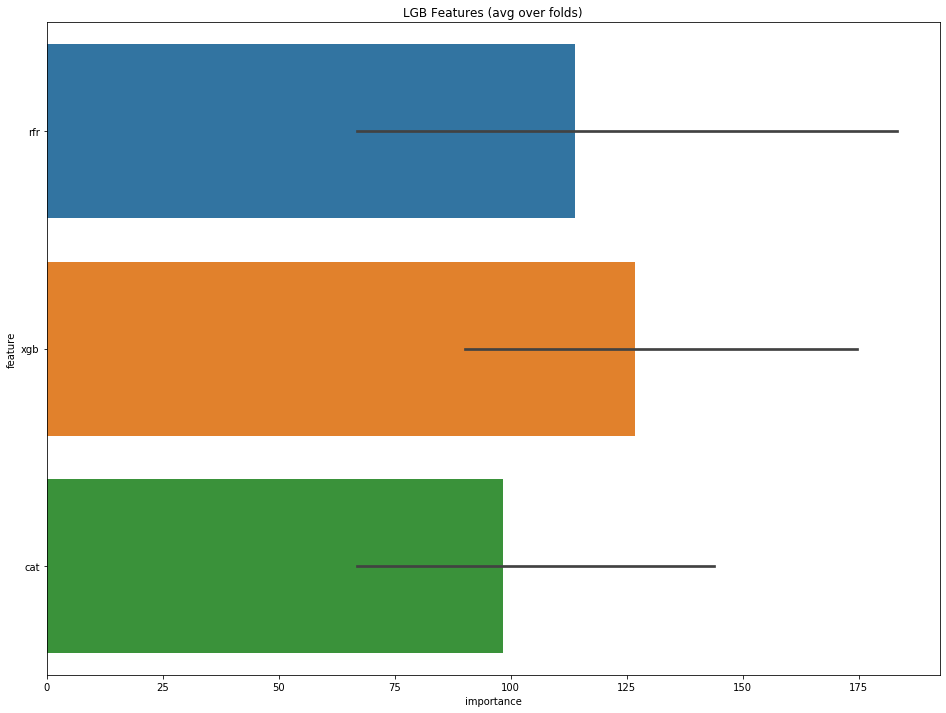

In [71]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [72]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:30:42 2019
Fold 1 started at Tue Dec 17 11:30:58 2019
Fold 2 started at Tue Dec 17 11:32:12 2019
Fold 3 started at Tue Dec 17 11:32:22 2019
Fold 4 started at Tue Dec 17 11:32:35 2019
Fold 5 started at Tue Dec 17 11:32:42 2019
Fold 6 started at Tue Dec 17 11:32:51 2019
Fold 7 started at Tue Dec 17 11:33:02 2019
Fold 8 started at Tue Dec 17 11:33:11 2019
Fold 9 started at Tue Dec 17 11:33:25 2019
CV mean score: 2.8158, std: 0.4848.


##### randomforest作为第二层融合模型

In [73]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:33:34 2019
Fold 1 started at Tue Dec 17 11:33:34 2019
Fold 2 started at Tue Dec 17 11:33:34 2019
Fold 3 started at Tue Dec 17 11:33:35 2019
Fold 4 started at Tue Dec 17 11:33:35 2019
Fold 5 started at Tue Dec 17 11:33:35 2019
Fold 6 started at Tue Dec 17 11:33:35 2019
Fold 7 started at Tue Dec 17 11:33:36 2019
Fold 8 started at Tue Dec 17 11:33:36 2019
Fold 9 started at Tue Dec 17 11:33:36 2019
CV mean score: 2.9250, std: 0.5309.


##### xgboost作为第二层融合模型

In [74]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:33:36 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.84
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.41871	valid_data-rmse:2.28451
Stopping. Best iteration:
[584]	train-rmse:1.28206	valid_data-rmse:2.27771

Fold 1 started at Tue Dec 17 11:33:37 2019
[0]	train-rmse:23.7079	valid_data-rmse:23.0494
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.40061	valid_data-rmse:2.64449
[1000]	train-rmse:0.819127	valid_data-rmse:2.48466
[1500]	train-rmse:0.526099	valid_data-rmse:2.47304
Stopping. Best iteration:
[1762]	train-rmse:0.424242	valid_data-rmse:2.47163

Fold 2 started at Tue Dec 17 11:33:38 2019
[0]	train-rmse:23.7747	valid_data-rmse:22.4236
Multiple eval metrics have been passed: 'valid_data-rmse' will be 

##### svr 作为第二层融合模型

In [75]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:33:40 2019
Fold 1 started at Tue Dec 17 11:33:40 2019
Fold 2 started at Tue Dec 17 11:33:40 2019
Fold 3 started at Tue Dec 17 11:33:40 2019
Fold 4 started at Tue Dec 17 11:33:40 2019
Fold 5 started at Tue Dec 17 11:33:40 2019
Fold 6 started at Tue Dec 17 11:33:40 2019
Fold 7 started at Tue Dec 17 11:33:40 2019
Fold 8 started at Tue Dec 17 11:33:40 2019
Fold 9 started at Tue Dec 17 11:33:40 2019
CV mean score: 7.1395, std: 0.7424.


##### 岭回归做第二层融合模型

In [76]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:33:40 2019
Fold 1 started at Tue Dec 17 11:33:40 2019
Fold 2 started at Tue Dec 17 11:33:41 2019
Fold 3 started at Tue Dec 17 11:33:41 2019
Fold 4 started at Tue Dec 17 11:33:41 2019
Fold 5 started at Tue Dec 17 11:33:41 2019
Fold 6 started at Tue Dec 17 11:33:41 2019
Fold 7 started at Tue Dec 17 11:33:41 2019
Fold 8 started at Tue Dec 17 11:33:41 2019
Fold 9 started at Tue Dec 17 11:33:41 2019
CV mean score: 2.8405, std: 0.5252.


#### 去掉lgb和rfr的结果

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:33:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[457]	training's rmse: 2.3175	valid_1's rmse: 2.145
Fold 1 started at Tue Dec 17 11:33:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[525]	training's rmse: 2.2204	valid_1's rmse: 2.85099
Fold 2 started at Tue Dec 17 11:33:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[287]	training's rmse: 2.43989	valid_1's rmse: 2.80573
Fold 3 started at Tue Dec 17 11:34:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[644]	training's rmse: 2.15731	valid_1's rmse: 2.82905
Fold 4 started at Tue Dec 17 11:34:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.51332	valid_1's rmse: 3.85264
Fold 5 started at Tue De

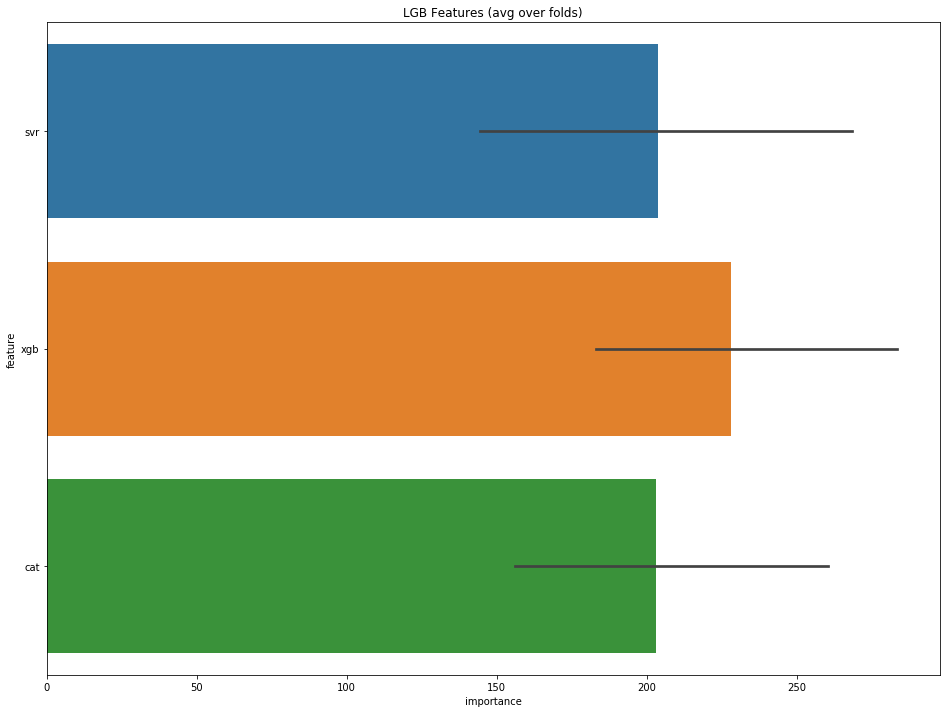

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:34:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[489]	training's rmse: 2.45409	valid_1's rmse: 2.16132
Fold 1 started at Tue Dec 17 11:34:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.5053	valid_1's rmse: 2.9746
Fold 2 started at Tue Dec 17 11:34:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 2.49414	valid_1's rmse: 2.8478
Fold 3 started at Tue Dec 17 11:34:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 2.46795	valid_1's rmse: 2.80634
Fold 4 started at Tue Dec 17 11:34:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[195]	training's rmse: 2.76492	valid_1's rmse: 4.07134
Fold 5 started at Tue D

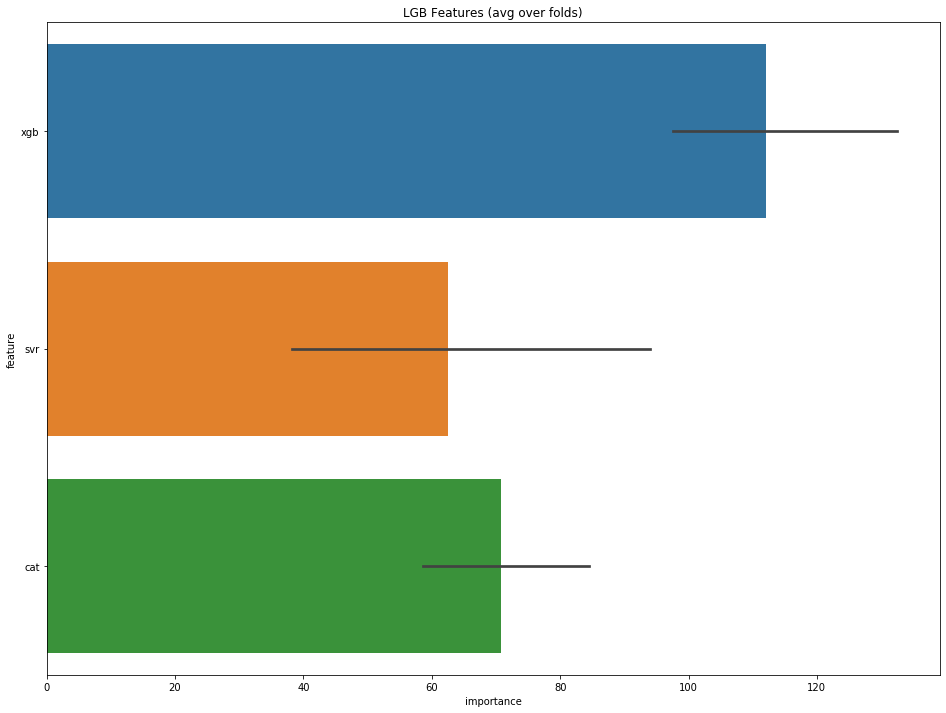

In [79]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [80]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:35:04 2019
Fold 1 started at Tue Dec 17 11:35:17 2019
Fold 2 started at Tue Dec 17 11:35:35 2019
Fold 3 started at Tue Dec 17 11:35:47 2019
Fold 4 started at Tue Dec 17 11:36:04 2019
Fold 5 started at Tue Dec 17 11:36:14 2019
Fold 6 started at Tue Dec 17 11:36:24 2019
Fold 7 started at Tue Dec 17 11:36:38 2019
Fold 8 started at Tue Dec 17 11:36:48 2019
Fold 9 started at Tue Dec 17 11:37:00 2019
CV mean score: 2.7978, std: 0.3693.


##### randomforest作为第二层融合模型

In [81]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:37:09 2019
Fold 1 started at Tue Dec 17 11:37:10 2019
Fold 2 started at Tue Dec 17 11:37:10 2019
Fold 3 started at Tue Dec 17 11:37:10 2019
Fold 4 started at Tue Dec 17 11:37:10 2019
Fold 5 started at Tue Dec 17 11:37:11 2019
Fold 6 started at Tue Dec 17 11:37:11 2019
Fold 7 started at Tue Dec 17 11:37:11 2019
Fold 8 started at Tue Dec 17 11:37:11 2019
Fold 9 started at Tue Dec 17 11:37:12 2019
CV mean score: 2.8491, std: 0.3389.


##### xgboost作为第二层融合模型

In [82]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:37:12 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.841
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.3823	valid_data-rmse:2.28531
Stopping. Best iteration:
[787]	train-rmse:0.955633	valid_data-rmse:2.24478

Fold 1 started at Tue Dec 17 11:37:12 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.36571	valid_data-rmse:2.70503
[1000]	train-rmse:0.756376	valid_data-rmse:2.65098
Stopping. Best iteration:
[930]	train-rmse:0.816678	valid_data-rmse:2.64816

Fold 2 started at Tue Dec 17 11:37:13 2019
[0]	train-rmse:23.7749	valid_data-rmse:22.4239
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_da

##### svr 作为第二层融合模型

In [83]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:37:16 2019
Fold 1 started at Tue Dec 17 11:37:16 2019
Fold 2 started at Tue Dec 17 11:37:16 2019
Fold 3 started at Tue Dec 17 11:37:16 2019
Fold 4 started at Tue Dec 17 11:37:16 2019
Fold 5 started at Tue Dec 17 11:37:16 2019
Fold 6 started at Tue Dec 17 11:37:16 2019
Fold 7 started at Tue Dec 17 11:37:16 2019
Fold 8 started at Tue Dec 17 11:37:16 2019
Fold 9 started at Tue Dec 17 11:37:16 2019
CV mean score: 6.3122, std: 0.6241.


##### 岭回归做第二层融合模型

In [84]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:37:16 2019
Fold 1 started at Tue Dec 17 11:37:16 2019
Fold 2 started at Tue Dec 17 11:37:16 2019
Fold 3 started at Tue Dec 17 11:37:17 2019
Fold 4 started at Tue Dec 17 11:37:17 2019
Fold 5 started at Tue Dec 17 11:37:17 2019
Fold 6 started at Tue Dec 17 11:37:17 2019
Fold 7 started at Tue Dec 17 11:37:17 2019
Fold 8 started at Tue Dec 17 11:37:17 2019
Fold 9 started at Tue Dec 17 11:37:17 2019
CV mean score: 2.8104, std: 0.4875.


#### 去掉lgb和cat的结果

In [85]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:37:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 2.44212	valid_1's rmse: 2.09722
Fold 1 started at Tue Dec 17 11:37:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.01739	valid_1's rmse: 2.77566
Early stopping, best iteration is:
[1196]	training's rmse: 1.93326	valid_1's rmse: 2.7516
Fold 2 started at Tue Dec 17 11:37:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's rmse: 2.47236	valid_1's rmse: 2.69509
Fold 3 started at Tue Dec 17 11:37:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[410]	training's rmse: 2.36049	valid_1's rmse: 2.87782
Fold 4 started at Tue Dec 17 11:37:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[198]	training's rm

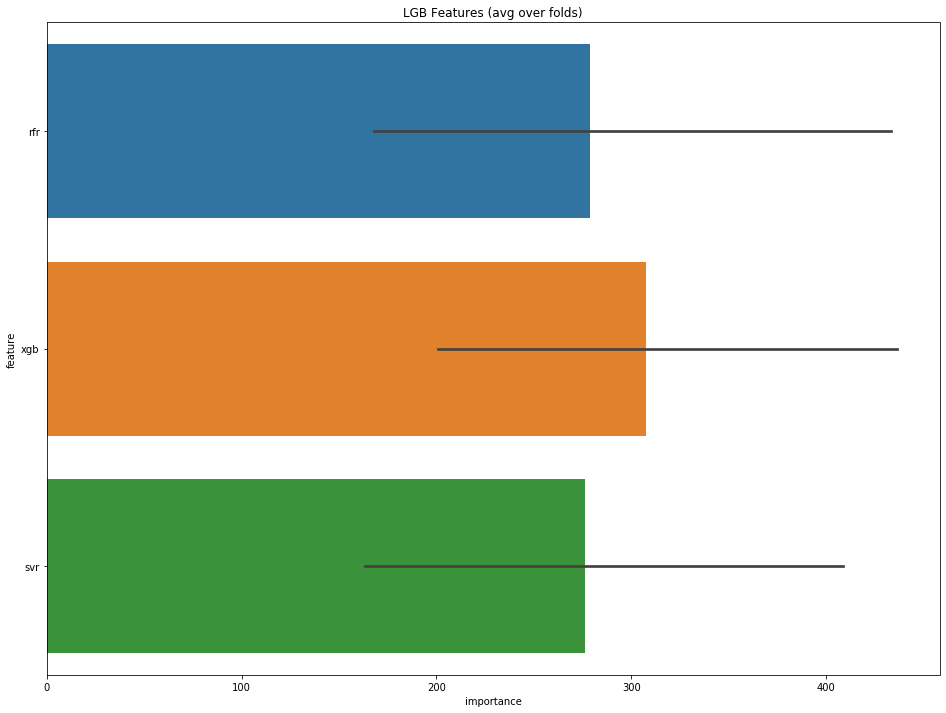

In [86]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:38:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[574]	training's rmse: 2.44364	valid_1's rmse: 2.07499
Fold 1 started at Tue Dec 17 11:38:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[380]	training's rmse: 2.48352	valid_1's rmse: 2.57816
Fold 2 started at Tue Dec 17 11:38:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[379]	training's rmse: 2.47999	valid_1's rmse: 2.74203
Fold 3 started at Tue Dec 17 11:39:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's rmse: 2.43803	valid_1's rmse: 2.63217
Fold 4 started at Tue Dec 17 11:39:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 2.61234	valid_1's rmse: 4.06575
Fold 5 started at Tu

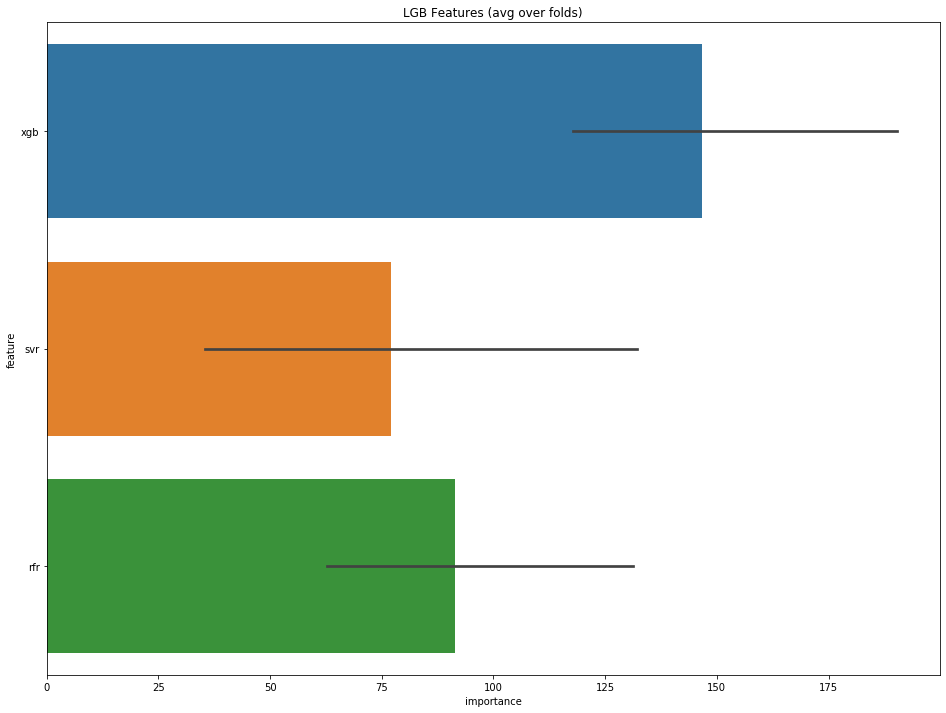

In [87]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [88]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:39:26 2019
Fold 1 started at Tue Dec 17 11:39:48 2019
Fold 2 started at Tue Dec 17 11:40:40 2019
Fold 3 started at Tue Dec 17 11:40:51 2019
Fold 4 started at Tue Dec 17 11:41:15 2019
Fold 5 started at Tue Dec 17 11:41:23 2019
Fold 6 started at Tue Dec 17 11:41:32 2019
Fold 7 started at Tue Dec 17 11:41:43 2019
Fold 8 started at Tue Dec 17 11:41:53 2019
Fold 9 started at Tue Dec 17 11:42:04 2019
CV mean score: 2.8367, std: 0.4905.


##### randomforest作为第二层融合模型

In [89]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:42:17 2019
Fold 1 started at Tue Dec 17 11:42:17 2019
Fold 2 started at Tue Dec 17 11:42:18 2019
Fold 3 started at Tue Dec 17 11:42:18 2019
Fold 4 started at Tue Dec 17 11:42:18 2019
Fold 5 started at Tue Dec 17 11:42:18 2019
Fold 6 started at Tue Dec 17 11:42:19 2019
Fold 7 started at Tue Dec 17 11:42:19 2019
Fold 8 started at Tue Dec 17 11:42:19 2019
Fold 9 started at Tue Dec 17 11:42:19 2019
CV mean score: 3.0286, std: 0.4546.


##### xgboost作为第二层融合模型

In [90]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:42:20 2019
[0]	train-rmse:23.8369	valid_data-rmse:21.838
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.35951	valid_data-rmse:2.12626
Stopping. Best iteration:
[509]	train-rmse:1.33838	valid_data-rmse:2.12047

Fold 1 started at Tue Dec 17 11:42:20 2019
[0]	train-rmse:23.7092	valid_data-rmse:23.0481
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.33353	valid_data-rmse:3.05038
Stopping. Best iteration:
[732]	train-rmse:0.944479	valid_data-rmse:2.98045

Fold 2 started at Tue Dec 17 11:42:20 2019
[0]	train-rmse:23.776	valid_data-rmse:22.4342
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [91]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:42:25 2019
Fold 1 started at Tue Dec 17 11:42:25 2019
Fold 2 started at Tue Dec 17 11:42:25 2019
Fold 3 started at Tue Dec 17 11:42:25 2019
Fold 4 started at Tue Dec 17 11:42:25 2019
Fold 5 started at Tue Dec 17 11:42:25 2019
Fold 6 started at Tue Dec 17 11:42:25 2019
Fold 7 started at Tue Dec 17 11:42:26 2019
Fold 8 started at Tue Dec 17 11:42:26 2019
Fold 9 started at Tue Dec 17 11:42:26 2019
CV mean score: 6.6958, std: 0.6675.


##### 岭回归做第二层融合模型

In [92]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:42:26 2019
Fold 1 started at Tue Dec 17 11:42:26 2019
Fold 2 started at Tue Dec 17 11:42:26 2019
Fold 3 started at Tue Dec 17 11:42:26 2019
Fold 4 started at Tue Dec 17 11:42:26 2019
Fold 5 started at Tue Dec 17 11:42:26 2019
Fold 6 started at Tue Dec 17 11:42:26 2019
Fold 7 started at Tue Dec 17 11:42:26 2019
Fold 8 started at Tue Dec 17 11:42:26 2019
Fold 9 started at Tue Dec 17 11:42:27 2019
CV mean score: 2.8372, std: 0.5565.


#### 去掉xgb和svr

In [93]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:42:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 2.45288	valid_1's rmse: 2.25429
Fold 1 started at Tue Dec 17 11:42:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[426]	training's rmse: 2.3213	valid_1's rmse: 3.26499
Fold 2 started at Tue Dec 17 11:42:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[330]	training's rmse: 2.48996	valid_1's rmse: 2.75846
Fold 3 started at Tue Dec 17 11:42:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 2.42359	valid_1's rmse: 3.01739
Fold 4 started at Tue Dec 17 11:42:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's rmse: 2.59446	valid_1's rmse: 4.11837
Fold 5 started at Tue

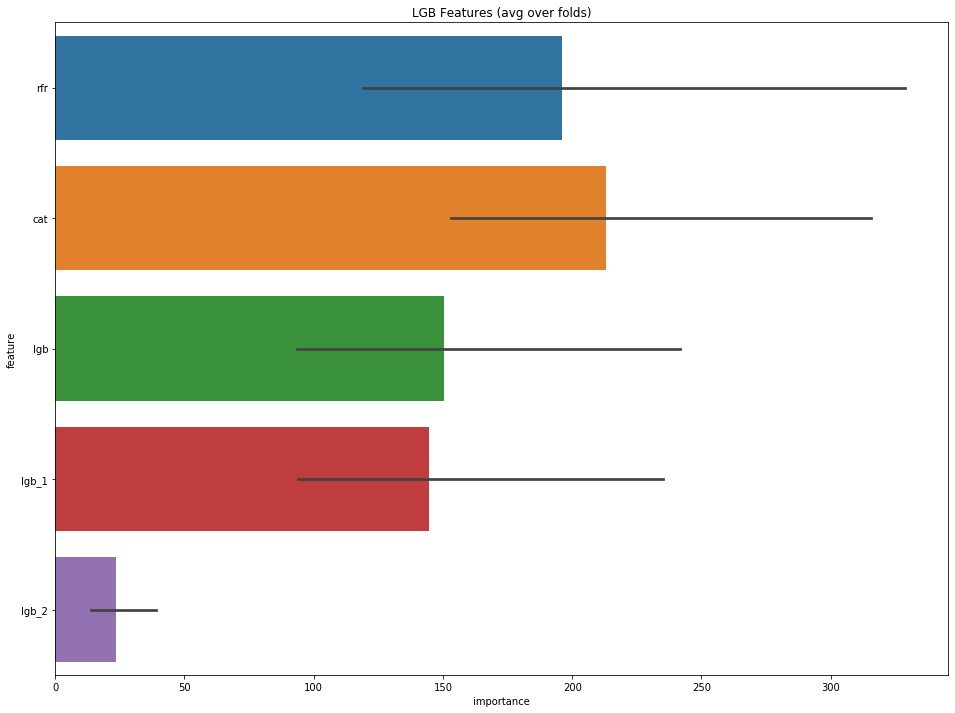

In [94]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:43:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 2.50471	valid_1's rmse: 2.19583
Fold 1 started at Tue Dec 17 11:44:01 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.34826	valid_1's rmse: 3.13928
[2000]	training's rmse: 2.23298	valid_1's rmse: 3.10579
Early stopping, best iteration is:
[1819]	training's rmse: 2.25067	valid_1's rmse: 3.10311
Fold 2 started at Tue Dec 17 11:44:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[649]	training's rmse: 2.44154	valid_1's rmse: 2.73257
Fold 3 started at Tue Dec 17 11:44:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 2.52321	valid_1's rmse: 2.94959
Fold 4 started at Tue Dec 17 11:44:16 2019
Training until validation scores don't improve for 200 round

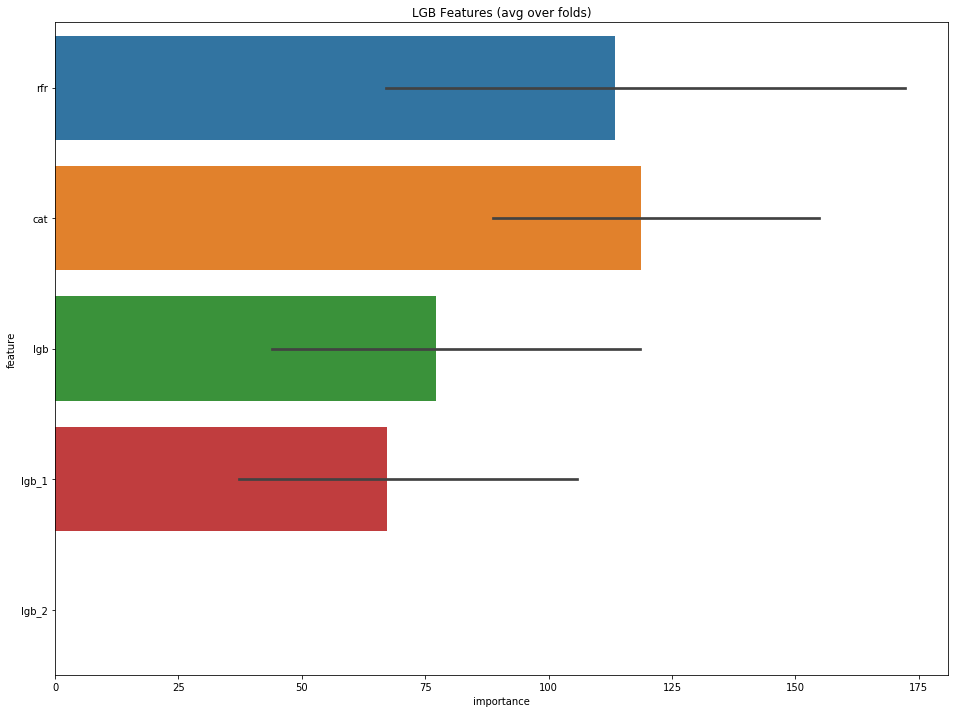

In [95]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [96]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:44:46 2019
Fold 1 started at Tue Dec 17 11:45:02 2019
Fold 2 started at Tue Dec 17 11:45:14 2019
Fold 3 started at Tue Dec 17 11:45:25 2019
Fold 4 started at Tue Dec 17 11:45:40 2019
Fold 5 started at Tue Dec 17 11:45:46 2019
Fold 6 started at Tue Dec 17 11:45:54 2019
Fold 7 started at Tue Dec 17 11:46:06 2019
Fold 8 started at Tue Dec 17 11:46:15 2019
Fold 9 started at Tue Dec 17 11:46:31 2019
CV mean score: 2.9735, std: 0.5775.


##### randomforest作为第二层融合模型

In [97]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:46:42 2019
Fold 1 started at Tue Dec 17 11:46:42 2019
Fold 2 started at Tue Dec 17 11:46:42 2019
Fold 3 started at Tue Dec 17 11:46:43 2019
Fold 4 started at Tue Dec 17 11:46:43 2019
Fold 5 started at Tue Dec 17 11:46:43 2019
Fold 6 started at Tue Dec 17 11:46:43 2019
Fold 7 started at Tue Dec 17 11:46:44 2019
Fold 8 started at Tue Dec 17 11:46:44 2019
Fold 9 started at Tue Dec 17 11:46:44 2019
CV mean score: 2.9840, std: 0.5934.


##### xgboost作为第二层融合模型

In [98]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:46:44 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.8396
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.33461	valid_data-rmse:2.4503
Stopping. Best iteration:
[476]	train-rmse:1.39216	valid_data-rmse:2.44852

Fold 1 started at Tue Dec 17 11:46:45 2019
[0]	train-rmse:23.7074	valid_data-rmse:23.0477
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.323	valid_data-rmse:3.42963
Stopping. Best iteration:
[530]	train-rmse:1.2659	valid_data-rmse:3.41671

Fold 2 started at Tue Dec 17 11:46:45 2019
[0]	train-rmse:23.7749	valid_data-rmse:22.4292
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse

##### svr 作为第二层融合模型

In [99]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:46:49 2019
Fold 1 started at Tue Dec 17 11:46:49 2019
Fold 2 started at Tue Dec 17 11:46:49 2019
Fold 3 started at Tue Dec 17 11:46:49 2019
Fold 4 started at Tue Dec 17 11:46:49 2019
Fold 5 started at Tue Dec 17 11:46:49 2019
Fold 6 started at Tue Dec 17 11:46:49 2019
Fold 7 started at Tue Dec 17 11:46:49 2019
Fold 8 started at Tue Dec 17 11:46:49 2019
Fold 9 started at Tue Dec 17 11:46:49 2019
CV mean score: 7.2637, std: 0.7880.


##### 岭回归做第二层融合模型

In [100]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:46:49 2019
Fold 1 started at Tue Dec 17 11:46:49 2019
Fold 2 started at Tue Dec 17 11:46:49 2019
Fold 3 started at Tue Dec 17 11:46:49 2019
Fold 4 started at Tue Dec 17 11:46:49 2019
Fold 5 started at Tue Dec 17 11:46:49 2019
Fold 6 started at Tue Dec 17 11:46:49 2019
Fold 7 started at Tue Dec 17 11:46:50 2019
Fold 8 started at Tue Dec 17 11:46:50 2019
Fold 9 started at Tue Dec 17 11:46:50 2019
CV mean score: 2.9244, std: 0.5445.


#### 去掉xgb和rfr

In [101]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:46:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[457]	training's rmse: 2.32353	valid_1's rmse: 2.28455
Fold 1 started at Tue Dec 17 11:46:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	training's rmse: 2.35944	valid_1's rmse: 3.34741
Fold 2 started at Tue Dec 17 11:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 2.53765	valid_1's rmse: 2.88727
Fold 3 started at Tue Dec 17 11:47:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.33718	valid_1's rmse: 3.0975
Fold 4 started at Tue Dec 17 11:47:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[211]	training's rmse: 2.65193	valid_1's rmse: 4.1658
Fold 5 started at Tue 

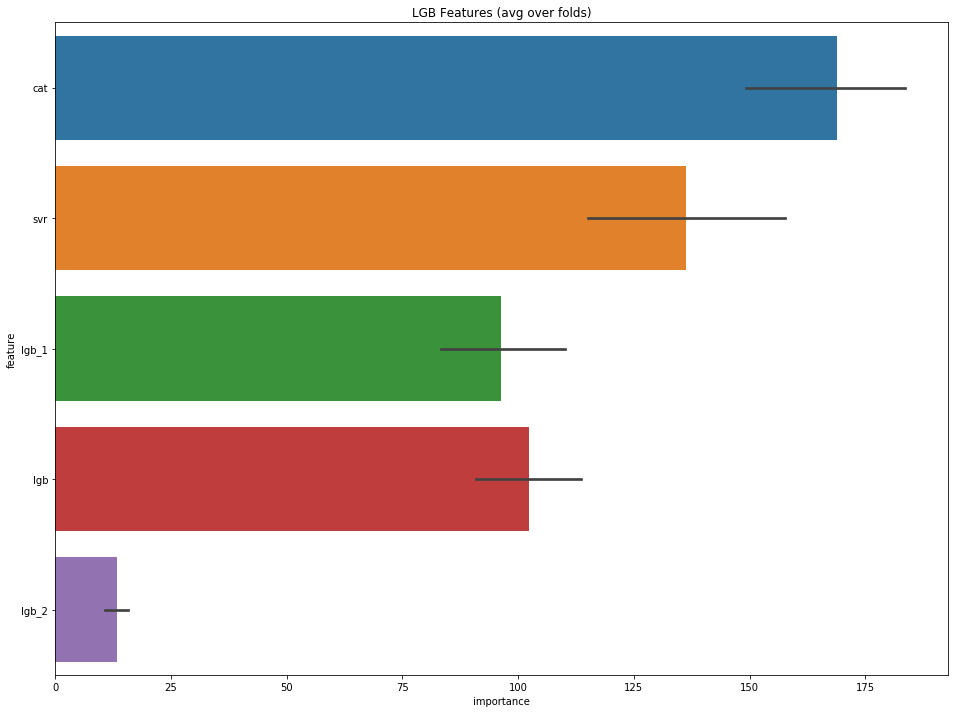

In [102]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:48:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[618]	training's rmse: 2.43231	valid_1's rmse: 2.25682
Fold 1 started at Tue Dec 17 11:48:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[384]	training's rmse: 2.46773	valid_1's rmse: 3.27998
Fold 2 started at Tue Dec 17 11:48:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 2.58131	valid_1's rmse: 2.88756
Fold 3 started at Tue Dec 17 11:48:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[403]	training's rmse: 2.50921	valid_1's rmse: 3.05184
Fold 4 started at Tue Dec 17 11:48:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 2.69986	valid_1's rmse: 4.21994
Fold 5 started at Tu

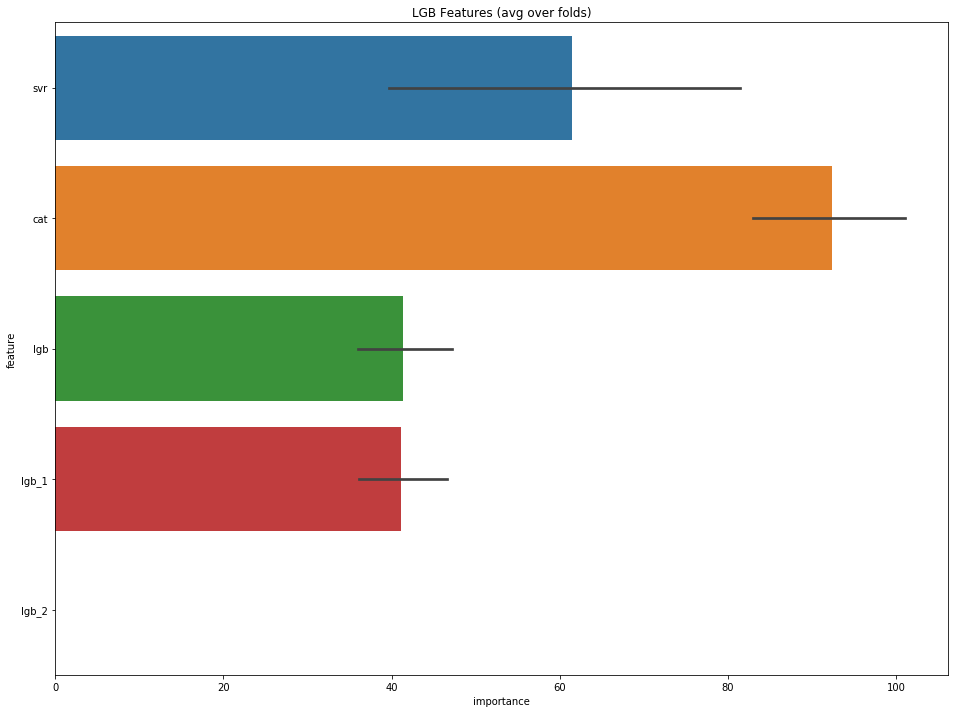

In [103]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [104]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:48:46 2019
Fold 1 started at Tue Dec 17 11:48:58 2019
Fold 2 started at Tue Dec 17 11:49:07 2019
Fold 3 started at Tue Dec 17 11:49:16 2019
Fold 4 started at Tue Dec 17 11:49:28 2019
Fold 5 started at Tue Dec 17 11:49:35 2019
Fold 6 started at Tue Dec 17 11:49:45 2019
Fold 7 started at Tue Dec 17 11:49:55 2019
Fold 8 started at Tue Dec 17 11:50:04 2019
Fold 9 started at Tue Dec 17 11:50:15 2019
CV mean score: 2.9705, std: 0.5118.


##### randomforest作为第二层融合模型

In [105]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:50:26 2019
Fold 1 started at Tue Dec 17 11:50:26 2019
Fold 2 started at Tue Dec 17 11:50:26 2019
Fold 3 started at Tue Dec 17 11:50:26 2019
Fold 4 started at Tue Dec 17 11:50:27 2019
Fold 5 started at Tue Dec 17 11:50:27 2019
Fold 6 started at Tue Dec 17 11:50:27 2019
Fold 7 started at Tue Dec 17 11:50:27 2019
Fold 8 started at Tue Dec 17 11:50:28 2019
Fold 9 started at Tue Dec 17 11:50:28 2019
CV mean score: 2.9956, std: 0.5167.


##### xgboost作为第二层融合模型

In [106]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:50:28 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.8396
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.31176	valid_data-rmse:2.40765
Stopping. Best iteration:
[560]	train-rmse:1.1863	valid_data-rmse:2.39816

Fold 1 started at Tue Dec 17 11:50:29 2019
[0]	train-rmse:23.7074	valid_data-rmse:23.0477
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.29959	valid_data-rmse:3.46978
Stopping. Best iteration:
[504]	train-rmse:1.28784	valid_data-rmse:3.46853

Fold 2 started at Tue Dec 17 11:50:29 2019
[0]	train-rmse:23.7749	valid_data-rmse:22.4292
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [107]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:50:33 2019
Fold 1 started at Tue Dec 17 11:50:33 2019
Fold 2 started at Tue Dec 17 11:50:33 2019
Fold 3 started at Tue Dec 17 11:50:33 2019
Fold 4 started at Tue Dec 17 11:50:33 2019
Fold 5 started at Tue Dec 17 11:50:33 2019
Fold 6 started at Tue Dec 17 11:50:33 2019
Fold 7 started at Tue Dec 17 11:50:33 2019
Fold 8 started at Tue Dec 17 11:50:33 2019
Fold 9 started at Tue Dec 17 11:50:33 2019
CV mean score: 6.8370, std: 0.6641.


##### 岭回归做第二层融合模型

In [108]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:50:33 2019
Fold 1 started at Tue Dec 17 11:50:33 2019
Fold 2 started at Tue Dec 17 11:50:33 2019
Fold 3 started at Tue Dec 17 11:50:33 2019
Fold 4 started at Tue Dec 17 11:50:33 2019
Fold 5 started at Tue Dec 17 11:50:33 2019
Fold 6 started at Tue Dec 17 11:50:34 2019
Fold 7 started at Tue Dec 17 11:50:34 2019
Fold 8 started at Tue Dec 17 11:50:34 2019
Fold 9 started at Tue Dec 17 11:50:34 2019
CV mean score: 2.8925, std: 0.5070.


#### 去掉xgb和cat

In [109]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:50:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[458]	training's rmse: 2.48378	valid_1's rmse: 2.25509
Fold 1 started at Tue Dec 17 11:50:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.43475	valid_1's rmse: 3.26724
Fold 2 started at Tue Dec 17 11:50:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[353]	training's rmse: 2.54178	valid_1's rmse: 2.70819
Fold 3 started at Tue Dec 17 11:50:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[465]	training's rmse: 2.41277	valid_1's rmse: 3.05245
Fold 4 started at Tue Dec 17 11:51:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[194]	training's rmse: 2.805	valid_1's rmse: 4.33824
Fold 5 started at Tue 

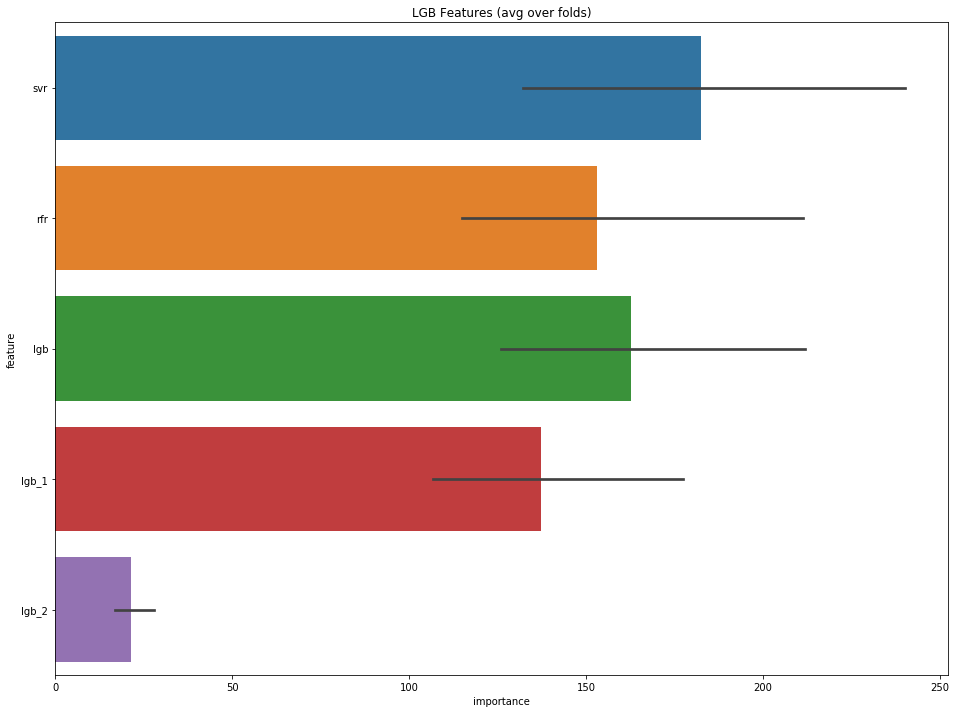

In [110]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:52:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.44602	valid_1's rmse: 2.21687
Early stopping, best iteration is:
[825]	training's rmse: 2.50492	valid_1's rmse: 2.21238
Fold 1 started at Tue Dec 17 11:52:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.33981	valid_1's rmse: 3.28665
[2000]	training's rmse: 2.11798	valid_1's rmse: 3.17397
Early stopping, best iteration is:
[2559]	training's rmse: 2.01596	valid_1's rmse: 3.15166
Fold 2 started at Tue Dec 17 11:52:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[674]	training's rmse: 2.47291	valid_1's rmse: 2.70159
Fold 3 started at Tue Dec 17 11:52:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[544]	training's rmse: 2.5551	valid_1's rmse: 2.96823
Fold 4 started at Tue Dec 17 11:52:34 2019
Train

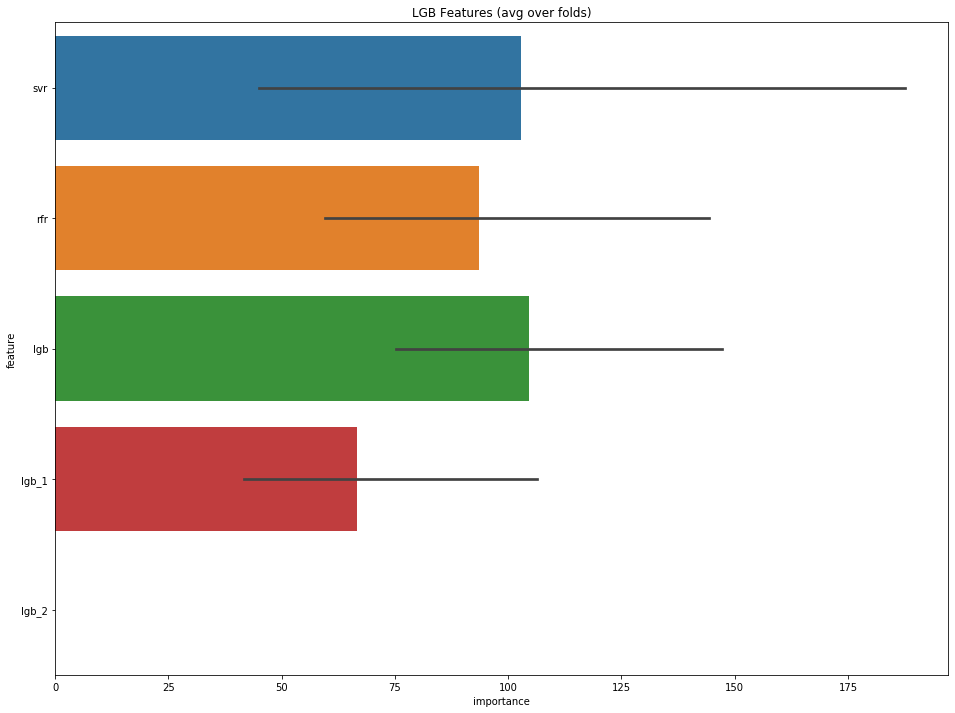

In [111]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [112]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:52:56 2019
Fold 1 started at Tue Dec 17 11:53:13 2019
Fold 2 started at Tue Dec 17 11:53:23 2019
Fold 3 started at Tue Dec 17 11:53:34 2019
Fold 4 started at Tue Dec 17 11:54:05 2019
Fold 5 started at Tue Dec 17 11:54:12 2019
Fold 6 started at Tue Dec 17 11:54:19 2019
Fold 7 started at Tue Dec 17 11:54:32 2019
Fold 8 started at Tue Dec 17 11:54:42 2019
Fold 9 started at Tue Dec 17 11:55:05 2019
CV mean score: 3.0458, std: 0.6284.


##### randomforest作为第二层融合模型

In [113]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:55:12 2019
Fold 1 started at Tue Dec 17 11:55:12 2019
Fold 2 started at Tue Dec 17 11:55:12 2019
Fold 3 started at Tue Dec 17 11:55:12 2019
Fold 4 started at Tue Dec 17 11:55:13 2019
Fold 5 started at Tue Dec 17 11:55:13 2019
Fold 6 started at Tue Dec 17 11:55:13 2019
Fold 7 started at Tue Dec 17 11:55:13 2019
Fold 8 started at Tue Dec 17 11:55:13 2019
Fold 9 started at Tue Dec 17 11:55:14 2019
CV mean score: 3.0804, std: 0.5345.


##### xgboost作为第二层融合模型

In [114]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:55:14 2019
[0]	train-rmse:23.8357	valid_data-rmse:21.8409
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.2768	valid_data-rmse:2.42278
Stopping. Best iteration:
[562]	train-rmse:1.1545	valid_data-rmse:2.41446

Fold 1 started at Tue Dec 17 11:55:14 2019
[0]	train-rmse:23.7076	valid_data-rmse:23.0485
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.29495	valid_data-rmse:3.39695
Stopping. Best iteration:
[630]	train-rmse:1.05566	valid_data-rmse:3.37829

Fold 2 started at Tue Dec 17 11:55:15 2019
[0]	train-rmse:23.7742	valid_data-rmse:22.4275
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [115]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:55:19 2019
Fold 1 started at Tue Dec 17 11:55:19 2019
Fold 2 started at Tue Dec 17 11:55:19 2019
Fold 3 started at Tue Dec 17 11:55:19 2019
Fold 4 started at Tue Dec 17 11:55:19 2019
Fold 5 started at Tue Dec 17 11:55:19 2019
Fold 6 started at Tue Dec 17 11:55:19 2019
Fold 7 started at Tue Dec 17 11:55:19 2019
Fold 8 started at Tue Dec 17 11:55:19 2019
Fold 9 started at Tue Dec 17 11:55:19 2019
CV mean score: 6.7481, std: 0.7241.


##### 岭回归做第二层融合模型

In [116]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:55:19 2019
Fold 1 started at Tue Dec 17 11:55:19 2019
Fold 2 started at Tue Dec 17 11:55:19 2019
Fold 3 started at Tue Dec 17 11:55:19 2019
Fold 4 started at Tue Dec 17 11:55:19 2019
Fold 5 started at Tue Dec 17 11:55:19 2019
Fold 6 started at Tue Dec 17 11:55:19 2019
Fold 7 started at Tue Dec 17 11:55:20 2019
Fold 8 started at Tue Dec 17 11:55:20 2019
Fold 9 started at Tue Dec 17 11:55:20 2019
CV mean score: 3.0294, std: 0.7013.


#### 去掉svr和rfr

In [117]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:55:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[405]	training's rmse: 2.40392	valid_1's rmse: 2.34041
Fold 1 started at Tue Dec 17 11:55:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[429]	training's rmse: 2.32457	valid_1's rmse: 2.93915
Fold 2 started at Tue Dec 17 11:55:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[304]	training's rmse: 2.44117	valid_1's rmse: 2.87543
Fold 3 started at Tue Dec 17 11:55:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[743]	training's rmse: 2.20798	valid_1's rmse: 2.92175
Fold 4 started at Tue Dec 17 11:55:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[198]	training's rmse: 2.62214	valid_1's rmse: 4.13301
Fold 5 started at Tu

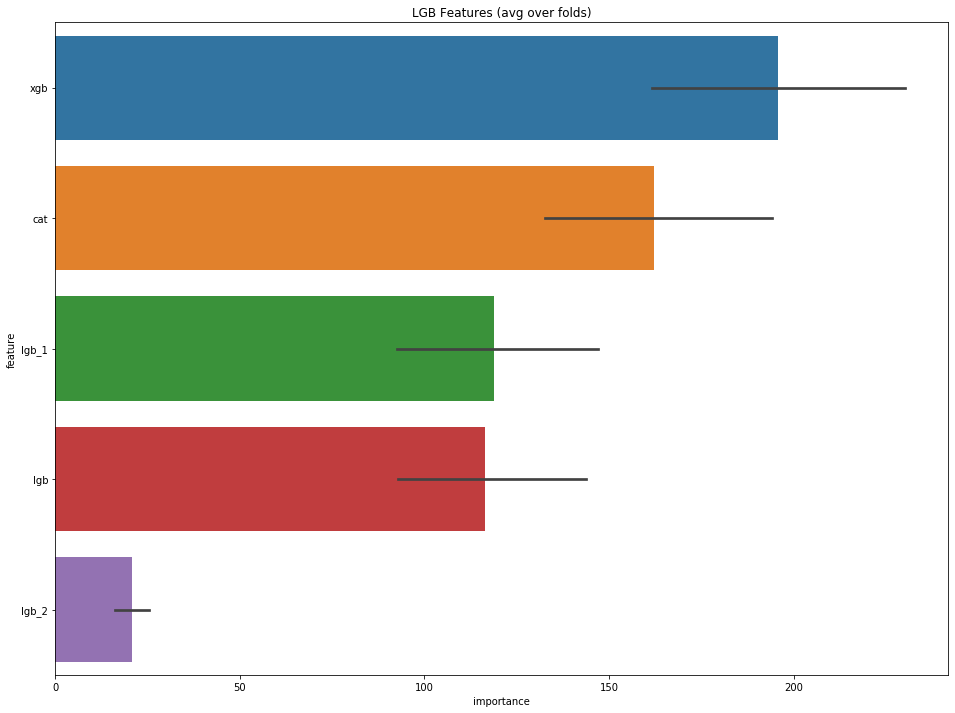

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:56:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[513]	training's rmse: 2.50125	valid_1's rmse: 2.26553
Fold 1 started at Tue Dec 17 11:56:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's rmse: 2.45086	valid_1's rmse: 2.98984
Fold 2 started at Tue Dec 17 11:56:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[365]	training's rmse: 2.49946	valid_1's rmse: 2.82253
Fold 3 started at Tue Dec 17 11:56:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.39568	valid_1's rmse: 2.8784
Early stopping, best iteration is:
[949]	training's rmse: 2.40123	valid_1's rmse: 2.87815
Fold 4 started at Tue Dec 17 11:57:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[199]	training's rms

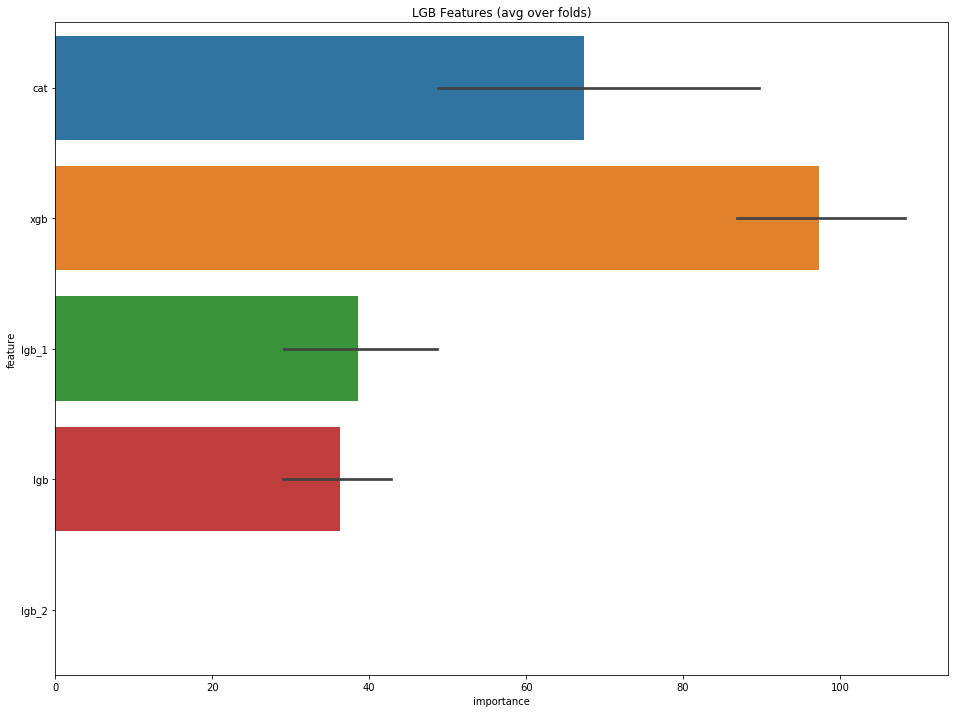

In [119]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [120]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:57:22 2019
Fold 1 started at Tue Dec 17 11:57:34 2019
Fold 2 started at Tue Dec 17 11:57:48 2019
Fold 3 started at Tue Dec 17 11:57:57 2019
Fold 4 started at Tue Dec 17 11:58:07 2019
Fold 5 started at Tue Dec 17 11:58:12 2019
Fold 6 started at Tue Dec 17 11:58:20 2019
Fold 7 started at Tue Dec 17 11:58:30 2019
Fold 8 started at Tue Dec 17 11:58:38 2019
Fold 9 started at Tue Dec 17 11:58:55 2019
CV mean score: 2.8836, std: 0.5179.


##### randomforest作为第二层融合模型

In [121]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:59:04 2019
Fold 1 started at Tue Dec 17 11:59:04 2019
Fold 2 started at Tue Dec 17 11:59:05 2019
Fold 3 started at Tue Dec 17 11:59:05 2019
Fold 4 started at Tue Dec 17 11:59:05 2019
Fold 5 started at Tue Dec 17 11:59:05 2019
Fold 6 started at Tue Dec 17 11:59:06 2019
Fold 7 started at Tue Dec 17 11:59:06 2019
Fold 8 started at Tue Dec 17 11:59:06 2019
Fold 9 started at Tue Dec 17 11:59:06 2019
CV mean score: 2.9638, std: 0.5572.


##### xgboost作为第二层融合模型

In [122]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:59:07 2019
[0]	train-rmse:23.835	valid_data-rmse:21.8392
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.34994	valid_data-rmse:2.37984
Stopping. Best iteration:
[512]	train-rmse:1.32521	valid_data-rmse:2.37632

Fold 1 started at Tue Dec 17 11:59:07 2019
[0]	train-rmse:23.7074	valid_data-rmse:23.0477
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.36918	valid_data-rmse:2.8818
Stopping. Best iteration:
[626]	train-rmse:1.16546	valid_data-rmse:2.84828

Fold 2 started at Tue Dec 17 11:59:08 2019
[0]	train-rmse:23.7744	valid_data-rmse:22.4271
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [123]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:59:11 2019
Fold 1 started at Tue Dec 17 11:59:11 2019
Fold 2 started at Tue Dec 17 11:59:11 2019
Fold 3 started at Tue Dec 17 11:59:11 2019
Fold 4 started at Tue Dec 17 11:59:11 2019
Fold 5 started at Tue Dec 17 11:59:11 2019
Fold 6 started at Tue Dec 17 11:59:11 2019
Fold 7 started at Tue Dec 17 11:59:11 2019
Fold 8 started at Tue Dec 17 11:59:11 2019
Fold 9 started at Tue Dec 17 11:59:11 2019
CV mean score: 7.1252, std: 0.7190.


##### 岭回归做第二层融合模型

In [124]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:59:11 2019
Fold 1 started at Tue Dec 17 11:59:11 2019
Fold 2 started at Tue Dec 17 11:59:11 2019
Fold 3 started at Tue Dec 17 11:59:11 2019
Fold 4 started at Tue Dec 17 11:59:11 2019
Fold 5 started at Tue Dec 17 11:59:12 2019
Fold 6 started at Tue Dec 17 11:59:12 2019
Fold 7 started at Tue Dec 17 11:59:12 2019
Fold 8 started at Tue Dec 17 11:59:12 2019
Fold 9 started at Tue Dec 17 11:59:12 2019
CV mean score: 2.8415, std: 0.5074.


#### 去掉svr和cat

In [125]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:59:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[411]	training's rmse: 2.42016	valid_1's rmse: 2.2734
Fold 1 started at Tue Dec 17 11:59:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[484]	training's rmse: 2.29548	valid_1's rmse: 2.60373
Fold 2 started at Tue Dec 17 11:59:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 2.4118	valid_1's rmse: 2.7594
Fold 3 started at Tue Dec 17 11:59:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[410]	training's rmse: 2.33813	valid_1's rmse: 2.862
Fold 4 started at Tue Dec 17 11:59:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[198]	training's rmse: 2.5945	valid_1's rmse: 4.15368
Fold 5 started at Tue Dec 

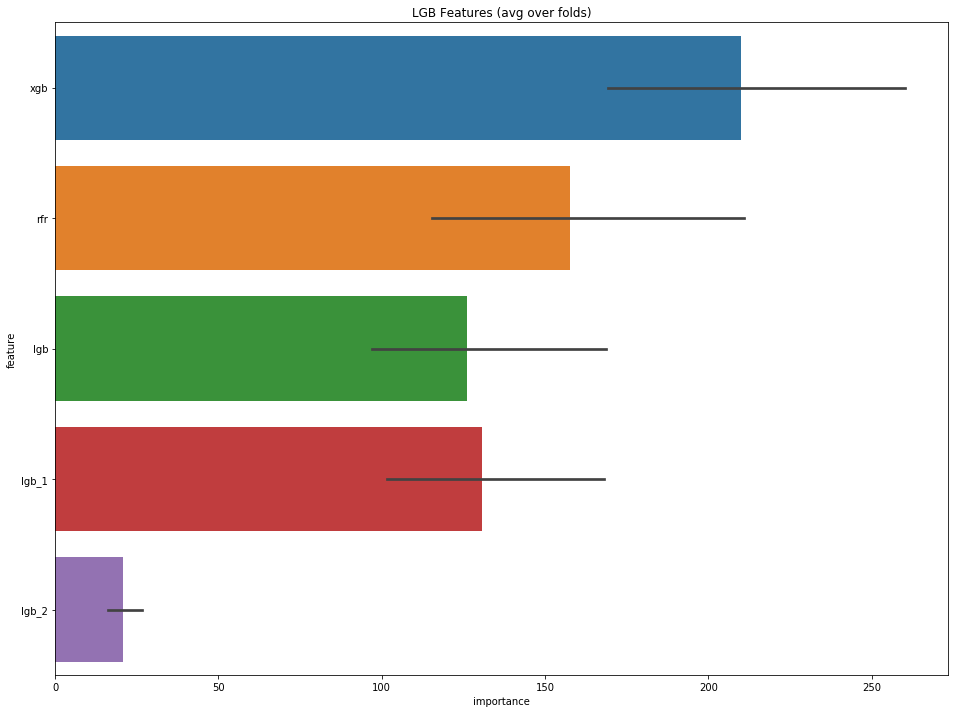

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:00:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[595]	training's rmse: 2.50256	valid_1's rmse: 2.15186
Fold 1 started at Tue Dec 17 12:00:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.34137	valid_1's rmse: 2.43903
Early stopping, best iteration is:
[1038]	training's rmse: 2.33473	valid_1's rmse: 2.43623
Fold 2 started at Tue Dec 17 12:00:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[437]	training's rmse: 2.49069	valid_1's rmse: 2.8031
Fold 3 started at Tue Dec 17 12:00:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[592]	training's rmse: 2.38773	valid_1's rmse: 2.71466
Fold 4 started at Tue Dec 17 12:00:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[209]	training's rm

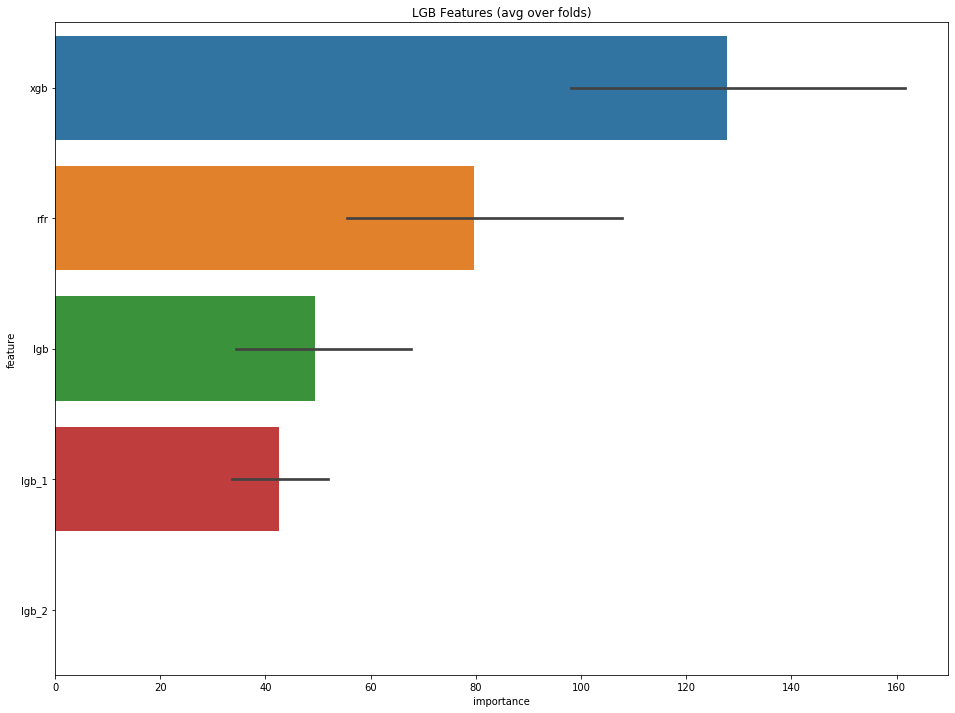

In [127]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [128]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:01:32 2019
Fold 1 started at Tue Dec 17 12:01:46 2019
Fold 2 started at Tue Dec 17 12:01:56 2019
Fold 3 started at Tue Dec 17 12:02:07 2019
Fold 4 started at Tue Dec 17 12:02:23 2019
Fold 5 started at Tue Dec 17 12:02:29 2019
Fold 6 started at Tue Dec 17 12:02:37 2019
Fold 7 started at Tue Dec 17 12:02:51 2019
Fold 8 started at Tue Dec 17 12:03:01 2019
Fold 9 started at Tue Dec 17 12:03:24 2019
CV mean score: 2.8701, std: 0.5457.


##### randomforest作为第二层融合模型

In [129]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:04:27 2019
Fold 1 started at Tue Dec 17 12:04:28 2019
Fold 2 started at Tue Dec 17 12:04:28 2019
Fold 3 started at Tue Dec 17 12:04:28 2019
Fold 4 started at Tue Dec 17 12:04:28 2019
Fold 5 started at Tue Dec 17 12:04:29 2019
Fold 6 started at Tue Dec 17 12:04:29 2019
Fold 7 started at Tue Dec 17 12:04:29 2019
Fold 8 started at Tue Dec 17 12:04:29 2019
Fold 9 started at Tue Dec 17 12:04:29 2019
CV mean score: 2.9691, std: 0.5962.


##### xgboost作为第二层融合模型

In [130]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:04:30 2019
[0]	train-rmse:23.835	valid_data-rmse:21.8414
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.30216	valid_data-rmse:2.2952
Stopping. Best iteration:
[692]	train-rmse:1.03917	valid_data-rmse:2.27124

Fold 1 started at Tue Dec 17 12:04:30 2019
[0]	train-rmse:23.708	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.28079	valid_data-rmse:2.90971
Stopping. Best iteration:
[637]	train-rmse:1.06698	valid_data-rmse:2.88541

Fold 2 started at Tue Dec 17 12:04:31 2019
[0]	train-rmse:23.7743	valid_data-rmse:22.4263
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [131]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:04:35 2019
Fold 1 started at Tue Dec 17 12:04:35 2019
Fold 2 started at Tue Dec 17 12:04:35 2019
Fold 3 started at Tue Dec 17 12:04:35 2019
Fold 4 started at Tue Dec 17 12:04:35 2019
Fold 5 started at Tue Dec 17 12:04:35 2019
Fold 6 started at Tue Dec 17 12:04:35 2019
Fold 7 started at Tue Dec 17 12:04:35 2019
Fold 8 started at Tue Dec 17 12:04:35 2019
Fold 9 started at Tue Dec 17 12:04:35 2019
CV mean score: 7.1620, std: 0.7569.


##### 岭回归做第二层融合模型

In [132]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:04:35 2019
Fold 1 started at Tue Dec 17 12:04:35 2019
Fold 2 started at Tue Dec 17 12:04:35 2019
Fold 3 started at Tue Dec 17 12:04:35 2019
Fold 4 started at Tue Dec 17 12:04:35 2019
Fold 5 started at Tue Dec 17 12:04:35 2019
Fold 6 started at Tue Dec 17 12:04:35 2019
Fold 7 started at Tue Dec 17 12:04:36 2019
Fold 8 started at Tue Dec 17 12:04:36 2019
Fold 9 started at Tue Dec 17 12:04:36 2019
CV mean score: 2.8552, std: 0.5872.


#### 去掉rfr和cat

In [133]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:04:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[511]	training's rmse: 2.30791	valid_1's rmse: 2.26995
Fold 1 started at Tue Dec 17 12:04:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[354]	training's rmse: 2.41848	valid_1's rmse: 2.70318
Fold 2 started at Tue Dec 17 12:04:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rmse: 2.42576	valid_1's rmse: 2.82988
Fold 3 started at Tue Dec 17 12:04:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[408]	training's rmse: 2.35123	valid_1's rmse: 2.88949
Fold 4 started at Tue Dec 17 12:05:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[193]	training's rmse: 2.64444	valid_1's rmse: 4.18535
Fold 5 started at Tu

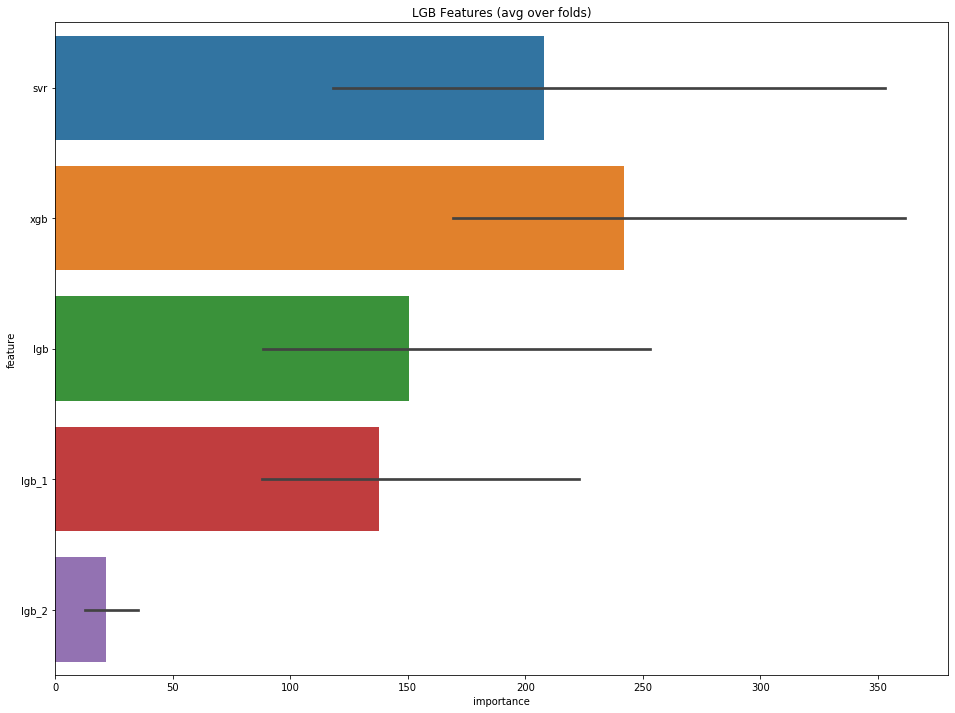

In [134]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:06:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.3661	valid_1's rmse: 2.2031
Early stopping, best iteration is:
[1564]	training's rmse: 2.26348	valid_1's rmse: 2.19883
Fold 1 started at Tue Dec 17 12:06:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[461]	training's rmse: 2.48324	valid_1's rmse: 2.62702
Fold 2 started at Tue Dec 17 12:06:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[442]	training's rmse: 2.42941	valid_1's rmse: 2.90162
Fold 3 started at Tue Dec 17 12:06:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[359]	training's rmse: 2.52639	valid_1's rmse: 2.83936
Fold 4 started at Tue Dec 17 12:06:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[199]	training's rms

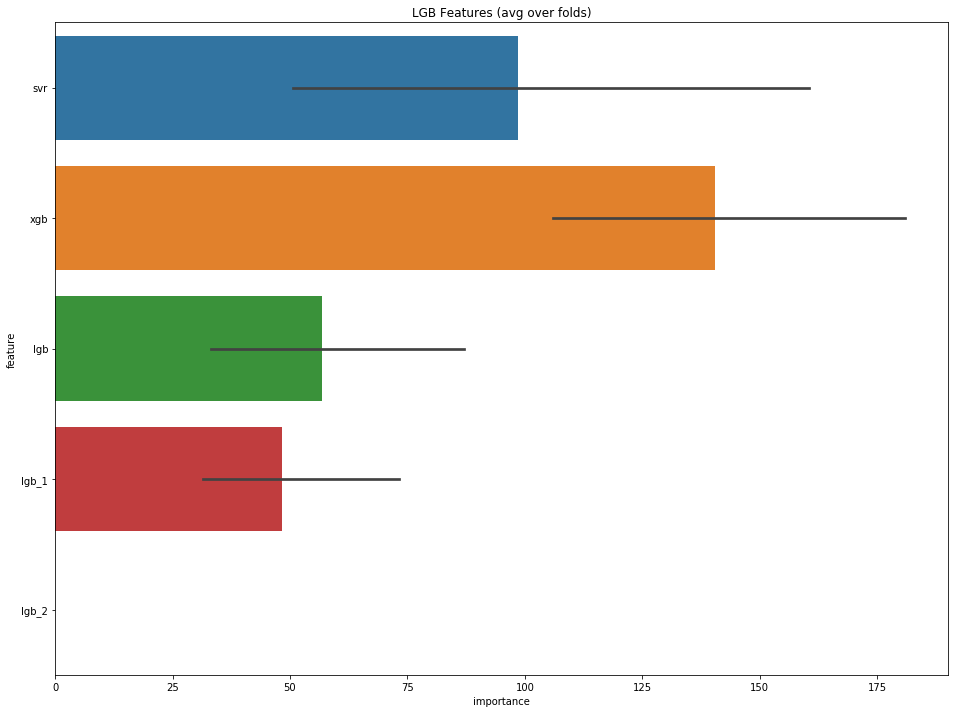

In [135]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:07:04 2019
Fold 1 started at Tue Dec 17 12:07:24 2019
Fold 2 started at Tue Dec 17 12:07:36 2019
Fold 3 started at Tue Dec 17 12:07:46 2019
Fold 4 started at Tue Dec 17 12:08:01 2019
Fold 5 started at Tue Dec 17 12:08:07 2019
Fold 6 started at Tue Dec 17 12:08:16 2019
Fold 7 started at Tue Dec 17 12:08:27 2019
Fold 8 started at Tue Dec 17 12:08:38 2019
Fold 9 started at Tue Dec 17 12:08:51 2019
CV mean score: 2.9040, std: 0.5315.


##### randomforest作为第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:09:03 2019
Fold 1 started at Tue Dec 17 12:09:03 2019
Fold 2 started at Tue Dec 17 12:09:04 2019
Fold 3 started at Tue Dec 17 12:09:04 2019
Fold 4 started at Tue Dec 17 12:09:04 2019
Fold 5 started at Tue Dec 17 12:09:04 2019
Fold 6 started at Tue Dec 17 12:09:05 2019
Fold 7 started at Tue Dec 17 12:09:05 2019
Fold 8 started at Tue Dec 17 12:09:05 2019
Fold 9 started at Tue Dec 17 12:09:05 2019
CV mean score: 2.9868, std: 0.5548.


##### xgboost作为第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:09:06 2019
[0]	train-rmse:23.835	valid_data-rmse:21.8414
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.27585	valid_data-rmse:2.2689
Stopping. Best iteration:
[707]	train-rmse:0.965774	valid_data-rmse:2.25042

Fold 1 started at Tue Dec 17 12:09:06 2019
[0]	train-rmse:23.708	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.2631	valid_data-rmse:2.95258
Stopping. Best iteration:
[472]	train-rmse:1.3285	valid_data-rmse:2.94866

Fold 2 started at Tue Dec 17 12:09:07 2019
[0]	train-rmse:23.7743	valid_data-rmse:22.4263
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse

##### svr 作为第二层融合模型

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:09:11 2019
Fold 1 started at Tue Dec 17 12:09:11 2019
Fold 2 started at Tue Dec 17 12:09:11 2019
Fold 3 started at Tue Dec 17 12:09:11 2019
Fold 4 started at Tue Dec 17 12:09:11 2019
Fold 5 started at Tue Dec 17 12:09:11 2019
Fold 6 started at Tue Dec 17 12:09:11 2019
Fold 7 started at Tue Dec 17 12:09:11 2019
Fold 8 started at Tue Dec 17 12:09:11 2019
Fold 9 started at Tue Dec 17 12:09:11 2019
CV mean score: 6.7546, std: 0.6600.


##### 岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:09:11 2019
Fold 1 started at Tue Dec 17 12:09:11 2019
Fold 2 started at Tue Dec 17 12:09:11 2019
Fold 3 started at Tue Dec 17 12:09:11 2019
Fold 4 started at Tue Dec 17 12:09:11 2019
Fold 5 started at Tue Dec 17 12:09:12 2019
Fold 6 started at Tue Dec 17 12:09:12 2019
Fold 7 started at Tue Dec 17 12:09:12 2019
Fold 8 started at Tue Dec 17 12:09:12 2019
Fold 9 started at Tue Dec 17 12:09:12 2019
CV mean score: 2.8244, std: 0.5407.


#### 留下cat和rfr

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:09:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[742]	training's rmse: 2.68203	valid_1's rmse: 2.05353
Fold 1 started at Tue Dec 17 12:09:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 2.70585	valid_1's rmse: 3.6069
Fold 2 started at Tue Dec 17 12:09:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[329]	training's rmse: 2.81694	valid_1's rmse: 2.83172
Fold 3 started at Tue Dec 17 12:09:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 2.66245	valid_1's rmse: 3.17381
Fold 4 started at Tue Dec 17 12:09:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 2.82698	valid_1's rmse: 3.93979
Fold 5 started at Tue

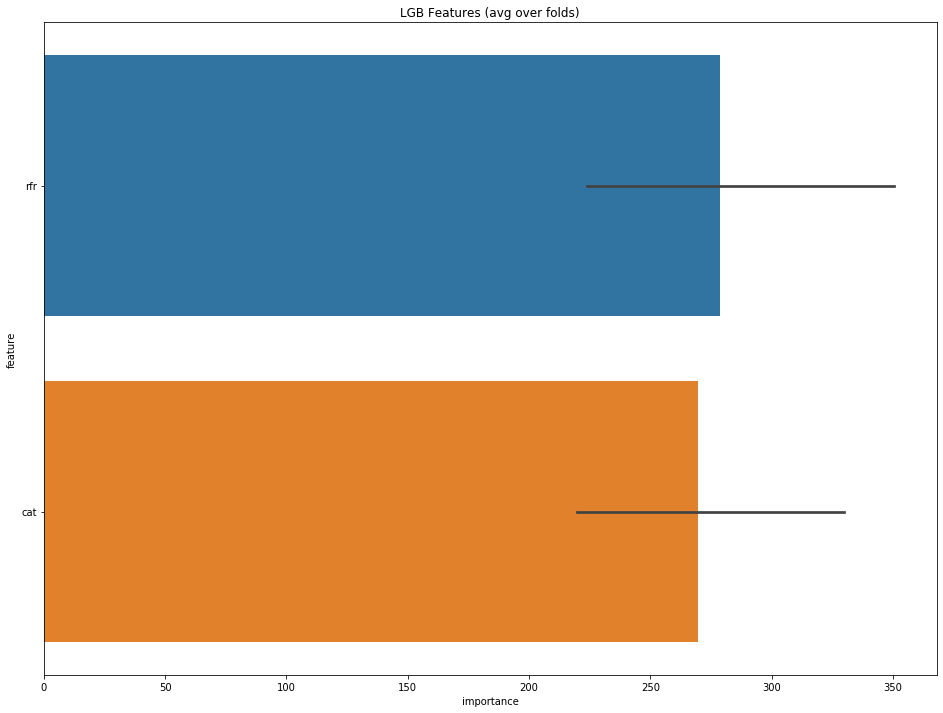

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:10:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[568]	training's rmse: 2.59487	valid_1's rmse: 2.096
Fold 1 started at Tue Dec 17 12:10:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.45145	valid_1's rmse: 3.11369
Early stopping, best iteration is:
[1121]	training's rmse: 2.44163	valid_1's rmse: 3.10279
Fold 2 started at Tue Dec 17 12:11:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[789]	training's rmse: 2.49265	valid_1's rmse: 2.68225
Fold 3 started at Tue Dec 17 12:11:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[418]	training's rmse: 2.61656	valid_1's rmse: 2.76153
Fold 4 started at Tue Dec 17 12:11:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[253]	training's rms

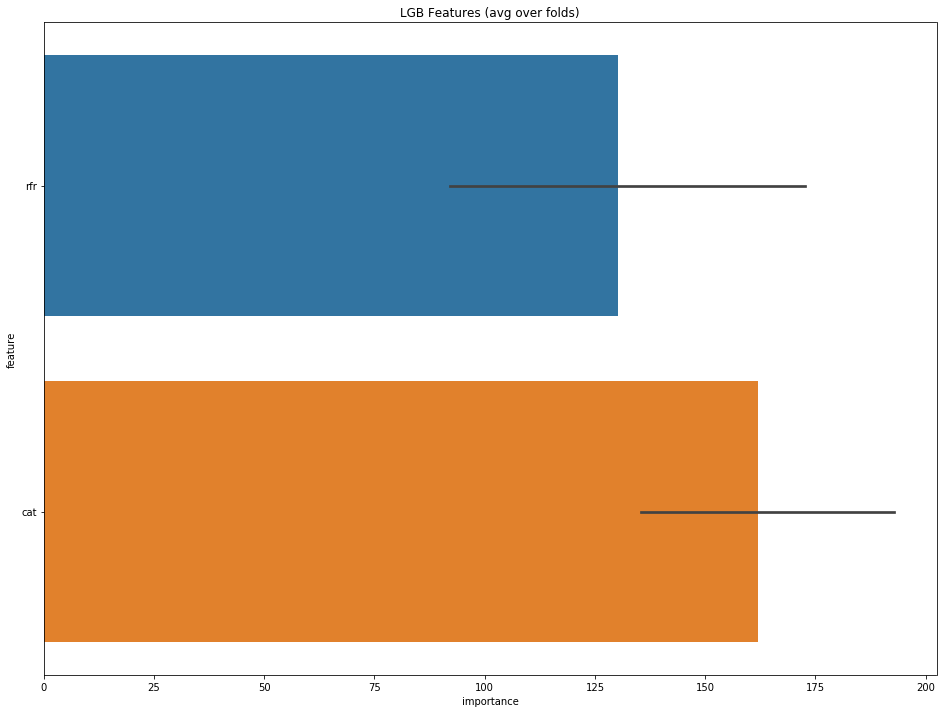

In [143]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [144]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:11:39 2019
Fold 1 started at Tue Dec 17 12:11:51 2019
Fold 2 started at Tue Dec 17 12:12:56 2019
Fold 3 started at Tue Dec 17 12:13:06 2019
Fold 4 started at Tue Dec 17 12:13:25 2019
Fold 5 started at Tue Dec 17 12:13:32 2019
Fold 6 started at Tue Dec 17 12:13:41 2019
Fold 7 started at Tue Dec 17 12:13:52 2019
Fold 8 started at Tue Dec 17 12:14:02 2019
Fold 9 started at Tue Dec 17 12:14:43 2019
CV mean score: 2.9541, std: 0.4942.


##### randomforest作为第二层融合模型

In [145]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:14:55 2019
Fold 1 started at Tue Dec 17 12:14:55 2019
Fold 2 started at Tue Dec 17 12:14:55 2019
Fold 3 started at Tue Dec 17 12:14:56 2019
Fold 4 started at Tue Dec 17 12:14:56 2019
Fold 5 started at Tue Dec 17 12:14:56 2019
Fold 6 started at Tue Dec 17 12:14:56 2019
Fold 7 started at Tue Dec 17 12:14:57 2019
Fold 8 started at Tue Dec 17 12:14:57 2019
Fold 9 started at Tue Dec 17 12:14:57 2019
CV mean score: 3.0561, std: 0.4649.


##### xgboost作为第二层融合模型

In [146]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:14:57 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.841
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.80985	valid_data-rmse:2.45493
Stopping. Best iteration:
[388]	train-rmse:2.15876	valid_data-rmse:2.4475

Fold 1 started at Tue Dec 17 12:14:58 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.77515	valid_data-rmse:3.75153
Stopping. Best iteration:
[567]	train-rmse:1.65713	valid_data-rmse:3.74282

Fold 2 started at Tue Dec 17 12:14:58 2019
[0]	train-rmse:23.7749	valid_data-rmse:22.4239
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [147]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:15:00 2019
Fold 1 started at Tue Dec 17 12:15:00 2019
Fold 2 started at Tue Dec 17 12:15:00 2019
Fold 3 started at Tue Dec 17 12:15:00 2019
Fold 4 started at Tue Dec 17 12:15:00 2019
Fold 5 started at Tue Dec 17 12:15:00 2019
Fold 6 started at Tue Dec 17 12:15:00 2019
Fold 7 started at Tue Dec 17 12:15:00 2019
Fold 8 started at Tue Dec 17 12:15:00 2019
Fold 9 started at Tue Dec 17 12:15:00 2019
CV mean score: 6.8720, std: 0.7184.


##### 岭回归做第二层融合模型

In [148]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:15:00 2019
Fold 1 started at Tue Dec 17 12:15:00 2019
Fold 2 started at Tue Dec 17 12:15:00 2019
Fold 3 started at Tue Dec 17 12:15:00 2019
Fold 4 started at Tue Dec 17 12:15:01 2019
Fold 5 started at Tue Dec 17 12:15:01 2019
Fold 6 started at Tue Dec 17 12:15:01 2019
Fold 7 started at Tue Dec 17 12:15:01 2019
Fold 8 started at Tue Dec 17 12:15:01 2019
Fold 9 started at Tue Dec 17 12:15:01 2019
CV mean score: 2.9370, std: 0.4703.


#### 留下cat和svr

In [149]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:15:01 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.49741	valid_1's rmse: 2.44865
[2000]	training's rmse: 2.30835	valid_1's rmse: 2.3246
Early stopping, best iteration is:
[2229]	training's rmse: 2.27939	valid_1's rmse: 2.31397
Fold 1 started at Tue Dec 17 12:15:37 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.39379	valid_1's rmse: 3.50215
Early stopping, best iteration is:
[1752]	training's rmse: 2.24983	valid_1's rmse: 3.44804
Fold 2 started at Tue Dec 17 12:16:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.43657	valid_1's rmse: 3.56706
[2000]	training's rmse: 2.23095	valid_1's rmse: 3.40175
Early stopping, best iteration is:
[2327]	training's rmse: 2.18618	valid_1's rmse: 3.39732
Fold 3 started at Tue Dec 17 12:16:37 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 

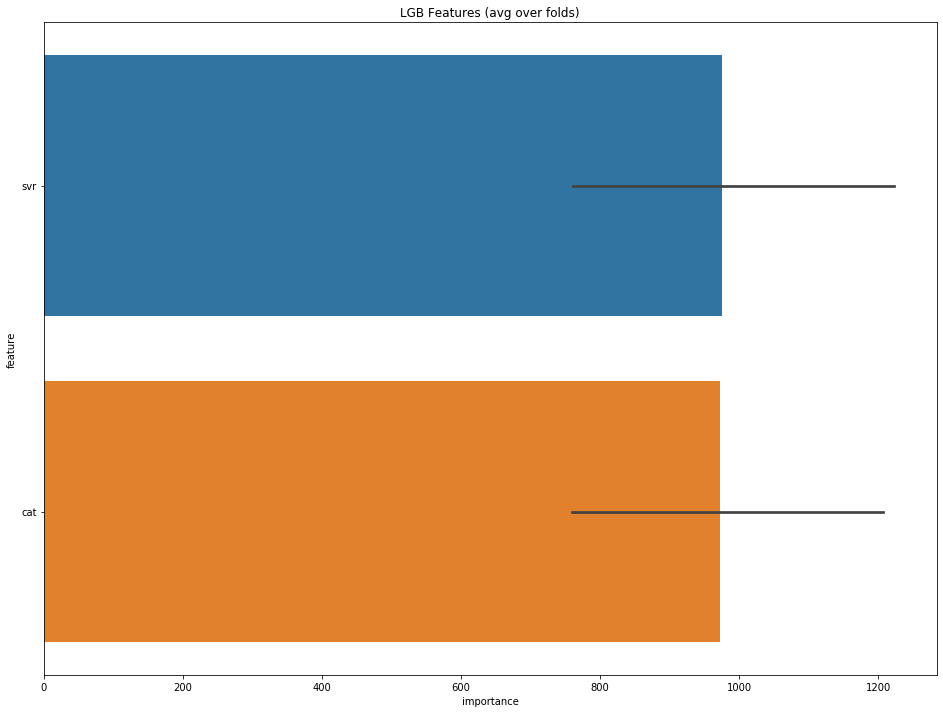

In [150]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:19:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[569]	training's rmse: 2.57277	valid_1's rmse: 2.18132
Fold 1 started at Tue Dec 17 12:19:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[517]	training's rmse: 2.49008	valid_1's rmse: 3.28513
Fold 2 started at Tue Dec 17 12:19:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[403]	training's rmse: 2.58804	valid_1's rmse: 2.91762
Fold 3 started at Tue Dec 17 12:19:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 2.64388	valid_1's rmse: 2.85592
Fold 4 started at Tue Dec 17 12:19:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[223]	training's rmse: 2.82788	valid_1's rmse: 3.80373
Fold 5 started at Tu

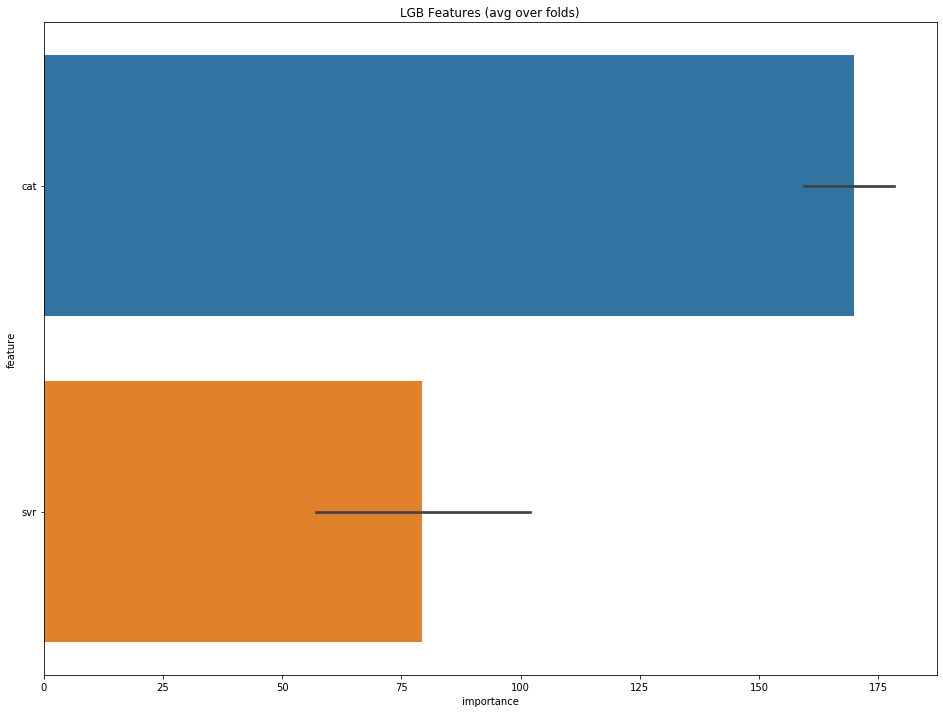

In [151]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [152]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:19:46 2019
Fold 1 started at Tue Dec 17 12:19:58 2019
Fold 2 started at Tue Dec 17 12:20:18 2019
Fold 3 started at Tue Dec 17 12:20:35 2019
Fold 4 started at Tue Dec 17 12:20:56 2019
Fold 5 started at Tue Dec 17 12:21:24 2019
Fold 6 started at Tue Dec 17 12:21:32 2019
Fold 7 started at Tue Dec 17 12:21:44 2019
Fold 8 started at Tue Dec 17 12:21:52 2019
Fold 9 started at Tue Dec 17 12:22:07 2019
CV mean score: 2.9101, std: 0.3260.


##### randomforest作为第二层融合模型

In [153]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:22:16 2019
Fold 1 started at Tue Dec 17 12:22:16 2019
Fold 2 started at Tue Dec 17 12:22:16 2019
Fold 3 started at Tue Dec 17 12:22:16 2019
Fold 4 started at Tue Dec 17 12:22:17 2019
Fold 5 started at Tue Dec 17 12:22:17 2019
Fold 6 started at Tue Dec 17 12:22:17 2019
Fold 7 started at Tue Dec 17 12:22:17 2019
Fold 8 started at Tue Dec 17 12:22:17 2019
Fold 9 started at Tue Dec 17 12:22:18 2019
CV mean score: 3.1160, std: 0.3629.


##### xgboost作为第二层融合模型

In [154]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:22:18 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.841
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.12635	valid_data-rmse:3.1639
[1000]	train-rmse:1.24603	valid_data-rmse:2.98212
Stopping. Best iteration:
[1099]	train-rmse:1.15997	valid_data-rmse:2.98166

Fold 1 started at Tue Dec 17 12:22:18 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.10135	valid_data-rmse:3.91939
[1000]	train-rmse:1.23545	valid_data-rmse:3.6774
[1500]	train-rmse:0.898536	valid_data-rmse:3.63719
[2000]	train-rmse:0.690579	valid_data-rmse:3.61905
[2500]	train-rmse:0.548236	valid_data-rmse:3.60184
[3000]	train-rmse:0.440812	valid_data-rmse:3.58859
[3500]	train-rmse:0.359379	valid

##### svr 作为第二层融合模型

In [155]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:22:23 2019
Fold 1 started at Tue Dec 17 12:22:23 2019
Fold 2 started at Tue Dec 17 12:22:23 2019
Fold 3 started at Tue Dec 17 12:22:23 2019
Fold 4 started at Tue Dec 17 12:22:23 2019
Fold 5 started at Tue Dec 17 12:22:23 2019
Fold 6 started at Tue Dec 17 12:22:23 2019
Fold 7 started at Tue Dec 17 12:22:23 2019
Fold 8 started at Tue Dec 17 12:22:23 2019
Fold 9 started at Tue Dec 17 12:22:23 2019
CV mean score: 5.6248, std: 0.4838.


##### 岭回归做第二层融合模型

In [156]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:22:23 2019
Fold 1 started at Tue Dec 17 12:22:24 2019
Fold 2 started at Tue Dec 17 12:22:24 2019
Fold 3 started at Tue Dec 17 12:22:24 2019
Fold 4 started at Tue Dec 17 12:22:24 2019
Fold 5 started at Tue Dec 17 12:22:24 2019
Fold 6 started at Tue Dec 17 12:22:24 2019
Fold 7 started at Tue Dec 17 12:22:24 2019
Fold 8 started at Tue Dec 17 12:22:24 2019
Fold 9 started at Tue Dec 17 12:22:24 2019
CV mean score: 2.8867, std: 0.4459.


#### 留下rfr和svr

In [157]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:22:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.05793	valid_1's rmse: 2.57354
[2000]	training's rmse: 2.82932	valid_1's rmse: 2.45669
Early stopping, best iteration is:
[1955]	training's rmse: 2.83686	valid_1's rmse: 2.45118
Fold 1 started at Tue Dec 17 12:22:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.92607	valid_1's rmse: 4.37101
Early stopping, best iteration is:
[1411]	training's rmse: 2.8132	valid_1's rmse: 4.35844
Fold 2 started at Tue Dec 17 12:23:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.00437	valid_1's rmse: 3.86689
Early stopping, best iteration is:
[1566]	training's rmse: 2.84137	valid_1's rmse: 3.80225
Fold 3 started at Tue Dec 17 12:23:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.0049	valid_1's rmse: 3.65504
Early stopping, best iter

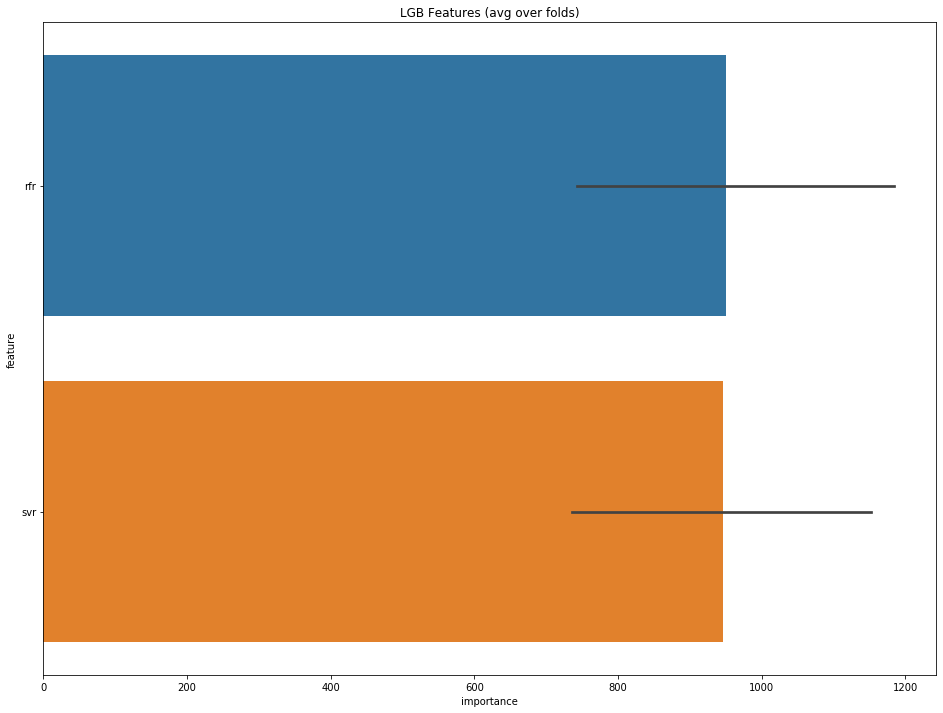

In [158]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:25:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 3.28861	valid_1's rmse: 2.25145
Fold 1 started at Tue Dec 17 12:25:52 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.98615	valid_1's rmse: 4.17033
[2000]	training's rmse: 2.84288	valid_1's rmse: 4.13499
Early stopping, best iteration is:
[2210]	training's rmse: 2.80956	valid_1's rmse: 4.12766
Fold 2 started at Tue Dec 17 12:26:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 3.26692	valid_1's rmse: 3.02893
Fold 3 started at Tue Dec 17 12:26:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.0398	valid_1's rmse: 3.23095
Early stopping, best iteration is:
[939]	training's rmse: 3.05322	valid_1's rmse: 3.22957
Fold 4 started at Tue Dec 17 12:26:22 2019
Train

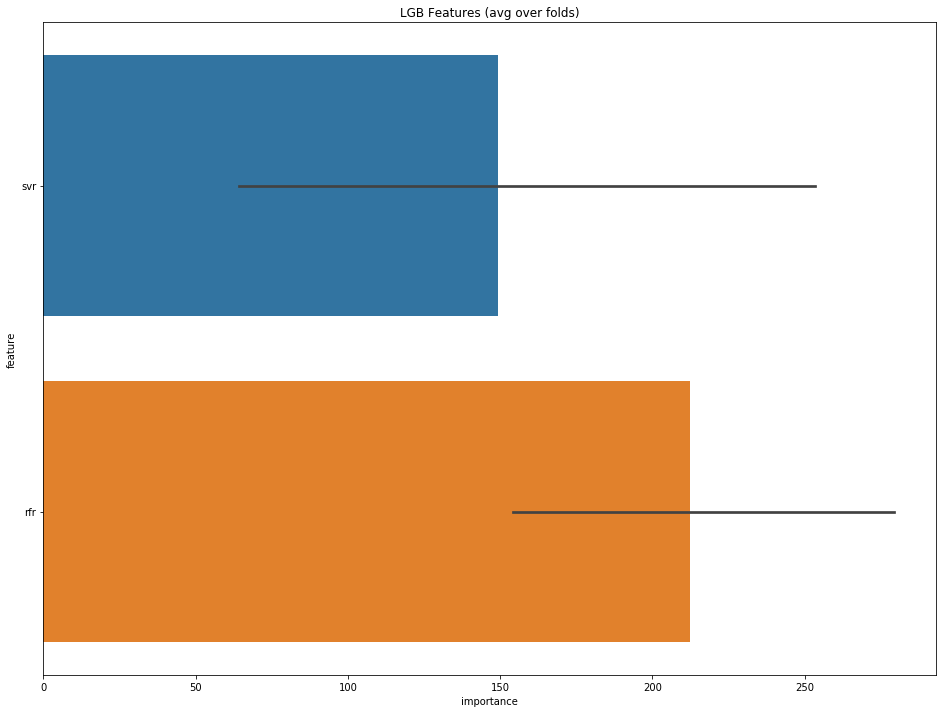

In [159]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [160]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:26:52 2019
Fold 1 started at Tue Dec 17 12:27:06 2019
Fold 2 started at Tue Dec 17 12:27:23 2019
Fold 3 started at Tue Dec 17 12:27:35 2019
Fold 4 started at Tue Dec 17 12:28:09 2019
Fold 5 started at Tue Dec 17 12:28:20 2019
Fold 6 started at Tue Dec 17 12:28:29 2019
Fold 7 started at Tue Dec 17 12:28:41 2019
Fold 8 started at Tue Dec 17 12:28:51 2019
Fold 9 started at Tue Dec 17 12:29:22 2019
CV mean score: 3.5318, std: 0.7643.


##### randomforest作为第二层融合模型

In [161]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:29:32 2019
Fold 1 started at Tue Dec 17 12:29:32 2019
Fold 2 started at Tue Dec 17 12:29:33 2019
Fold 3 started at Tue Dec 17 12:29:33 2019
Fold 4 started at Tue Dec 17 12:29:33 2019
Fold 5 started at Tue Dec 17 12:29:33 2019
Fold 6 started at Tue Dec 17 12:29:34 2019
Fold 7 started at Tue Dec 17 12:29:34 2019
Fold 8 started at Tue Dec 17 12:29:34 2019
Fold 9 started at Tue Dec 17 12:29:34 2019
CV mean score: 3.9916, std: 0.7197.


##### xgboost作为第二层融合模型

In [162]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:29:34 2019
[0]	train-rmse:23.8607	valid_data-rmse:21.8211
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.28823	valid_data-rmse:2.87325
Stopping. Best iteration:
[787]	train-rmse:1.67076	valid_data-rmse:2.8212

Fold 1 started at Tue Dec 17 12:29:35 2019
[0]	train-rmse:23.7323	valid_data-rmse:23.0597
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.2203	valid_data-rmse:4.76689
Stopping. Best iteration:
[702]	train-rmse:1.77174	valid_data-rmse:4.73182

Fold 2 started at Tue Dec 17 12:29:35 2019
[0]	train-rmse:23.7973	valid_data-rmse:22.3962
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best

##### svr 作为第二层融合模型

In [163]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:29:38 2019
Fold 1 started at Tue Dec 17 12:29:38 2019
Fold 2 started at Tue Dec 17 12:29:38 2019
Fold 3 started at Tue Dec 17 12:29:38 2019
Fold 4 started at Tue Dec 17 12:29:38 2019
Fold 5 started at Tue Dec 17 12:29:38 2019
Fold 6 started at Tue Dec 17 12:29:38 2019
Fold 7 started at Tue Dec 17 12:29:38 2019
Fold 8 started at Tue Dec 17 12:29:38 2019
Fold 9 started at Tue Dec 17 12:29:38 2019
CV mean score: 5.5207, std: 0.4898.


##### 岭回归做第二层融合模型

In [164]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:29:38 2019
Fold 1 started at Tue Dec 17 12:29:38 2019
Fold 2 started at Tue Dec 17 12:29:38 2019
Fold 3 started at Tue Dec 17 12:29:39 2019
Fold 4 started at Tue Dec 17 12:29:39 2019
Fold 5 started at Tue Dec 17 12:29:39 2019
Fold 6 started at Tue Dec 17 12:29:39 2019
Fold 7 started at Tue Dec 17 12:29:39 2019
Fold 8 started at Tue Dec 17 12:29:39 2019
Fold 9 started at Tue Dec 17 12:29:39 2019
CV mean score: 3.5537, std: 0.7533.


#### 留下xgb和cat

In [165]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:29:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[584]	training's rmse: 2.52704	valid_1's rmse: 2.15812
Fold 1 started at Tue Dec 17 12:29:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.37907	valid_1's rmse: 2.67944
Early stopping, best iteration is:
[944]	training's rmse: 2.3891	valid_1's rmse: 2.67608
Fold 2 started at Tue Dec 17 12:30:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[377]	training's rmse: 2.50077	valid_1's rmse: 2.85348
Fold 3 started at Tue Dec 17 12:30:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[707]	training's rmse: 2.42409	valid_1's rmse: 2.792
Fold 4 started at Tue Dec 17 12:30:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse:

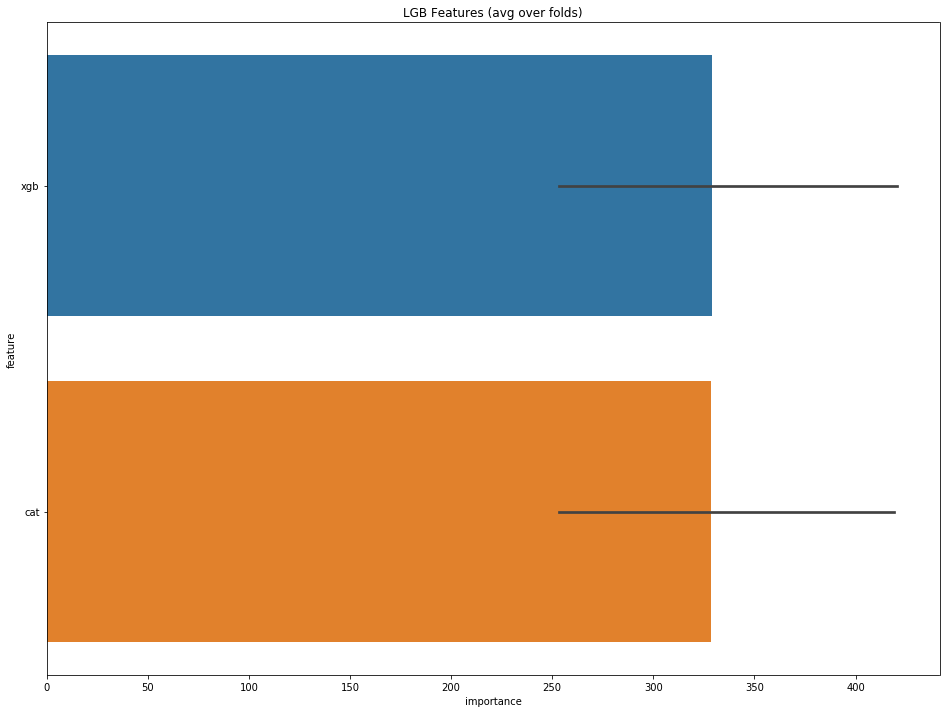

In [166]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:31:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[534]	training's rmse: 2.57547	valid_1's rmse: 2.1851
Fold 1 started at Tue Dec 17 12:31:11 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.48261	valid_1's rmse: 2.87918
Early stopping, best iteration is:
[1040]	training's rmse: 2.48065	valid_1's rmse: 2.87876
Fold 2 started at Tue Dec 17 12:31:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[384]	training's rmse: 2.53646	valid_1's rmse: 2.82724
Fold 3 started at Tue Dec 17 12:31:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.47049	valid_1's rmse: 2.77591
Early stopping, best iteration is:
[888]	training's rmse: 2.48131	valid_1's rmse: 2.77498
Fold 4 started at Tue Dec 17 12:31:29 2019
Training until validation scores don't improve for 200 rounds

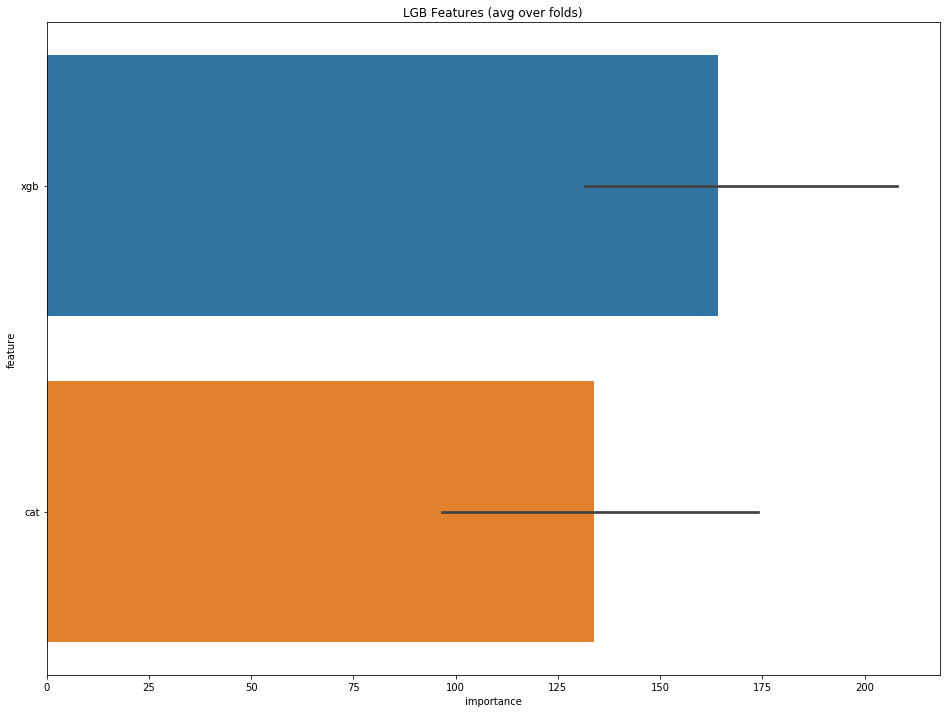

In [167]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [168]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:31:58 2019
Fold 1 started at Tue Dec 17 12:32:16 2019
Fold 2 started at Tue Dec 17 12:32:52 2019
Fold 3 started at Tue Dec 17 12:33:01 2019
Fold 4 started at Tue Dec 17 12:33:12 2019
Fold 5 started at Tue Dec 17 12:33:17 2019
Fold 6 started at Tue Dec 17 12:33:25 2019
Fold 7 started at Tue Dec 17 12:33:34 2019
Fold 8 started at Tue Dec 17 12:33:42 2019
Fold 9 started at Tue Dec 17 12:33:55 2019
CV mean score: 2.7679, std: 0.4423.


##### randomforest作为第二层融合模型

In [169]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:34:02 2019
Fold 1 started at Tue Dec 17 12:34:02 2019
Fold 2 started at Tue Dec 17 12:34:03 2019
Fold 3 started at Tue Dec 17 12:34:03 2019
Fold 4 started at Tue Dec 17 12:34:03 2019
Fold 5 started at Tue Dec 17 12:34:03 2019
Fold 6 started at Tue Dec 17 12:34:04 2019
Fold 7 started at Tue Dec 17 12:34:04 2019
Fold 8 started at Tue Dec 17 12:34:04 2019
Fold 9 started at Tue Dec 17 12:34:04 2019
CV mean score: 2.8865, std: 0.4549.


##### xgboost作为第二层融合模型

In [170]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:34:04 2019
[0]	train-rmse:23.8355	valid_data-rmse:21.8424
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.70973	valid_data-rmse:2.38737
Stopping. Best iteration:
[487]	train-rmse:1.7354	valid_data-rmse:2.38667

Fold 1 started at Tue Dec 17 12:34:05 2019
[0]	train-rmse:23.7078	valid_data-rmse:23.0446
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.71998	valid_data-rmse:2.82164
Stopping. Best iteration:
[613]	train-rmse:1.54824	valid_data-rmse:2.78838

Fold 2 started at Tue Dec 17 12:34:05 2019
[0]	train-rmse:23.7745	valid_data-rmse:22.426
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [171]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:34:07 2019
Fold 1 started at Tue Dec 17 12:34:07 2019
Fold 2 started at Tue Dec 17 12:34:07 2019
Fold 3 started at Tue Dec 17 12:34:07 2019
Fold 4 started at Tue Dec 17 12:34:07 2019
Fold 5 started at Tue Dec 17 12:34:07 2019
Fold 6 started at Tue Dec 17 12:34:07 2019
Fold 7 started at Tue Dec 17 12:34:07 2019
Fold 8 started at Tue Dec 17 12:34:07 2019
Fold 9 started at Tue Dec 17 12:34:07 2019
CV mean score: 6.4585, std: 0.6487.


##### 岭回归做第二层融合模型

In [172]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:34:07 2019
Fold 1 started at Tue Dec 17 12:34:08 2019
Fold 2 started at Tue Dec 17 12:34:08 2019
Fold 3 started at Tue Dec 17 12:34:08 2019
Fold 4 started at Tue Dec 17 12:34:08 2019
Fold 5 started at Tue Dec 17 12:34:08 2019
Fold 6 started at Tue Dec 17 12:34:08 2019
Fold 7 started at Tue Dec 17 12:34:08 2019
Fold 8 started at Tue Dec 17 12:34:08 2019
Fold 9 started at Tue Dec 17 12:34:08 2019
CV mean score: 2.8102, std: 0.4876.


#### 留下xgb和rfr

In [173]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:34:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[747]	training's rmse: 2.61795	valid_1's rmse: 2.05051
Fold 1 started at Tue Dec 17 12:34:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.46875	valid_1's rmse: 2.79902
[2000]	training's rmse: 2.29297	valid_1's rmse: 2.71535
[3000]	training's rmse: 2.18823	valid_1's rmse: 2.68053
Early stopping, best iteration is:
[3119]	training's rmse: 2.1779	valid_1's rmse: 2.67368
Fold 2 started at Tue Dec 17 12:35:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[399]	training's rmse: 2.68183	valid_1's rmse: 2.75392
Fold 3 started at Tue Dec 17 12:35:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[413]	training's rmse: 2.62278	valid_1's rmse: 3.01947
Fold 4 started at Tue Dec 17 12:35:17 2019
Train

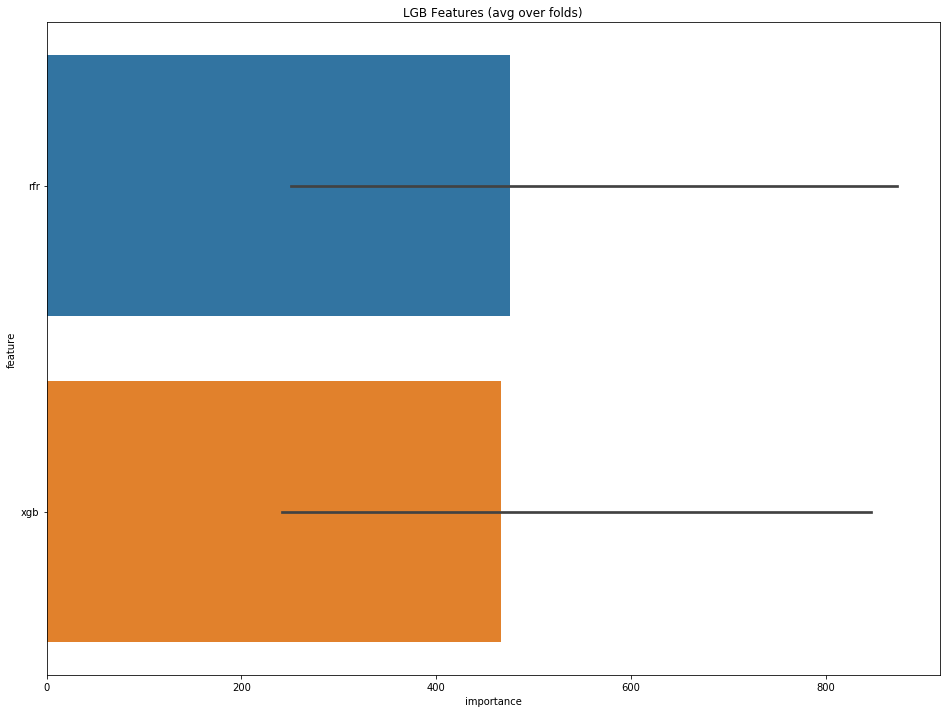

In [174]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:36:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[628]	training's rmse: 2.5701	valid_1's rmse: 2.07164
Fold 1 started at Tue Dec 17 12:36:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.43095	valid_1's rmse: 2.33723
Early stopping, best iteration is:
[1487]	training's rmse: 2.36935	valid_1's rmse: 2.30354
Fold 2 started at Tue Dec 17 12:36:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[509]	training's rmse: 2.53459	valid_1's rmse: 2.76166
Fold 3 started at Tue Dec 17 12:36:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.3813	valid_1's rmse: 2.66928
Early stopping, best iteration is:
[906]	training's rmse: 2.39696	valid_1's rmse: 2.66566
Fold 4 started at Tue Dec 17 12:36:23 2019
Training until validation scores don't improve for 200 rounds.

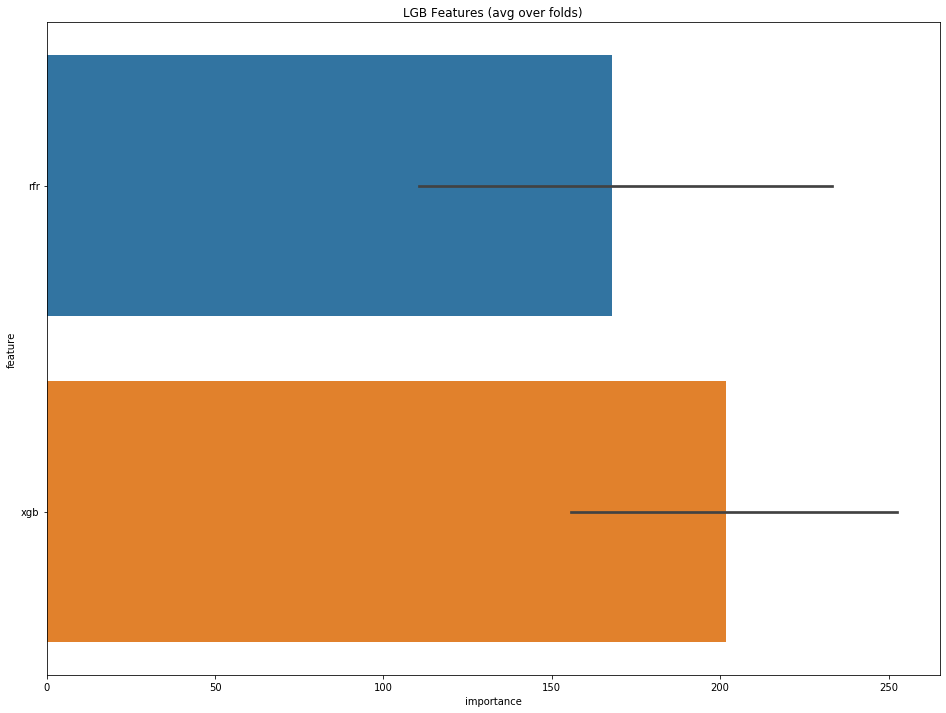

In [175]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [176]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:36:41 2019
Fold 1 started at Tue Dec 17 12:36:54 2019
Fold 2 started at Tue Dec 17 12:37:21 2019
Fold 3 started at Tue Dec 17 12:37:27 2019
Fold 4 started at Tue Dec 17 12:37:37 2019
Fold 5 started at Tue Dec 17 12:37:40 2019
Fold 6 started at Tue Dec 17 12:37:44 2019
Fold 7 started at Tue Dec 17 12:37:52 2019
Fold 8 started at Tue Dec 17 12:37:58 2019
Fold 9 started at Tue Dec 17 12:38:05 2019
CV mean score: 2.7881, std: 0.4858.


##### randomforest作为第二层融合模型

In [177]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:38:37 2019
Fold 1 started at Tue Dec 17 12:38:38 2019
Fold 2 started at Tue Dec 17 12:38:38 2019
Fold 3 started at Tue Dec 17 12:38:38 2019
Fold 4 started at Tue Dec 17 12:38:38 2019
Fold 5 started at Tue Dec 17 12:38:39 2019
Fold 6 started at Tue Dec 17 12:38:39 2019
Fold 7 started at Tue Dec 17 12:38:39 2019
Fold 8 started at Tue Dec 17 12:38:39 2019
Fold 9 started at Tue Dec 17 12:38:39 2019
CV mean score: 2.9636, std: 0.5228.


##### xgboost作为第二层融合模型

In [178]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:38:40 2019
[0]	train-rmse:23.8355	valid_data-rmse:21.8424
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.82739	valid_data-rmse:2.27792
Stopping. Best iteration:
[483]	train-rmse:1.86391	valid_data-rmse:2.27784

Fold 1 started at Tue Dec 17 12:38:40 2019
[0]	train-rmse:23.7078	valid_data-rmse:23.0446
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.75987	valid_data-rmse:3.38224
Stopping. Best iteration:
[593]	train-rmse:1.59837	valid_data-rmse:3.35497

Fold 2 started at Tue Dec 17 12:38:40 2019
[0]	train-rmse:23.7745	valid_data-rmse:22.426
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [179]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:38:42 2019
Fold 1 started at Tue Dec 17 12:38:42 2019
Fold 2 started at Tue Dec 17 12:38:42 2019
Fold 3 started at Tue Dec 17 12:38:42 2019
Fold 4 started at Tue Dec 17 12:38:42 2019
Fold 5 started at Tue Dec 17 12:38:42 2019
Fold 6 started at Tue Dec 17 12:38:42 2019
Fold 7 started at Tue Dec 17 12:38:42 2019
Fold 8 started at Tue Dec 17 12:38:42 2019
Fold 9 started at Tue Dec 17 12:38:42 2019
CV mean score: 6.8818, std: 0.6746.


##### 岭回归做第二层融合模型

In [180]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:38:42 2019
Fold 1 started at Tue Dec 17 12:38:42 2019
Fold 2 started at Tue Dec 17 12:38:43 2019
Fold 3 started at Tue Dec 17 12:38:43 2019
Fold 4 started at Tue Dec 17 12:38:43 2019
Fold 5 started at Tue Dec 17 12:38:43 2019
Fold 6 started at Tue Dec 17 12:38:43 2019
Fold 7 started at Tue Dec 17 12:38:43 2019
Fold 8 started at Tue Dec 17 12:38:43 2019
Fold 9 started at Tue Dec 17 12:38:43 2019
CV mean score: 2.8380, std: 0.5601.


#### 留下xgb和svr

In [181]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:38:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.45417	valid_1's rmse: 2.44115
Early stopping, best iteration is:
[1649]	training's rmse: 2.32389	valid_1's rmse: 2.36114
Fold 1 started at Tue Dec 17 12:38:58 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.42404	valid_1's rmse: 2.74389
Early stopping, best iteration is:
[1324]	training's rmse: 2.34591	valid_1's rmse: 2.7123
Fold 2 started at Tue Dec 17 12:39:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.35263	valid_1's rmse: 3.30914
[2000]	training's rmse: 2.17447	valid_1's rmse: 3.1205
Early stopping, best iteration is:
[2149]	training's rmse: 2.15791	valid_1's rmse: 3.11233
Fold 3 started at Tue Dec 17 12:39:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.389	valid_1's rmse: 2.94353
Early stopping, best iterat

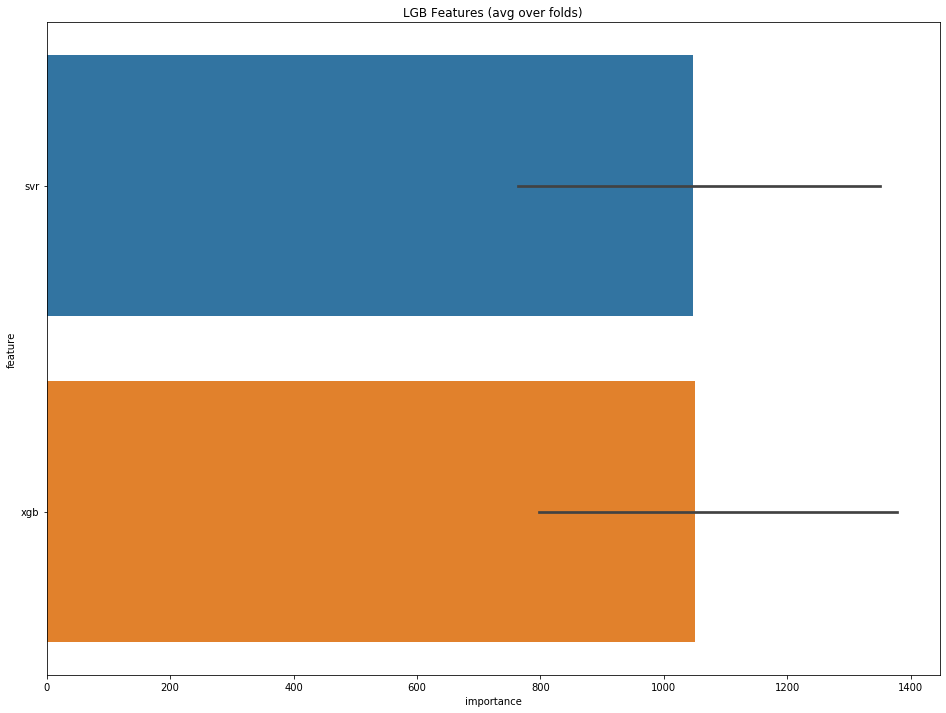

In [182]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:40:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[458]	training's rmse: 2.59904	valid_1's rmse: 2.15047
Fold 1 started at Tue Dec 17 12:40:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.4306	valid_1's rmse: 2.44694
Early stopping, best iteration is:
[1039]	training's rmse: 2.42306	valid_1's rmse: 2.44384
Fold 2 started at Tue Dec 17 12:40:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[416]	training's rmse: 2.51924	valid_1's rmse: 2.92859
Fold 3 started at Tue Dec 17 12:40:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[360]	training's rmse: 2.61919	valid_1's rmse: 2.78953
Fold 4 started at Tue Dec 17 12:40:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[199]	training's rm

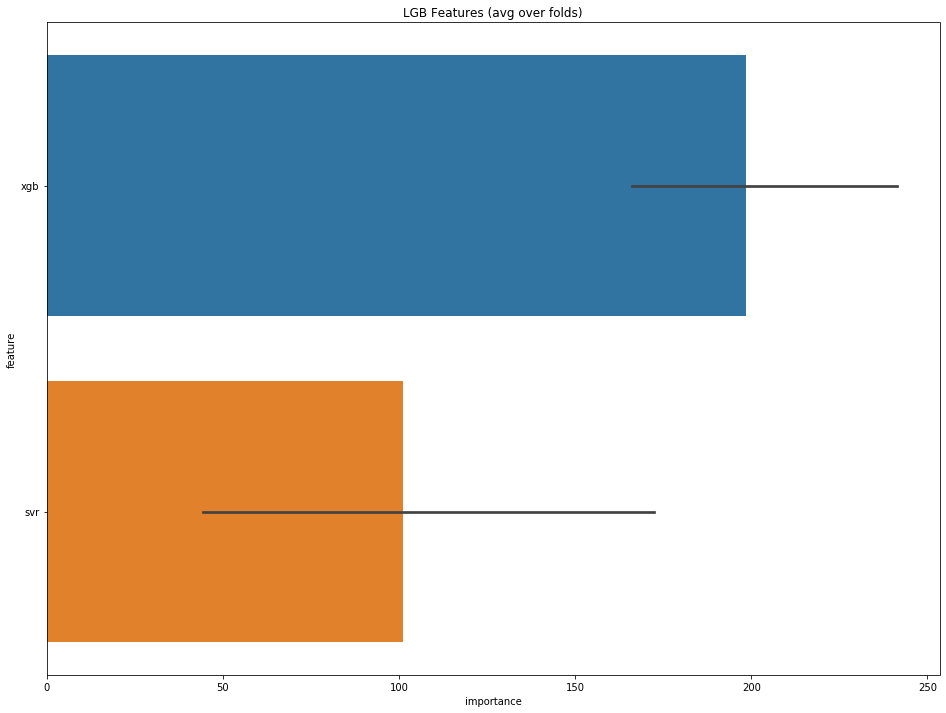

In [183]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [184]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:40:34 2019
Fold 1 started at Tue Dec 17 12:40:47 2019
Fold 2 started at Tue Dec 17 12:41:01 2019
Fold 3 started at Tue Dec 17 12:41:24 2019
Fold 4 started at Tue Dec 17 12:41:34 2019
Fold 5 started at Tue Dec 17 12:41:40 2019
Fold 6 started at Tue Dec 17 12:41:45 2019
Fold 7 started at Tue Dec 17 12:41:51 2019
Fold 8 started at Tue Dec 17 12:41:57 2019
Fold 9 started at Tue Dec 17 12:42:01 2019
CV mean score: 2.7949, std: 0.4454.


##### randomforest作为第二层融合模型

In [185]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:42:09 2019
Fold 1 started at Tue Dec 17 12:42:10 2019
Fold 2 started at Tue Dec 17 12:42:10 2019
Fold 3 started at Tue Dec 17 12:42:10 2019
Fold 4 started at Tue Dec 17 12:42:10 2019
Fold 5 started at Tue Dec 17 12:42:11 2019
Fold 6 started at Tue Dec 17 12:42:11 2019
Fold 7 started at Tue Dec 17 12:42:11 2019
Fold 8 started at Tue Dec 17 12:42:11 2019
Fold 9 started at Tue Dec 17 12:42:12 2019
CV mean score: 3.0745, std: 0.4165.


##### xgboost作为第二层融合模型

In [186]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:42:12 2019
[0]	train-rmse:23.8355	valid_data-rmse:21.8424
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.10286	valid_data-rmse:2.98964
[1000]	train-rmse:1.19449	valid_data-rmse:2.48871
[1500]	train-rmse:0.87067	valid_data-rmse:2.45321
Stopping. Best iteration:
[1305]	train-rmse:0.974292	valid_data-rmse:2.44838

Fold 1 started at Tue Dec 17 12:42:12 2019
[0]	train-rmse:23.7078	valid_data-rmse:23.0446
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.06413	valid_data-rmse:3.64111
[1000]	train-rmse:1.18489	valid_data-rmse:3.34154
Stopping. Best iteration:
[1089]	train-rmse:1.10851	valid_data-rmse:3.33688

Fold 2 started at Tue Dec 17 12:42:13 2019
[0]	train-rmse:23.7745	valid_data-rmse:22.426
Multiple eval me

##### svr 作为第二层融合模型

In [187]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:42:16 2019
Fold 1 started at Tue Dec 17 12:42:16 2019
Fold 2 started at Tue Dec 17 12:42:16 2019
Fold 3 started at Tue Dec 17 12:42:16 2019
Fold 4 started at Tue Dec 17 12:42:16 2019
Fold 5 started at Tue Dec 17 12:42:16 2019
Fold 6 started at Tue Dec 17 12:42:17 2019
Fold 7 started at Tue Dec 17 12:42:17 2019
Fold 8 started at Tue Dec 17 12:42:17 2019
Fold 9 started at Tue Dec 17 12:42:17 2019
CV mean score: 5.6774, std: 0.5407.


##### 岭回归做第二层融合模型

In [188]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:42:17 2019
Fold 1 started at Tue Dec 17 12:42:17 2019
Fold 2 started at Tue Dec 17 12:42:17 2019
Fold 3 started at Tue Dec 17 12:42:17 2019
Fold 4 started at Tue Dec 17 12:42:17 2019
Fold 5 started at Tue Dec 17 12:42:17 2019
Fold 6 started at Tue Dec 17 12:42:17 2019
Fold 7 started at Tue Dec 17 12:42:17 2019
Fold 8 started at Tue Dec 17 12:42:17 2019
Fold 9 started at Tue Dec 17 12:42:18 2019
CV mean score: 2.7999, std: 0.5227.


#### 留下lgb和cat

In [189]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:42:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[389]	training's rmse: 2.56424	valid_1's rmse: 2.36193
Fold 1 started at Tue Dec 17 12:42:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 2.51623	valid_1's rmse: 3.30352
Fold 2 started at Tue Dec 17 12:42:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[303]	training's rmse: 2.61728	valid_1's rmse: 2.9285
Fold 3 started at Tue Dec 17 12:42:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 2.51551	valid_1's rmse: 3.10111
Fold 4 started at Tue Dec 17 12:42:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's rmse: 2.67687	valid_1's rmse: 4.15236
Fold 5 started at Tue

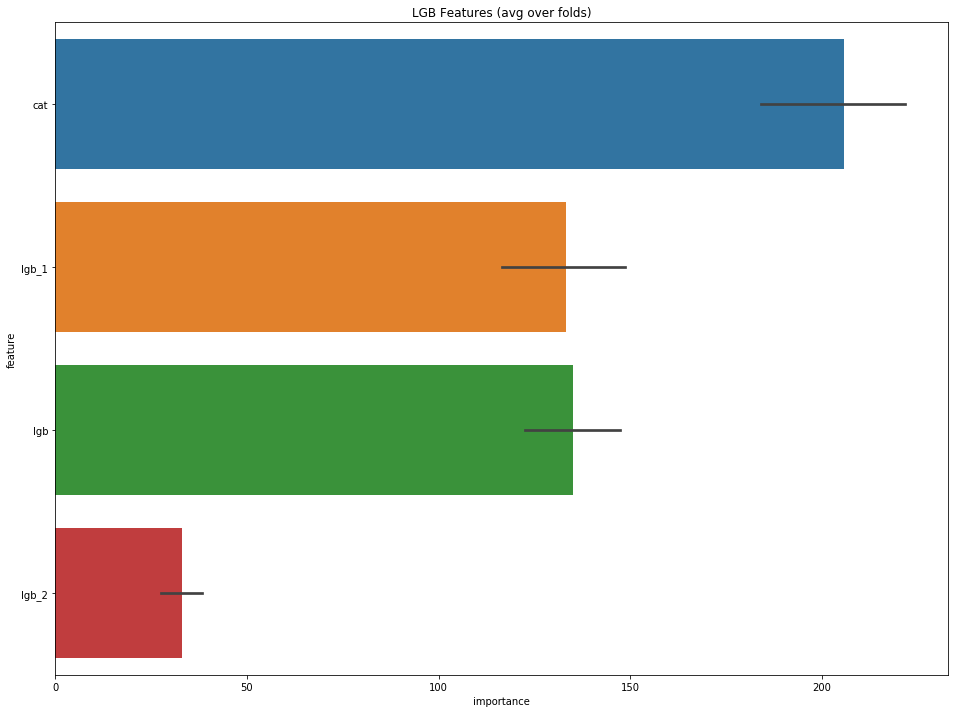

In [190]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:42:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[728]	training's rmse: 2.58318	valid_1's rmse: 2.25964
Fold 1 started at Tue Dec 17 12:42:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[353]	training's rmse: 2.56655	valid_1's rmse: 3.33586
Fold 2 started at Tue Dec 17 12:42:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[322]	training's rmse: 2.66321	valid_1's rmse: 2.91178
Fold 3 started at Tue Dec 17 12:42:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[453]	training's rmse: 2.60359	valid_1's rmse: 3.09297
Fold 4 started at Tue Dec 17 12:42:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[213]	training's rmse: 2.74064	valid_1's rmse: 4.21168
Fold 5 started at Tu

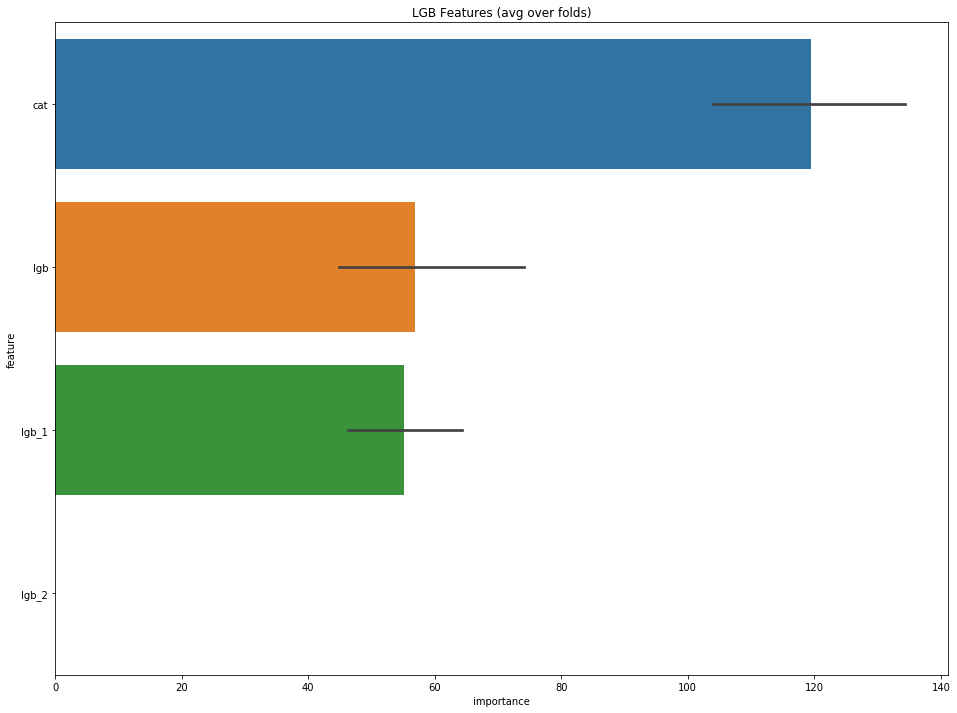

In [191]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [192]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:42:59 2019
Fold 1 started at Tue Dec 17 12:43:07 2019
Fold 2 started at Tue Dec 17 12:43:13 2019
Fold 3 started at Tue Dec 17 12:43:18 2019
Fold 4 started at Tue Dec 17 12:43:24 2019
Fold 5 started at Tue Dec 17 12:43:26 2019
Fold 6 started at Tue Dec 17 12:43:31 2019
Fold 7 started at Tue Dec 17 12:43:35 2019
Fold 8 started at Tue Dec 17 12:43:39 2019
Fold 9 started at Tue Dec 17 12:43:46 2019
CV mean score: 2.9639, std: 0.5585.


##### randomforest作为第二层融合模型

In [193]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:43:51 2019
Fold 1 started at Tue Dec 17 12:43:51 2019
Fold 2 started at Tue Dec 17 12:43:51 2019
Fold 3 started at Tue Dec 17 12:43:51 2019
Fold 4 started at Tue Dec 17 12:43:52 2019
Fold 5 started at Tue Dec 17 12:43:52 2019
Fold 6 started at Tue Dec 17 12:43:52 2019
Fold 7 started at Tue Dec 17 12:43:52 2019
Fold 8 started at Tue Dec 17 12:43:52 2019
Fold 9 started at Tue Dec 17 12:43:53 2019
CV mean score: 3.0530, std: 0.6058.


##### xgboost作为第二层融合模型

In [194]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:43:53 2019
[0]	train-rmse:23.8347	valid_data-rmse:21.8406
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.50731	valid_data-rmse:2.53233
Stopping. Best iteration:
[413]	train-rmse:1.75118	valid_data-rmse:2.52413

Fold 1 started at Tue Dec 17 12:43:53 2019
[0]	train-rmse:23.708	valid_data-rmse:23.0485
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.51418	valid_data-rmse:3.36796
Stopping. Best iteration:
[555]	train-rmse:1.42226	valid_data-rmse:3.36041

Fold 2 started at Tue Dec 17 12:43:54 2019
[0]	train-rmse:23.7749	valid_data-rmse:22.4277
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

##### svr 作为第二层融合模型

In [195]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:43:55 2019
Fold 1 started at Tue Dec 17 12:43:55 2019
Fold 2 started at Tue Dec 17 12:43:55 2019
Fold 3 started at Tue Dec 17 12:43:55 2019
Fold 4 started at Tue Dec 17 12:43:55 2019
Fold 5 started at Tue Dec 17 12:43:55 2019
Fold 6 started at Tue Dec 17 12:43:55 2019
Fold 7 started at Tue Dec 17 12:43:55 2019
Fold 8 started at Tue Dec 17 12:43:55 2019
Fold 9 started at Tue Dec 17 12:43:55 2019
CV mean score: 6.9176, std: 0.6689.


##### 岭回归做第二层融合模型

In [196]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:43:55 2019
Fold 1 started at Tue Dec 17 12:43:56 2019
Fold 2 started at Tue Dec 17 12:43:56 2019
Fold 3 started at Tue Dec 17 12:43:56 2019
Fold 4 started at Tue Dec 17 12:43:56 2019
Fold 5 started at Tue Dec 17 12:43:56 2019
Fold 6 started at Tue Dec 17 12:43:56 2019
Fold 7 started at Tue Dec 17 12:43:56 2019
Fold 8 started at Tue Dec 17 12:43:56 2019
Fold 9 started at Tue Dec 17 12:43:56 2019
CV mean score: 2.8919, std: 0.5066.


#### 留下lgb和rfr

In [197]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:43:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[511]	training's rmse: 2.63499	valid_1's rmse: 2.28275
Fold 1 started at Tue Dec 17 12:43:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 2.50543	valid_1's rmse: 3.21681
Fold 2 started at Tue Dec 17 12:44:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[473]	training's rmse: 2.61991	valid_1's rmse: 2.73705
Fold 3 started at Tue Dec 17 12:44:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 2.63745	valid_1's rmse: 3.12618
Fold 4 started at Tue Dec 17 12:44:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[201]	training's rmse: 2.80485	valid_1's rmse: 4.32254
Fold 5 started at Tu

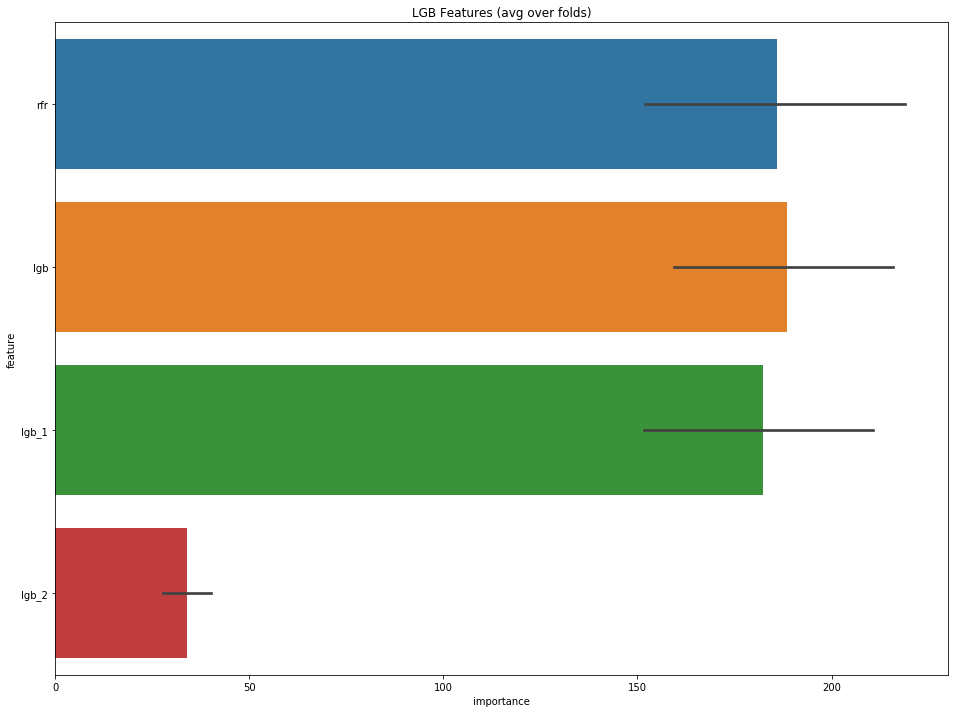

In [198]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:44:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[557]	training's rmse: 2.74069	valid_1's rmse: 2.20453
Fold 1 started at Tue Dec 17 12:44:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.55521	valid_1's rmse: 3.25284
Early stopping, best iteration is:
[1064]	training's rmse: 2.54297	valid_1's rmse: 3.24756
Fold 2 started at Tue Dec 17 12:44:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 2.74469	valid_1's rmse: 2.75452
Fold 3 started at Tue Dec 17 12:44:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 2.64556	valid_1's rmse: 3.04515
Fold 4 started at Tue Dec 17 12:44:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[209]	training's r

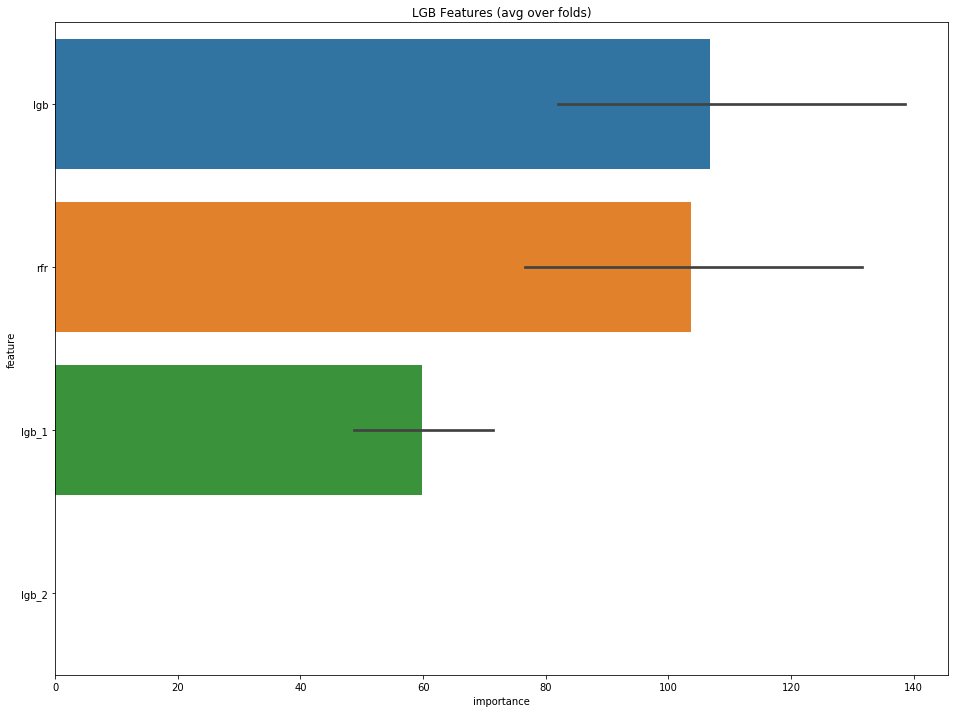

In [199]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:44:07 2019
Fold 1 started at Tue Dec 17 12:44:10 2019
Fold 2 started at Tue Dec 17 12:44:12 2019
Fold 3 started at Tue Dec 17 12:44:14 2019
Fold 4 started at Tue Dec 17 12:44:18 2019
Fold 5 started at Tue Dec 17 12:44:19 2019
Fold 6 started at Tue Dec 17 12:44:20 2019
Fold 7 started at Tue Dec 17 12:44:22 2019
Fold 8 started at Tue Dec 17 12:44:24 2019
Fold 9 started at Tue Dec 17 12:44:29 2019
CV mean score: 3.0548, std: 0.6629.


##### randomforest作为第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:44:30 2019
Fold 1 started at Tue Dec 17 12:44:31 2019
Fold 2 started at Tue Dec 17 12:44:31 2019
Fold 3 started at Tue Dec 17 12:44:31 2019
Fold 4 started at Tue Dec 17 12:44:31 2019
Fold 5 started at Tue Dec 17 12:44:31 2019
Fold 6 started at Tue Dec 17 12:44:32 2019
Fold 7 started at Tue Dec 17 12:44:32 2019
Fold 8 started at Tue Dec 17 12:44:32 2019
Fold 9 started at Tue Dec 17 12:44:32 2019
CV mean score: 3.1419, std: 0.6113.


##### xgboost作为第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:44:33 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.8395
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.47	valid_data-rmse:2.43977
Stopping. Best iteration:
[526]	train-rmse:1.42789	valid_data-rmse:2.43455

Fold 1 started at Tue Dec 17 12:44:33 2019
[0]	train-rmse:23.7079	valid_data-rmse:23.0497
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.48157	valid_data-rmse:3.48762
Stopping. Best iteration:
[656]	train-rmse:1.24406	valid_data-rmse:3.47579

Fold 2 started at Tue Dec 17 12:44:33 2019
[0]	train-rmse:23.7745	valid_data-rmse:22.4254
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:44:35 2019
Fold 1 started at Tue Dec 17 12:44:35 2019
Fold 2 started at Tue Dec 17 12:44:35 2019
Fold 3 started at Tue Dec 17 12:44:35 2019
Fold 4 started at Tue Dec 17 12:44:35 2019
Fold 5 started at Tue Dec 17 12:44:35 2019
Fold 6 started at Tue Dec 17 12:44:35 2019
Fold 7 started at Tue Dec 17 12:44:35 2019
Fold 8 started at Tue Dec 17 12:44:35 2019
Fold 9 started at Tue Dec 17 12:44:35 2019
CV mean score: 6.8241, std: 0.7191.


##### 岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:44:35 2019
Fold 1 started at Tue Dec 17 12:44:35 2019
Fold 2 started at Tue Dec 17 12:44:35 2019
Fold 3 started at Tue Dec 17 12:44:35 2019
Fold 4 started at Tue Dec 17 12:44:35 2019
Fold 5 started at Tue Dec 17 12:44:35 2019
Fold 6 started at Tue Dec 17 12:44:35 2019
Fold 7 started at Tue Dec 17 12:44:36 2019
Fold 8 started at Tue Dec 17 12:44:36 2019
Fold 9 started at Tue Dec 17 12:44:36 2019
CV mean score: 3.0290, std: 0.7017.


#### 留下lgb和svr

In [205]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:44:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 2.57498	valid_1's rmse: 2.46116
Fold 1 started at Tue Dec 17 12:44:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[497]	training's rmse: 2.50959	valid_1's rmse: 3.38295
Fold 2 started at Tue Dec 17 12:44:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[637]	training's rmse: 2.47025	valid_1's rmse: 2.72235
Fold 3 started at Tue Dec 17 12:44:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[437]	training's rmse: 2.58518	valid_1's rmse: 3.16921
Fold 4 started at Tue Dec 17 12:44:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[192]	training's rmse: 2.9109	valid_1's rmse: 4.39649
Fold 5 started at Tue

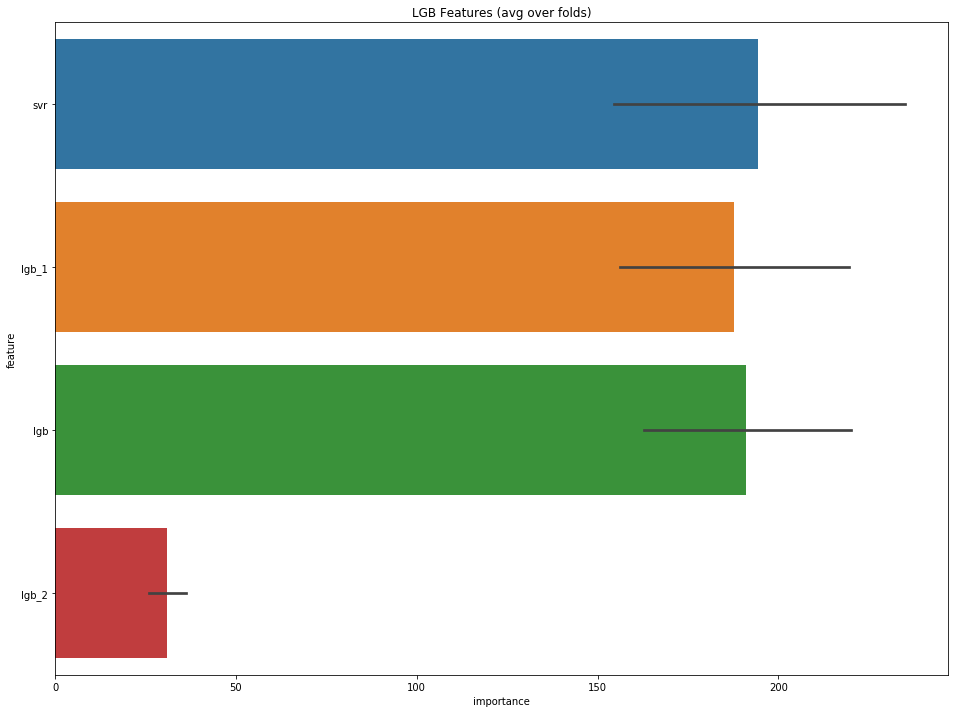

In [206]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:44:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.6109	valid_1's rmse: 2.37967
Early stopping, best iteration is:
[1128]	training's rmse: 2.58493	valid_1's rmse: 2.37853
Fold 1 started at Tue Dec 17 12:44:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[640]	training's rmse: 2.61668	valid_1's rmse: 3.37858
Fold 2 started at Tue Dec 17 12:44:40 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.57091	valid_1's rmse: 2.73272
Early stopping, best iteration is:
[848]	training's rmse: 2.6004	valid_1's rmse: 2.72141
Fold 3 started at Tue Dec 17 12:44:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 2.79116	valid_1's rmse: 3.12255
Fold 4 started at Tue Dec 17 12:44:40 2019
Training until validation scores don't improve for 200 rounds.

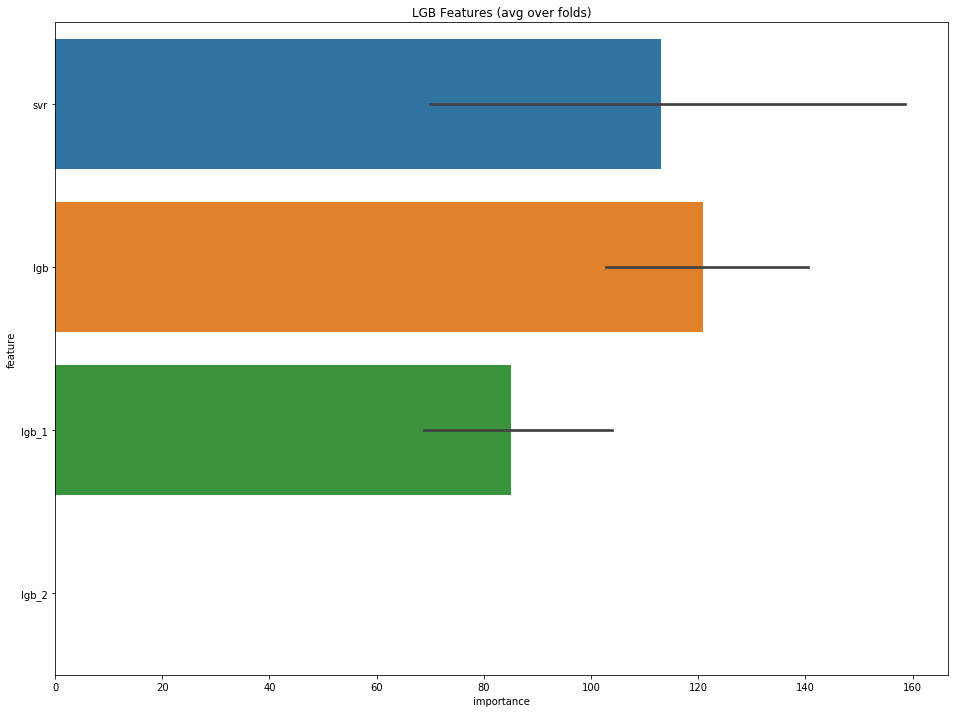

In [207]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [208]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:44:42 2019
Fold 1 started at Tue Dec 17 12:44:45 2019
Fold 2 started at Tue Dec 17 12:44:47 2019
Fold 3 started at Tue Dec 17 12:44:50 2019
Fold 4 started at Tue Dec 17 12:44:53 2019
Fold 5 started at Tue Dec 17 12:44:55 2019
Fold 6 started at Tue Dec 17 12:44:56 2019
Fold 7 started at Tue Dec 17 12:44:59 2019
Fold 8 started at Tue Dec 17 12:45:00 2019
Fold 9 started at Tue Dec 17 12:45:03 2019
CV mean score: 3.0409, std: 0.5752.


##### randomforest作为第二层融合模型

In [209]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:45:11 2019
Fold 1 started at Tue Dec 17 12:45:11 2019
Fold 2 started at Tue Dec 17 12:45:11 2019
Fold 3 started at Tue Dec 17 12:45:11 2019
Fold 4 started at Tue Dec 17 12:45:12 2019
Fold 5 started at Tue Dec 17 12:45:12 2019
Fold 6 started at Tue Dec 17 12:45:12 2019
Fold 7 started at Tue Dec 17 12:45:12 2019
Fold 8 started at Tue Dec 17 12:45:13 2019
Fold 9 started at Tue Dec 17 12:45:13 2019
CV mean score: 3.1093, std: 0.5345.


##### xgboost作为第二层融合模型

In [210]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:45:13 2019
[0]	train-rmse:23.8355	valid_data-rmse:21.84
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.4487	valid_data-rmse:2.48392
Stopping. Best iteration:
[544]	train-rmse:1.35614	valid_data-rmse:2.47255

Fold 1 started at Tue Dec 17 12:45:13 2019
[0]	train-rmse:23.708	valid_data-rmse:23.0483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.42612	valid_data-rmse:3.53755
Stopping. Best iteration:
[445]	train-rmse:1.56909	valid_data-rmse:3.5304

Fold 2 started at Tue Dec 17 12:45:14 2019
[0]	train-rmse:23.7742	valid_data-rmse:22.426
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1

##### svr 作为第二层融合模型

In [211]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:45:16 2019
Fold 1 started at Tue Dec 17 12:45:16 2019
Fold 2 started at Tue Dec 17 12:45:16 2019
Fold 3 started at Tue Dec 17 12:45:16 2019
Fold 4 started at Tue Dec 17 12:45:16 2019
Fold 5 started at Tue Dec 17 12:45:16 2019
Fold 6 started at Tue Dec 17 12:45:16 2019
Fold 7 started at Tue Dec 17 12:45:16 2019
Fold 8 started at Tue Dec 17 12:45:16 2019
Fold 9 started at Tue Dec 17 12:45:16 2019
CV mean score: 6.1009, std: 0.5862.


##### 岭回归做第二层融合模型

In [212]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:45:16 2019
Fold 1 started at Tue Dec 17 12:45:16 2019
Fold 2 started at Tue Dec 17 12:45:16 2019
Fold 3 started at Tue Dec 17 12:45:16 2019
Fold 4 started at Tue Dec 17 12:45:16 2019
Fold 5 started at Tue Dec 17 12:45:16 2019
Fold 6 started at Tue Dec 17 12:45:16 2019
Fold 7 started at Tue Dec 17 12:45:16 2019
Fold 8 started at Tue Dec 17 12:45:16 2019
Fold 9 started at Tue Dec 17 12:45:16 2019
CV mean score: 3.0006, std: 0.6799.


#### 留下lgb和xgb

In [213]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:45:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[450]	training's rmse: 2.53187	valid_1's rmse: 2.43128
Fold 1 started at Tue Dec 17 12:45:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.29705	valid_1's rmse: 2.59784
Early stopping, best iteration is:
[1376]	training's rmse: 2.21301	valid_1's rmse: 2.58904
Fold 2 started at Tue Dec 17 12:45:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 2.51493	valid_1's rmse: 2.88819
Fold 3 started at Tue Dec 17 12:45:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[531]	training's rmse: 2.43801	valid_1's rmse: 2.86371
Fold 4 started at Tue Dec 17 12:45:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[196]	training's r

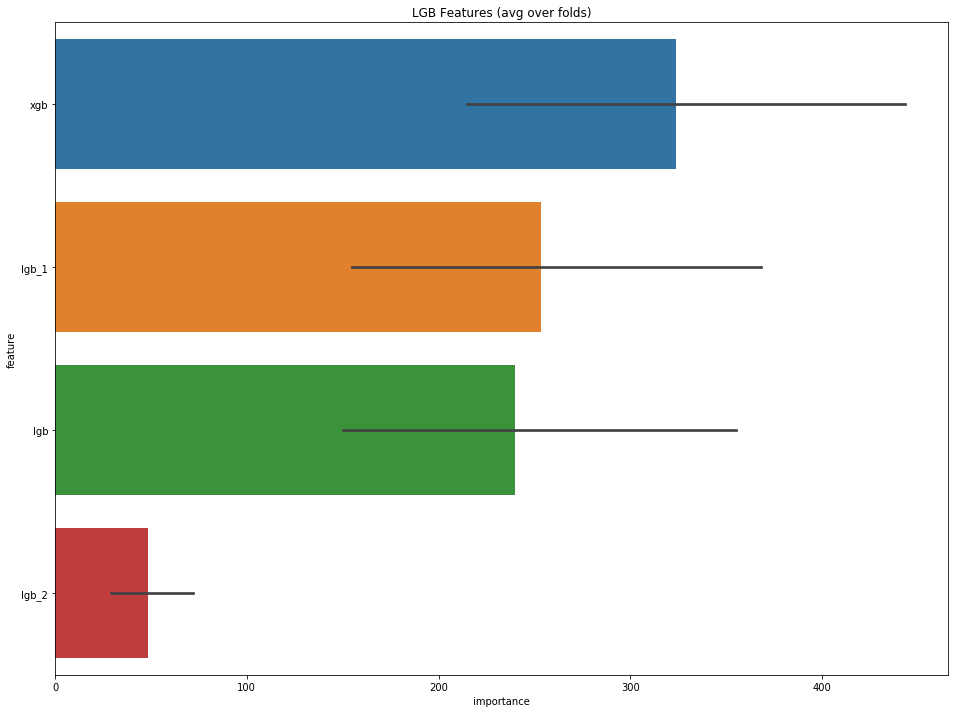

In [214]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:45:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[755]	training's rmse: 2.58233	valid_1's rmse: 2.28446
Fold 1 started at Tue Dec 17 12:45:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[465]	training's rmse: 2.57868	valid_1's rmse: 2.57711
Fold 2 started at Tue Dec 17 12:45:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[363]	training's rmse: 2.57071	valid_1's rmse: 2.94107
Fold 3 started at Tue Dec 17 12:45:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.49362	valid_1's rmse: 2.80523
[2000]	training's rmse: 2.43552	valid_1's rmse: 2.7929
[3000]	training's rmse: 2.39306	valid_1's rmse: 2.77375
[4000]	training's rmse: 2.34628	valid_1's rmse: 2.78289
Early stopping, best iteration is:
[3893]	training's rmse: 2.36411	valid_1's rmse: 

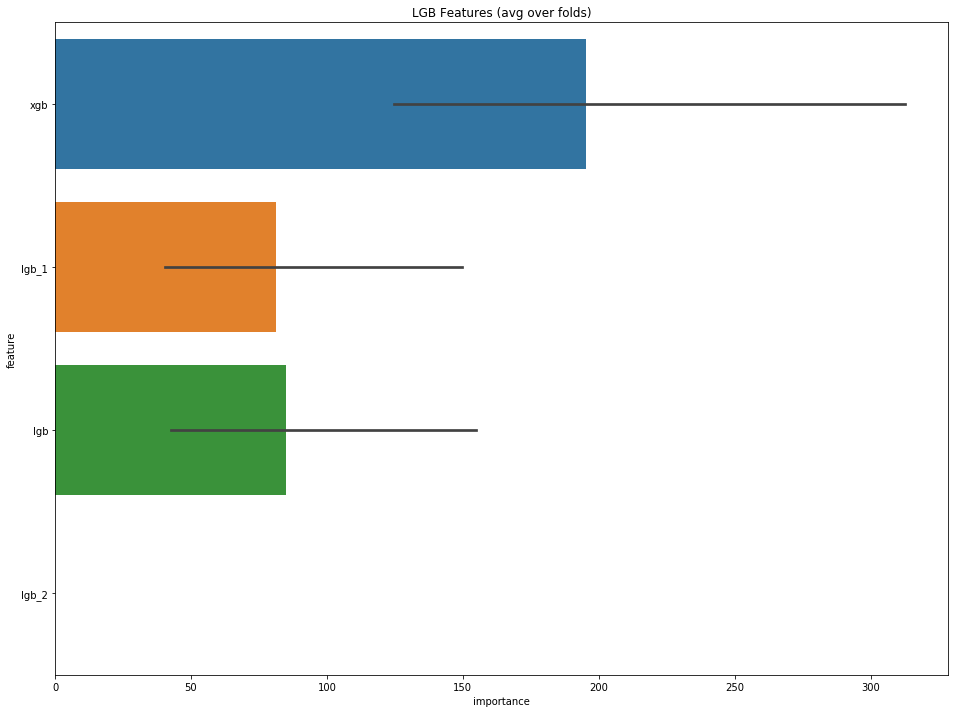

In [215]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:45:24 2019
Fold 1 started at Tue Dec 17 12:45:27 2019
Fold 2 started at Tue Dec 17 12:45:29 2019
Fold 3 started at Tue Dec 17 12:45:31 2019
Fold 4 started at Tue Dec 17 12:45:34 2019
Fold 5 started at Tue Dec 17 12:45:35 2019
Fold 6 started at Tue Dec 17 12:45:37 2019
Fold 7 started at Tue Dec 17 12:45:39 2019
Fold 8 started at Tue Dec 17 12:45:41 2019
Fold 9 started at Tue Dec 17 12:45:45 2019
CV mean score: 2.9237, std: 0.5699.


##### randomforest作为第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:45:48 2019
Fold 1 started at Tue Dec 17 12:45:48 2019
Fold 2 started at Tue Dec 17 12:45:48 2019
Fold 3 started at Tue Dec 17 12:45:48 2019
Fold 4 started at Tue Dec 17 12:45:49 2019
Fold 5 started at Tue Dec 17 12:45:49 2019
Fold 6 started at Tue Dec 17 12:45:49 2019
Fold 7 started at Tue Dec 17 12:45:49 2019
Fold 8 started at Tue Dec 17 12:45:50 2019
Fold 9 started at Tue Dec 17 12:45:50 2019
CV mean score: 2.9944, std: 0.5808.


##### xgboost作为第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:45:50 2019
[0]	train-rmse:23.835	valid_data-rmse:21.8414
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.46843	valid_data-rmse:2.29462
Stopping. Best iteration:
[558]	train-rmse:1.37439	valid_data-rmse:2.28882

Fold 1 started at Tue Dec 17 12:45:50 2019
[0]	train-rmse:23.7085	valid_data-rmse:23.0499
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.47108	valid_data-rmse:2.9749
Stopping. Best iteration:
[526]	train-rmse:1.42613	valid_data-rmse:2.97383

Fold 2 started at Tue Dec 17 12:45:51 2019
[0]	train-rmse:23.7742	valid_data-rmse:22.4252
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:45:52 2019
Fold 1 started at Tue Dec 17 12:45:52 2019
Fold 2 started at Tue Dec 17 12:45:52 2019
Fold 3 started at Tue Dec 17 12:45:52 2019
Fold 4 started at Tue Dec 17 12:45:52 2019
Fold 5 started at Tue Dec 17 12:45:52 2019
Fold 6 started at Tue Dec 17 12:45:52 2019
Fold 7 started at Tue Dec 17 12:45:52 2019
Fold 8 started at Tue Dec 17 12:45:52 2019
Fold 9 started at Tue Dec 17 12:45:53 2019
CV mean score: 6.8127, std: 0.6524.


##### 岭回归做第二层融合模型

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:45:53 2019
Fold 1 started at Tue Dec 17 12:45:53 2019
Fold 2 started at Tue Dec 17 12:45:53 2019
Fold 3 started at Tue Dec 17 12:45:53 2019
Fold 4 started at Tue Dec 17 12:45:53 2019
Fold 5 started at Tue Dec 17 12:45:53 2019
Fold 6 started at Tue Dec 17 12:45:53 2019
Fold 7 started at Tue Dec 17 12:45:53 2019
Fold 8 started at Tue Dec 17 12:45:53 2019
Fold 9 started at Tue Dec 17 12:45:53 2019
CV mean score: 2.8168, std: 0.5383.


#### 只留下cat

In [221]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:45:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[537]	training's rmse: 2.71464	valid_1's rmse: 2.1889
Fold 1 started at Tue Dec 17 12:45:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[636]	training's rmse: 2.58353	valid_1's rmse: 3.3075
Fold 2 started at Tue Dec 17 12:45:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 2.71993	valid_1's rmse: 2.95656
Fold 3 started at Tue Dec 17 12:45:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[669]	training's rmse: 2.66318	valid_1's rmse: 2.81735
Fold 4 started at Tue Dec 17 12:45:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 2.73158	valid_1's rmse: 3.77814
Fold 5 started at Tue 

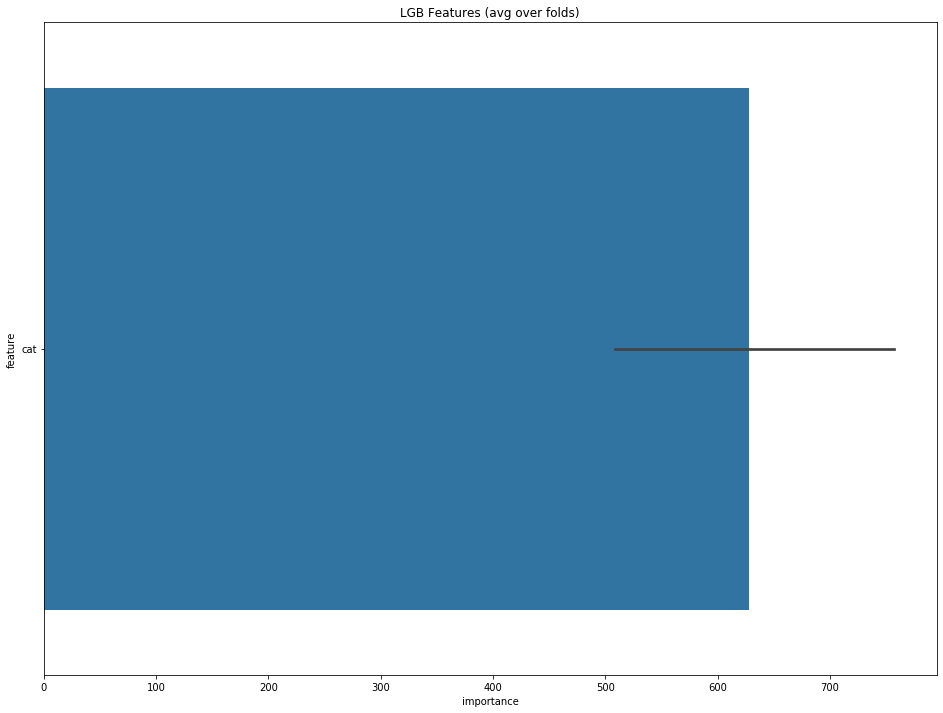

In [222]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:45:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[669]	training's rmse: 2.75003	valid_1's rmse: 2.17015
Fold 1 started at Tue Dec 17 12:45:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[465]	training's rmse: 2.64573	valid_1's rmse: 3.30646
Fold 2 started at Tue Dec 17 12:45:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[382]	training's rmse: 2.73201	valid_1's rmse: 2.9301
Fold 3 started at Tue Dec 17 12:45:58 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.70838	valid_1's rmse: 2.81416
Early stopping, best iteration is:
[812]	training's rmse: 2.72049	valid_1's rmse: 2.81118
Fold 4 started at Tue Dec 17 12:45:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[287]	training's rms

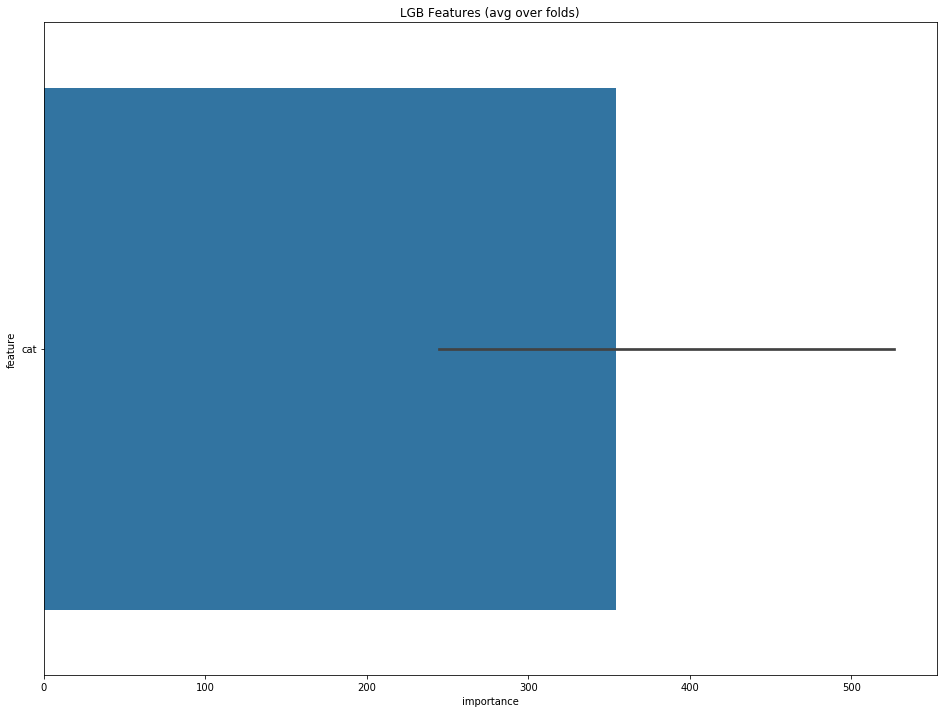

In [223]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [224]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:46:00 2019
Fold 1 started at Tue Dec 17 12:46:02 2019
Fold 2 started at Tue Dec 17 12:46:05 2019
Fold 3 started at Tue Dec 17 12:46:06 2019
Fold 4 started at Tue Dec 17 12:46:09 2019
Fold 5 started at Tue Dec 17 12:46:12 2019
Fold 6 started at Tue Dec 17 12:46:14 2019
Fold 7 started at Tue Dec 17 12:46:16 2019
Fold 8 started at Tue Dec 17 12:46:18 2019
Fold 9 started at Tue Dec 17 12:46:24 2019
CV mean score: 2.8946, std: 0.4139.


##### randomforest作为第二层融合模型

In [225]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:46:25 2019
Fold 1 started at Tue Dec 17 12:46:25 2019
Fold 2 started at Tue Dec 17 12:46:26 2019
Fold 3 started at Tue Dec 17 12:46:26 2019
Fold 4 started at Tue Dec 17 12:46:26 2019
Fold 5 started at Tue Dec 17 12:46:26 2019
Fold 6 started at Tue Dec 17 12:46:27 2019
Fold 7 started at Tue Dec 17 12:46:27 2019
Fold 8 started at Tue Dec 17 12:46:27 2019
Fold 9 started at Tue Dec 17 12:46:27 2019
CV mean score: 3.0873, std: 0.4180.


##### xgboost作为第二层融合模型

In [226]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:46:27 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.841
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.89894	valid_data-rmse:2.70423
Stopping. Best iteration:
[493]	train-rmse:1.91245	valid_data-rmse:2.69868

Fold 1 started at Tue Dec 17 12:46:28 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.88369	valid_data-rmse:3.2783
[1000]	train-rmse:1.36389	valid_data-rmse:3.22465
[1500]	train-rmse:1.04509	valid_data-rmse:3.19569
[2000]	train-rmse:0.823557	valid_data-rmse:3.18061
[2500]	train-rmse:0.65597	valid_data-rmse:3.16817
Stopping. Best iteration:
[2559]	train-rmse:0.640238	valid_data-rmse:3.16594

Fold 2 started at Tue Dec 17 12:46:28 2019
[0]	train-rmse

##### svr 作为第二层融合模型

In [227]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:46:29 2019
Fold 1 started at Tue Dec 17 12:46:29 2019
Fold 2 started at Tue Dec 17 12:46:30 2019
Fold 3 started at Tue Dec 17 12:46:30 2019
Fold 4 started at Tue Dec 17 12:46:30 2019
Fold 5 started at Tue Dec 17 12:46:30 2019
Fold 6 started at Tue Dec 17 12:46:30 2019
Fold 7 started at Tue Dec 17 12:46:30 2019
Fold 8 started at Tue Dec 17 12:46:30 2019
Fold 9 started at Tue Dec 17 12:46:30 2019
CV mean score: 5.8019, std: 0.4811.


##### 岭回归做第二层融合模型

In [228]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:46:30 2019
Fold 1 started at Tue Dec 17 12:46:30 2019
Fold 2 started at Tue Dec 17 12:46:30 2019
Fold 3 started at Tue Dec 17 12:46:30 2019
Fold 4 started at Tue Dec 17 12:46:30 2019
Fold 5 started at Tue Dec 17 12:46:30 2019
Fold 6 started at Tue Dec 17 12:46:30 2019
Fold 7 started at Tue Dec 17 12:46:30 2019
Fold 8 started at Tue Dec 17 12:46:30 2019
Fold 9 started at Tue Dec 17 12:46:30 2019
CV mean score: 2.8859, std: 0.4463.


#### 只留下rfr

In [229]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:46:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.26368	valid_1's rmse: 2.28419
Early stopping, best iteration is:
[809]	training's rmse: 3.2951	valid_1's rmse: 2.27824
Fold 1 started at Tue Dec 17 12:46:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[562]	training's rmse: 3.20343	valid_1's rmse: 4.07083
Fold 2 started at Tue Dec 17 12:46:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[367]	training's rmse: 3.35041	valid_1's rmse: 3.16022
Fold 3 started at Tue Dec 17 12:46:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.1954	valid_1's rmse: 3.52118
Early stopping, best iteration is:
[939]	training's rmse: 3.20405	valid_1's rmse: 3.51683
Fold 4 started at Tue Dec 17 12:46:32 2019
Training until validation scores don't improve for 200 rounds.


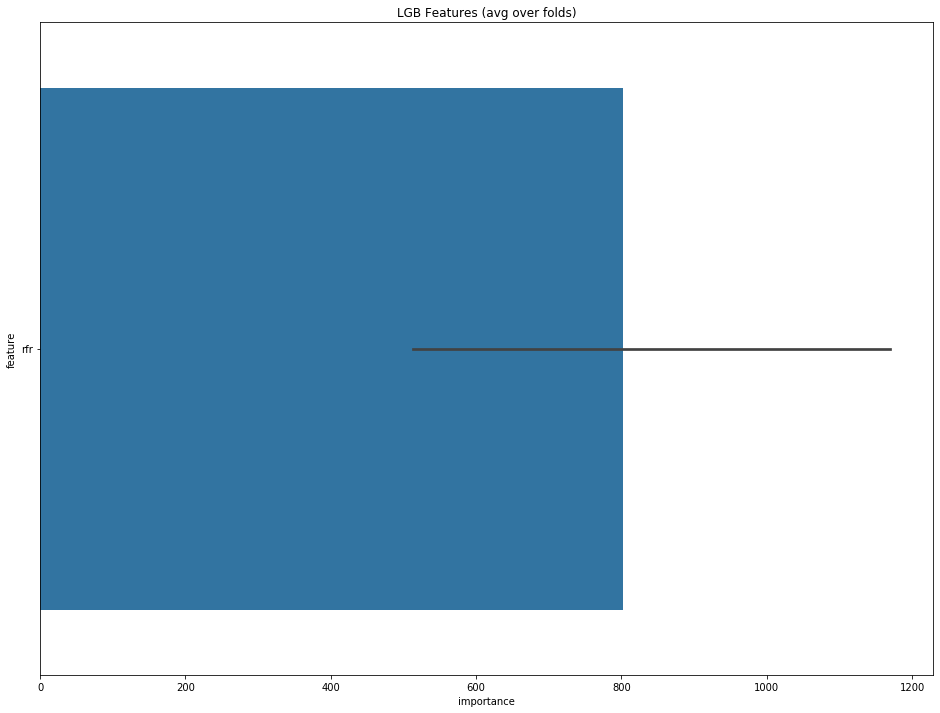

In [230]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:46:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[532]	training's rmse: 3.43622	valid_1's rmse: 2.25182
Fold 1 started at Tue Dec 17 12:46:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[480]	training's rmse: 3.28557	valid_1's rmse: 4.08234
Fold 2 started at Tue Dec 17 12:46:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[490]	training's rmse: 3.38051	valid_1's rmse: 3.19664
Fold 3 started at Tue Dec 17 12:46:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[704]	training's rmse: 3.34246	valid_1's rmse: 3.44776
Fold 4 started at Tue Dec 17 12:46:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 3.40589	valid_1's rmse: 4.06296
Fold 5 started at Tu

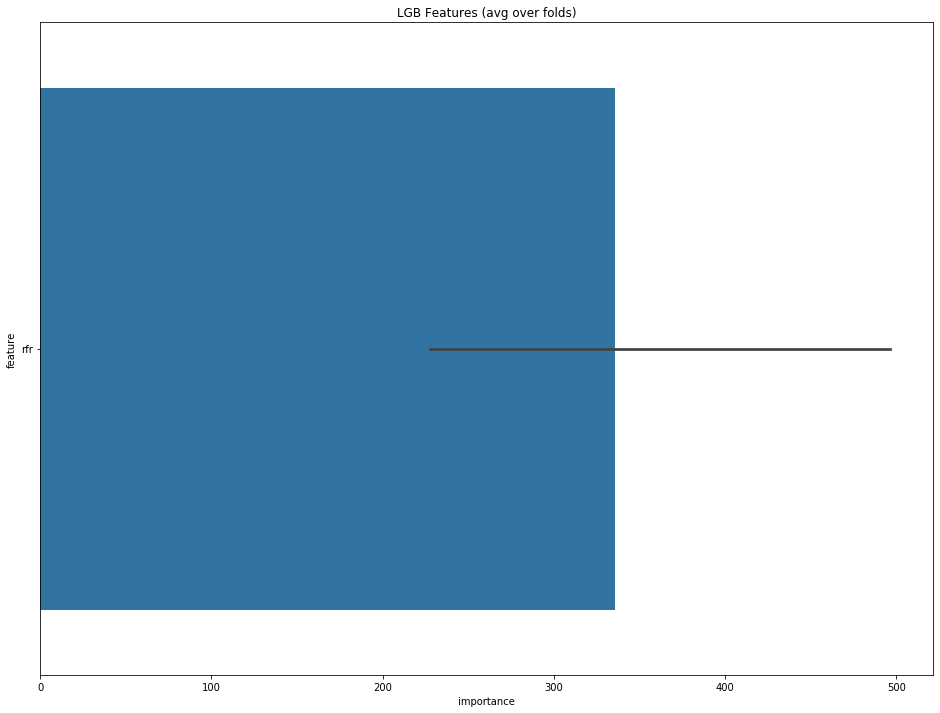

In [231]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [232]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:46:38 2019
Fold 1 started at Tue Dec 17 12:46:41 2019
Fold 2 started at Tue Dec 17 12:46:44 2019
Fold 3 started at Tue Dec 17 12:46:45 2019
Fold 4 started at Tue Dec 17 12:46:49 2019
Fold 5 started at Tue Dec 17 12:46:52 2019
Fold 6 started at Tue Dec 17 12:46:54 2019
Fold 7 started at Tue Dec 17 12:46:56 2019
Fold 8 started at Tue Dec 17 12:46:57 2019
Fold 9 started at Tue Dec 17 12:46:59 2019
CV mean score: 3.5102, std: 0.7626.


##### randomforest作为第二层融合模型

In [233]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:47:00 2019
Fold 1 started at Tue Dec 17 12:47:01 2019
Fold 2 started at Tue Dec 17 12:47:01 2019
Fold 3 started at Tue Dec 17 12:47:01 2019
Fold 4 started at Tue Dec 17 12:47:01 2019
Fold 5 started at Tue Dec 17 12:47:01 2019
Fold 6 started at Tue Dec 17 12:47:02 2019
Fold 7 started at Tue Dec 17 12:47:02 2019
Fold 8 started at Tue Dec 17 12:47:02 2019
Fold 9 started at Tue Dec 17 12:47:02 2019
CV mean score: 3.7351, std: 0.7226.


##### xgboost作为第二层融合模型

In [234]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:47:03 2019
[0]	train-rmse:23.8369	valid_data-rmse:21.838
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.22347	valid_data-rmse:2.67875
Stopping. Best iteration:
[384]	train-rmse:2.56152	valid_data-rmse:2.60694

Fold 1 started at Tue Dec 17 12:47:03 2019
[0]	train-rmse:23.7092	valid_data-rmse:23.0481
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.1545	valid_data-rmse:4.34077
Stopping. Best iteration:
[453]	train-rmse:2.24952	valid_data-rmse:4.33584

Fold 2 started at Tue Dec 17 12:47:03 2019
[0]	train-rmse:23.776	valid_data-rmse:22.4342
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

##### svr 作为第二层融合模型

In [235]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:47:04 2019
Fold 1 started at Tue Dec 17 12:47:04 2019
Fold 2 started at Tue Dec 17 12:47:04 2019
Fold 3 started at Tue Dec 17 12:47:04 2019
Fold 4 started at Tue Dec 17 12:47:04 2019
Fold 5 started at Tue Dec 17 12:47:04 2019
Fold 6 started at Tue Dec 17 12:47:04 2019
Fold 7 started at Tue Dec 17 12:47:04 2019
Fold 8 started at Tue Dec 17 12:47:04 2019
Fold 9 started at Tue Dec 17 12:47:04 2019
CV mean score: 5.6642, std: 0.5221.


##### 岭回归做第二层融合模型

In [236]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:47:04 2019
Fold 1 started at Tue Dec 17 12:47:04 2019
Fold 2 started at Tue Dec 17 12:47:04 2019
Fold 3 started at Tue Dec 17 12:47:04 2019
Fold 4 started at Tue Dec 17 12:47:04 2019
Fold 5 started at Tue Dec 17 12:47:04 2019
Fold 6 started at Tue Dec 17 12:47:04 2019
Fold 7 started at Tue Dec 17 12:47:04 2019
Fold 8 started at Tue Dec 17 12:47:05 2019
Fold 9 started at Tue Dec 17 12:47:05 2019
CV mean score: 3.5518, std: 0.7536.


#### 只留下svr

In [237]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 9.287	valid_1's rmse: 8.05251
Fold 1 started at Tue Dec 17 12:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[150]	training's rmse: 8.0136	valid_1's rmse: 8.51559
Fold 2 started at Tue Dec 17 12:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 9.20333	valid_1's rmse: 8.83583
Fold 3 started at Tue Dec 17 12:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[433]	training's rmse: 7.70621	valid_1's rmse: 7.762
Fold 4 started at Tue Dec 17 12:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[41]	training's rmse: 8.47399	valid_1's rmse: 9.70986
Fold 5 started at Tue Dec 17 1

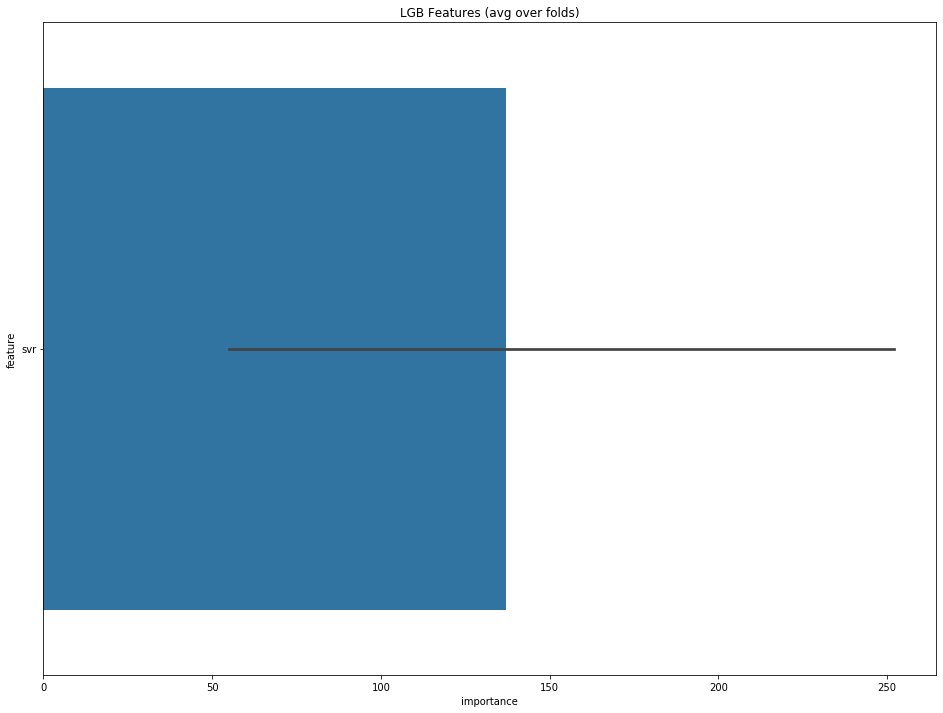

In [238]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:47:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[71]	training's rmse: 8.713	valid_1's rmse: 7.81146
Fold 1 started at Tue Dec 17 12:47:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[398]	training's rmse: 8.03773	valid_1's rmse: 8.47134
Fold 2 started at Tue Dec 17 12:47:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 9.21321	valid_1's rmse: 8.83545
Fold 3 started at Tue Dec 17 12:47:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 8.18764	valid_1's rmse: 7.66974
Fold 4 started at Tue Dec 17 12:47:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[17]	training's rmse: 8.89563	valid_1's rmse: 9.81887
Fold 5 started at Tue Dec 

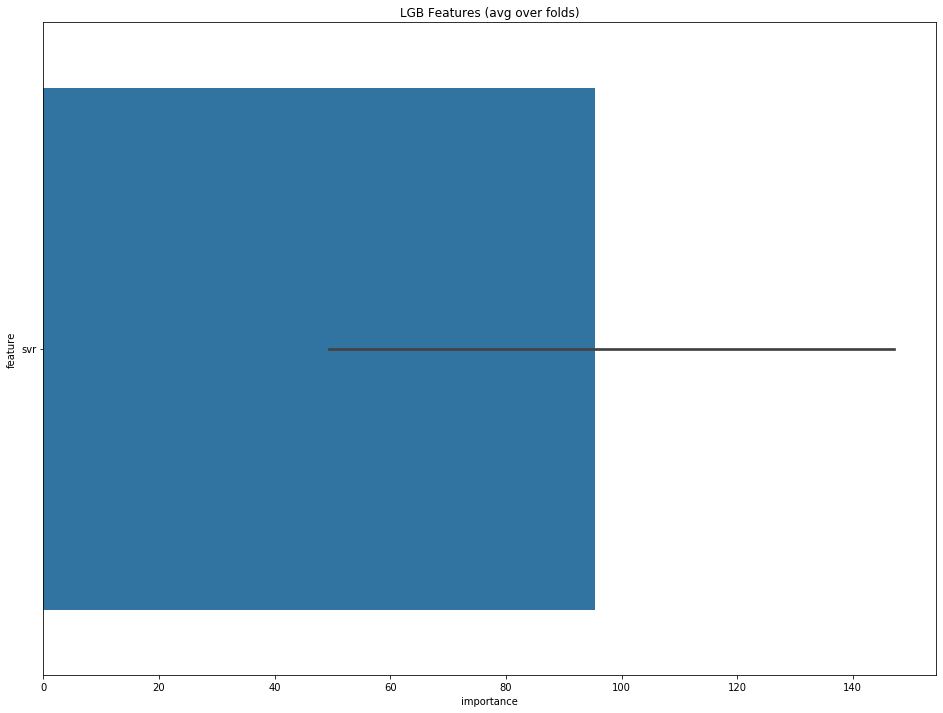

In [239]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [240]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:47:08 2019
Fold 1 started at Tue Dec 17 12:47:08 2019
Fold 2 started at Tue Dec 17 12:47:09 2019
Fold 3 started at Tue Dec 17 12:47:09 2019
Fold 4 started at Tue Dec 17 12:47:11 2019
Fold 5 started at Tue Dec 17 12:47:11 2019
Fold 6 started at Tue Dec 17 12:47:12 2019
Fold 7 started at Tue Dec 17 12:47:13 2019
Fold 8 started at Tue Dec 17 12:47:13 2019
Fold 9 started at Tue Dec 17 12:47:14 2019
CV mean score: 8.7350, std: 0.8131.


##### randomforest作为第二层融合模型

In [241]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:47:15 2019
Fold 1 started at Tue Dec 17 12:47:15 2019
Fold 2 started at Tue Dec 17 12:47:15 2019
Fold 3 started at Tue Dec 17 12:47:16 2019
Fold 4 started at Tue Dec 17 12:47:16 2019
Fold 5 started at Tue Dec 17 12:47:16 2019
Fold 6 started at Tue Dec 17 12:47:16 2019
Fold 7 started at Tue Dec 17 12:47:17 2019
Fold 8 started at Tue Dec 17 12:47:17 2019
Fold 9 started at Tue Dec 17 12:47:17 2019
CV mean score: 10.0477, std: 1.0224.


##### xgboost作为第二层融合模型

In [242]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:47:17 2019
[0]	train-rmse:23.8607	valid_data-rmse:21.8211
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[186]	train-rmse:8.50386	valid_data-rmse:7.71804

Fold 1 started at Tue Dec 17 12:47:17 2019
[0]	train-rmse:23.7323	valid_data-rmse:23.0597
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[287]	train-rmse:7.29465	valid_data-rmse:8.82121

Fold 2 started at Tue Dec 17 12:47:18 2019
[0]	train-rmse:23.7973	valid_data-rmse:22.3962
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[134]	train-rmse:9.87639	valid_data-rmse:8.77588

Fold 3 started at Tue Dec 17 12:47

##### svr 作为第二层融合模型

In [243]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:47:18 2019
Fold 1 started at Tue Dec 17 12:47:18 2019
Fold 2 started at Tue Dec 17 12:47:18 2019
Fold 3 started at Tue Dec 17 12:47:18 2019
Fold 4 started at Tue Dec 17 12:47:18 2019
Fold 5 started at Tue Dec 17 12:47:18 2019
Fold 6 started at Tue Dec 17 12:47:18 2019
Fold 7 started at Tue Dec 17 12:47:18 2019
Fold 8 started at Tue Dec 17 12:47:18 2019
Fold 9 started at Tue Dec 17 12:47:18 2019
CV mean score: 8.8930, std: 0.8313.


##### 岭回归做第二层融合模型

In [244]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:47:18 2019
Fold 1 started at Tue Dec 17 12:47:19 2019
Fold 2 started at Tue Dec 17 12:47:19 2019
Fold 3 started at Tue Dec 17 12:47:19 2019
Fold 4 started at Tue Dec 17 12:47:19 2019
Fold 5 started at Tue Dec 17 12:47:19 2019
Fold 6 started at Tue Dec 17 12:47:19 2019
Fold 7 started at Tue Dec 17 12:47:19 2019
Fold 8 started at Tue Dec 17 12:47:19 2019
Fold 9 started at Tue Dec 17 12:47:19 2019
CV mean score: 8.7559, std: 0.6925.


#### 只留下xgb

In [245]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:47:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[525]	training's rmse: 2.69868	valid_1's rmse: 2.20192
Fold 1 started at Tue Dec 17 12:47:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[397]	training's rmse: 2.66643	valid_1's rmse: 2.49966
Fold 2 started at Tue Dec 17 12:47:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[372]	training's rmse: 2.60644	valid_1's rmse: 2.98222
Fold 3 started at Tue Dec 17 12:47:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 2.60225	valid_1's rmse: 2.78669
Fold 4 started at Tue Dec 17 12:47:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[203]	training's rmse: 2.73383	valid_1's rmse: 4.18695
Fold 5 started at Tu

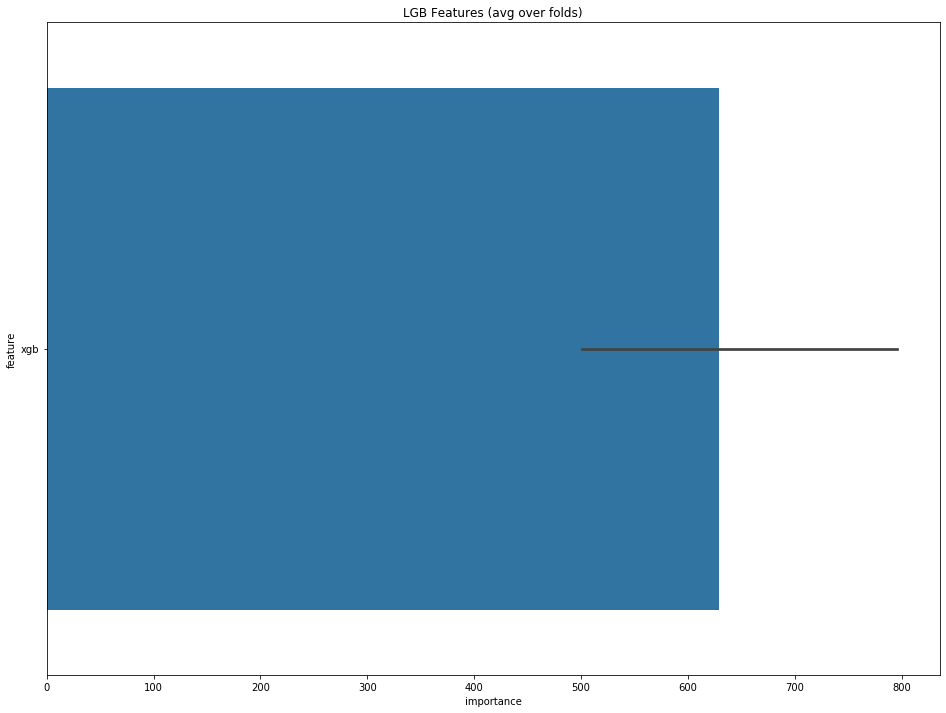

In [246]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:47:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[685]	training's rmse: 2.72608	valid_1's rmse: 2.16802
Fold 1 started at Tue Dec 17 12:47:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[660]	training's rmse: 2.68142	valid_1's rmse: 2.47344
Fold 2 started at Tue Dec 17 12:47:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[435]	training's rmse: 2.62685	valid_1's rmse: 2.96057
Fold 3 started at Tue Dec 17 12:47:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[605]	training's rmse: 2.64598	valid_1's rmse: 2.75865
Fold 4 started at Tue Dec 17 12:47:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[203]	training's rmse: 2.75739	valid_1's rmse: 4.21728
Fold 5 started at Tu

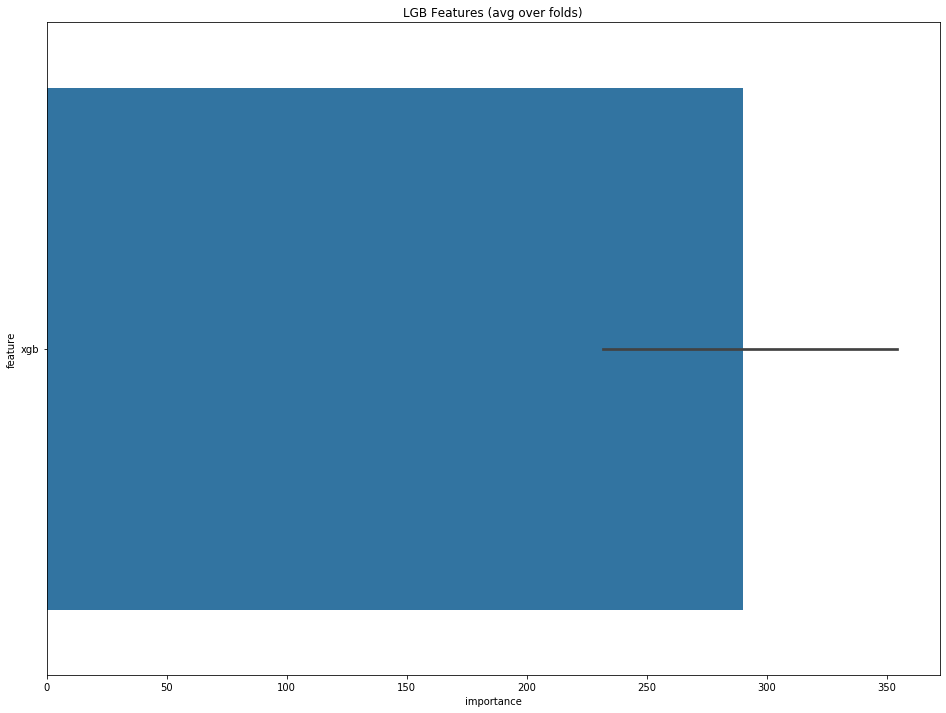

In [247]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [248]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:47:24 2019
Fold 1 started at Tue Dec 17 12:47:28 2019
Fold 2 started at Tue Dec 17 12:47:30 2019
Fold 3 started at Tue Dec 17 12:47:31 2019
Fold 4 started at Tue Dec 17 12:47:33 2019
Fold 5 started at Tue Dec 17 12:47:34 2019
Fold 6 started at Tue Dec 17 12:47:36 2019
Fold 7 started at Tue Dec 17 12:47:37 2019
Fold 8 started at Tue Dec 17 12:47:38 2019
Fold 9 started at Tue Dec 17 12:47:40 2019
CV mean score: 2.8034, std: 0.5078.


##### randomforest作为第二层融合模型

In [249]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:47:42 2019
Fold 1 started at Tue Dec 17 12:47:42 2019
Fold 2 started at Tue Dec 17 12:47:42 2019
Fold 3 started at Tue Dec 17 12:47:42 2019
Fold 4 started at Tue Dec 17 12:47:43 2019
Fold 5 started at Tue Dec 17 12:47:43 2019
Fold 6 started at Tue Dec 17 12:47:43 2019
Fold 7 started at Tue Dec 17 12:47:43 2019
Fold 8 started at Tue Dec 17 12:47:44 2019
Fold 9 started at Tue Dec 17 12:47:44 2019
CV mean score: 3.0334, std: 0.5500.


##### xgboost作为第二层融合模型

In [250]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:47:44 2019
[0]	train-rmse:23.8355	valid_data-rmse:21.8424
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.86789	valid_data-rmse:2.12779
Stopping. Best iteration:
[633]	train-rmse:1.71542	valid_data-rmse:2.11516

Fold 1 started at Tue Dec 17 12:47:44 2019
[0]	train-rmse:23.7078	valid_data-rmse:23.0446
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.83452	valid_data-rmse:2.84998
Stopping. Best iteration:
[545]	train-rmse:1.77519	valid_data-rmse:2.84506

Fold 2 started at Tue Dec 17 12:47:44 2019
[0]	train-rmse:23.7745	valid_data-rmse:22.426
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Bes

##### svr 作为第二层融合模型

In [251]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:47:46 2019
Fold 1 started at Tue Dec 17 12:47:46 2019
Fold 2 started at Tue Dec 17 12:47:46 2019
Fold 3 started at Tue Dec 17 12:47:46 2019
Fold 4 started at Tue Dec 17 12:47:46 2019
Fold 5 started at Tue Dec 17 12:47:46 2019
Fold 6 started at Tue Dec 17 12:47:46 2019
Fold 7 started at Tue Dec 17 12:47:46 2019
Fold 8 started at Tue Dec 17 12:47:46 2019
Fold 9 started at Tue Dec 17 12:47:46 2019
CV mean score: 5.7779, std: 0.5942.


##### 岭回归做第二层融合模型

In [252]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:47:46 2019
Fold 1 started at Tue Dec 17 12:47:46 2019
Fold 2 started at Tue Dec 17 12:47:46 2019
Fold 3 started at Tue Dec 17 12:47:46 2019
Fold 4 started at Tue Dec 17 12:47:46 2019
Fold 5 started at Tue Dec 17 12:47:46 2019
Fold 6 started at Tue Dec 17 12:47:46 2019
Fold 7 started at Tue Dec 17 12:47:46 2019
Fold 8 started at Tue Dec 17 12:47:46 2019
Fold 9 started at Tue Dec 17 12:47:46 2019
CV mean score: 2.8000, std: 0.5243.


#### 只留下lgb

In [253]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:47:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[401]	training's rmse: 2.87656	valid_1's rmse: 2.55888
Fold 1 started at Tue Dec 17 12:47:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[573]	training's rmse: 2.75793	valid_1's rmse: 3.22599
Fold 2 started at Tue Dec 17 12:47:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.70992	valid_1's rmse: 2.69032
[2000]	training's rmse: 2.56279	valid_1's rmse: 2.65672
Early stopping, best iteration is:
[2329]	training's rmse: 2.52888	valid_1's rmse: 2.63878
Fold 3 started at Tue Dec 17 12:47:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[437]	training's rmse: 2.81853	valid_1's rmse: 3.19169
Fold 4 started at Tue Dec 17 12:47:48 2019
Training until validation scores don't improve for 200 round

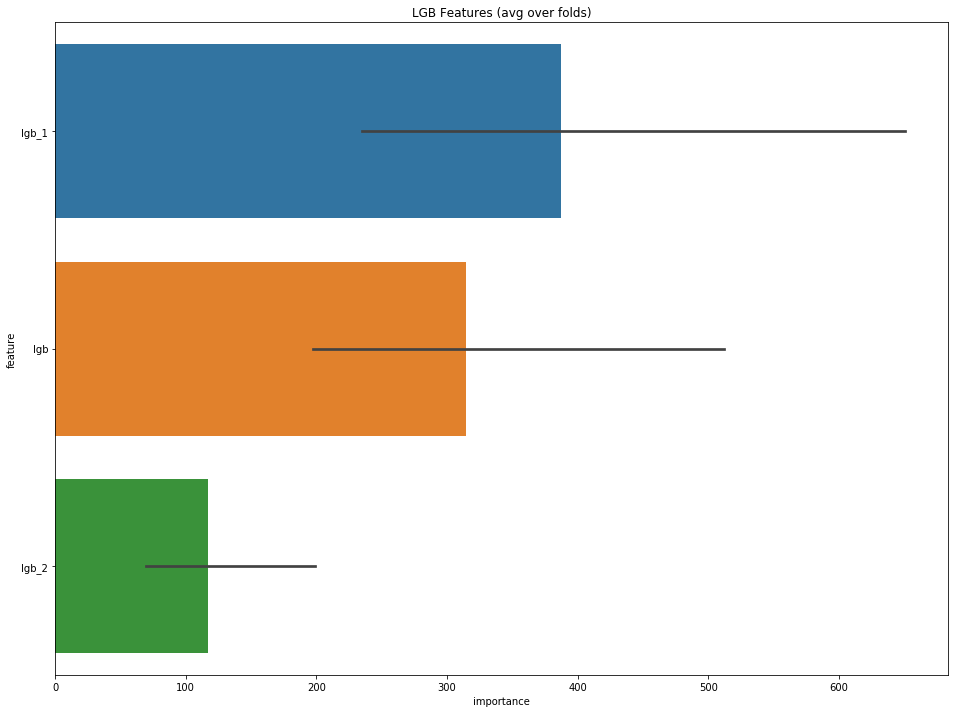

In [254]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:47:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[543]	training's rmse: 2.92399	valid_1's rmse: 2.48078
Fold 1 started at Tue Dec 17 12:47:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.78794	valid_1's rmse: 3.23418
Early stopping, best iteration is:
[1352]	training's rmse: 2.75461	valid_1's rmse: 3.22615
Fold 2 started at Tue Dec 17 12:47:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[686]	training's rmse: 2.88309	valid_1's rmse: 2.73118
Fold 3 started at Tue Dec 17 12:47:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[569]	training's rmse: 2.8663	valid_1's rmse: 3.15042
Fold 4 started at Tue Dec 17 12:47:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[198]	training's rm

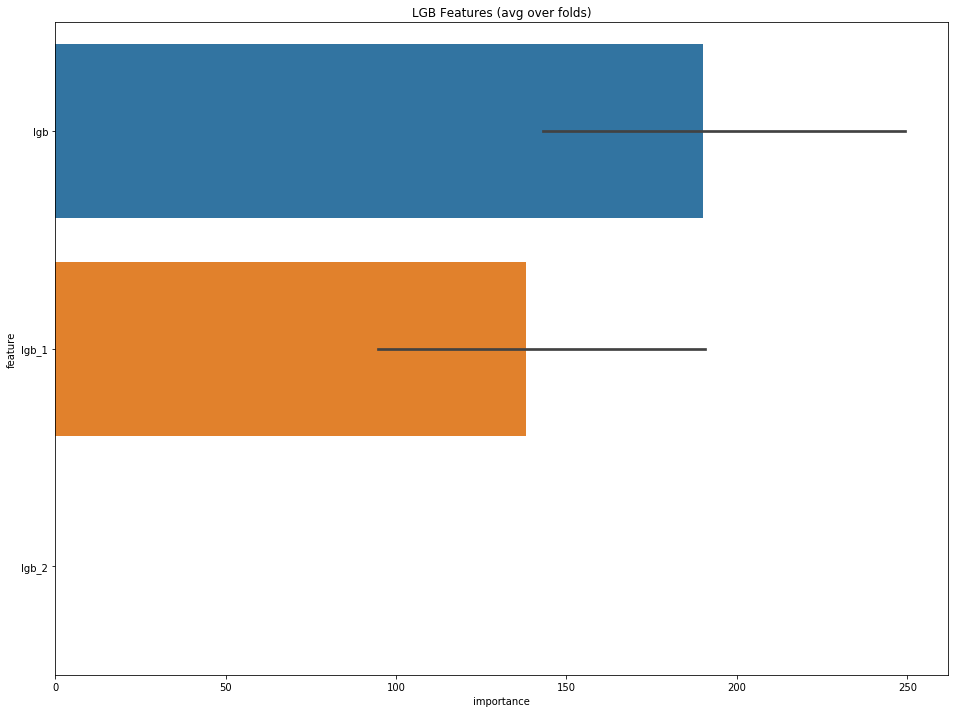

In [255]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [256]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:47:52 2019
Fold 1 started at Tue Dec 17 12:47:56 2019
Fold 2 started at Tue Dec 17 12:47:57 2019
Fold 3 started at Tue Dec 17 12:48:00 2019
Fold 4 started at Tue Dec 17 12:48:01 2019
Fold 5 started at Tue Dec 17 12:48:02 2019
Fold 6 started at Tue Dec 17 12:48:04 2019
Fold 7 started at Tue Dec 17 12:48:06 2019
Fold 8 started at Tue Dec 17 12:48:08 2019
Fold 9 started at Tue Dec 17 12:48:12 2019
CV mean score: 3.0465, std: 0.6393.


##### randomforest作为第二层融合模型

In [257]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:48:18 2019
Fold 1 started at Tue Dec 17 12:48:18 2019
Fold 2 started at Tue Dec 17 12:48:19 2019
Fold 3 started at Tue Dec 17 12:48:19 2019
Fold 4 started at Tue Dec 17 12:48:19 2019
Fold 5 started at Tue Dec 17 12:48:19 2019
Fold 6 started at Tue Dec 17 12:48:19 2019
Fold 7 started at Tue Dec 17 12:48:20 2019
Fold 8 started at Tue Dec 17 12:48:20 2019
Fold 9 started at Tue Dec 17 12:48:20 2019
CV mean score: 3.1628, std: 0.6057.


##### xgboost作为第二层融合模型

In [258]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:48:20 2019
[0]	train-rmse:23.8359	valid_data-rmse:21.8408
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.76855	valid_data-rmse:2.43356
Stopping. Best iteration:
[492]	train-rmse:1.78585	valid_data-rmse:2.42984

Fold 1 started at Tue Dec 17 12:48:21 2019
[0]	train-rmse:23.7085	valid_data-rmse:23.049
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.76562	valid_data-rmse:3.31366
Stopping. Best iteration:
[440]	train-rmse:1.89248	valid_data-rmse:3.31052

Fold 2 started at Tue Dec 17 12:48:21 2019
[0]	train-rmse:23.7746	valid_data-rmse:22.427
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

##### svr 作为第二层融合模型

In [259]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:48:22 2019
Fold 1 started at Tue Dec 17 12:48:22 2019
Fold 2 started at Tue Dec 17 12:48:22 2019
Fold 3 started at Tue Dec 17 12:48:22 2019
Fold 4 started at Tue Dec 17 12:48:22 2019
Fold 5 started at Tue Dec 17 12:48:22 2019
Fold 6 started at Tue Dec 17 12:48:22 2019
Fold 7 started at Tue Dec 17 12:48:22 2019
Fold 8 started at Tue Dec 17 12:48:22 2019
Fold 9 started at Tue Dec 17 12:48:22 2019
CV mean score: 6.1179, std: 0.5491.


##### 岭回归做第二层融合模型

In [260]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:48:22 2019
Fold 1 started at Tue Dec 17 12:48:22 2019
Fold 2 started at Tue Dec 17 12:48:22 2019
Fold 3 started at Tue Dec 17 12:48:22 2019
Fold 4 started at Tue Dec 17 12:48:23 2019
Fold 5 started at Tue Dec 17 12:48:23 2019
Fold 6 started at Tue Dec 17 12:48:23 2019
Fold 7 started at Tue Dec 17 12:48:23 2019
Fold 8 started at Tue Dec 17 12:48:23 2019
Fold 9 started at Tue Dec 17 12:48:23 2019
CV mean score: 3.0002, std: 0.6807.


In [261]:
print(scorelist)

[9.124515025253993, 2.9969344714480615, 2.989957595590536, 2.989957595590536, 3.711968814938941, 2.8023381195261114, 2.8985132470226285, 2.8814518392433883, 2.838287655722892, 2.896703229861049, 2.941691250661644, 2.9848241138200824, 7.288843033080664, 2.8663848317227174, 2.7989708148455827, 2.7893931490197192, 2.820024629969468, 2.9646362803653066, 2.9063019778006, 6.978694620163759, 2.832970370595057, 2.9752565994439903, 2.96053473622412, 2.979771011509818, 3.0261835551705993, 3.117456119087572, 7.176173158677196, 2.9247414035528148, 2.881405195424569, 2.8506448446994312, 2.8926276144067087, 2.9127921159607384, 3.022764824878916, 7.369708070641751, 2.866555672332704, 2.9240337167667625, 2.9170197095779966, 2.886569170644711, 2.9147221055025043, 3.025486091767683, 7.057709592431921, 2.8417662399365198, 2.866203321721318, 2.8303511716413645, 2.911259769266201, 3.0096993673401515, 3.0144438842347627, 7.068796565701627, 2.854756989238079, 2.9577688795836155, 2.866091729712468, 2.96886251

In [262]:
min(scorelist)

2.767918009378785

In [263]:
scorelist[0:7]

[9.124515025253993,
 2.9969344714480615,
 2.989957595590536,
 2.989957595590536,
 3.711968814938941,
 2.8023381195261114,
 2.8985132470226285]